### Newsbot to write a daily AI news summary using langgraph
- Scrape a list of sources from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [1]:
# import sys
# del sys.modules['ainb_llm']


In [2]:
from datetime import datetime
import os
import yaml
import dotenv
import sqlite3
import unicodedata
import json
from collections import Counter
import yaml
from typing import Any, List, Dict, TypedDict, Annotated

import operator
import pickle


from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate, 
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.memory import ChatMessageHistory
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.chat_models import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain.callbacks.base import AsyncCallbackHandler, BaseCallbackHandler
from langchain_core.outputs import LLMResult

from langgraph.graph import StateGraph, END

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# import bs4
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin, urlparse

import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

from openai import OpenAI

from ainb_const import (DOWNLOAD_DIR, LOWCOST_MODEL, MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, TOP_CATEGORIES_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB)
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article, 
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file, 
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory, 
                            process_url_queue_factory, DRIVERS)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, trunc_tokens, categorize_headline, categorize_df, clean_topics)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
model = ChatOpenAI(model=MODEL)


In [4]:
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},    
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")

# response


2024-07-10 09:27:11,485 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

2024-07-10 09:27:12,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

2024-07-10 09:27:13,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecto/a. Eres hermoso/a y te amo.

2024-07-10 09:27:13,736 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei fantastico. Sei magnifico e ti amo.

2024-07-10 09:27:14,258 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Figyelj rám. Elbűvölő vagy. Lélegzetelállító vagy és szeretlek.

Elapsed seconds: 3.747343


In [5]:
prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},    
]

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-07-10 09:27:15,202 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-10 09:27:15,292 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-10 09:27:15,394 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-10 09:27:15,404 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-10 09:27:15,461 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 0.857390
Écoute-moi. Tu es parfait. Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecto/a. Eres hermoso/a y te amo.
Ascoltami. Sei fantastico. Sei magnifico e ti amo.
Figyelj rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.


In [6]:
# async against vanilla REST API, a little faster
API_URL = 'https://api.openai.com/v1/chat/completions'

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {os.getenv("OPENAI_API_KEY")}',
}

async def fetch_openai_async(session, payload):
    async with session.post(API_URL, headers=headers, json=payload) as response:
        response_json = await response.json()
        return response_json

start_time = datetime.now()
tasks = []
responses = []

async with aiohttp.ClientSession() as session:
    for tpl in prompt_templates:
        prompt= """Translate the following into {language}:
Listen to me. You are {adjective1}. You are {adjective2} and I love you.""".format(**tpl)
    
        payload = {"model":  MODEL,
                   "messages": [{"role": "user",
                                 "content": prompt
                                }],
                  }
                    
            
        task = asyncio.create_task(fetch_openai_async(session, payload))
        tasks.append(task)
        
    responses = await asyncio.gather(*tasks)  
    
end_time = datetime.now()
difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")

print("\n".join([r['choices'][0]['message']['content'] for r in responses]))




Elapsed seconds: 1.482700
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecta. Eres preciosa y te amo.
Ascoltami. Sei fantastico. Sei magnifico e ti amo.
Hallgas rám. Elbűvölő vagy. Elképesztő vagy, és szeretlek.


In [7]:
class AgentState(TypedDict):
    AIdf: pd.DataFrame        #  dataframe of the current working set of headlines
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources 
    topic_counts: Counter     #  aggregate counts of topics in AIdf
    bullets: str              #  bullet points for each page
    summary: str              #  final summay
    # message thread with OpenAI
    messages: Annotated[list[AnyMessage], operator.add]
        

In [8]:
# Initialize reading configurations from YAML file 
def fn_initialize(state: AgentState, verbose=False) -> AgentState:
    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    if verbose:
        log(f"Loaded {len(state['sources'])} sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        if verbose:
            log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    if verbose:
        log(f"Mapped {len(state['sources_reverse'])} source page titles to sources")
    
    return state

# test_state = AgentState()
# fn_initialize(test_state, verbose=True)


In [9]:
# Function to scrape sources with selenium and save local files
def fn_scrape_sources(state: AgentState, do_delete=True, verbose=False) -> AgentState:

    # empty download directory
    if do_delete:
        delete_files(DOWNLOAD_DIR)

        # save each file specified from sources
        num_browsers = 3
        if verbose:
            log(f"Saving HTML files using {num_browsers} browsers")

        # Create a queue for multiprocessing and populate it 
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(num_browsers, callable)
        for sourcename, file in saved_pages:
            if verbose:
                log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
    else:   # don't delete, just get list of existing files
        if verbose:
            log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
            # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        nfiles = 50
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter last 50 files
        files = [file for file in files if os.path.isfile(file)]
        # Sort files by modification time and take top 50
        files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
        file = files[:nfiles]
        # filter files by with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        if verbose:
            log(len(files))
            for file in files:
                log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

# fn_scrape_sources(test_state, do_delete=False, verbose=True)


In [10]:
# Extract URLs from saved files

def fn_extract_urls(state: AgentState, verbose=False) -> AgentState:
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            if verbose:
                log(f"no filename found for {sourcename}")
            continue
            
        log(sourcename +' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        if verbose:
            log(f"{len(links)} links found", "parse loop")
        all_urls.extend(links)

    if verbose:
        log(f"found {len(all_urls)} links", "parse loop")

    # make a pandas dataframe of all the links found
    state["AIdf"] = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    
    return state

# fn_extract_urls(test_state, verbose=True)


In [11]:
# function to filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState, before_date="", verbose=True) -> AgentState:

    # filter to URL not previously seen
    state["AIdf"] = filter_unseen_urls_db(state["AIdf"], before_date='2024-07-09 19:00:00')
    filtered_df = state["AIdf"]
    
    if len(filtered_df) == 0:
        log("No new URLs, returning")
        return state
        
    # filter AI-related headlines using a prompt
    # make pages that fit in a reasonably sized (MAXPAGELEN or MAX_INPUT_TOKENS) prompt
    pages = paginate_df(filtered_df)
    if verbose:
        log(f"Paginated {len(pages)} pages")    

    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT))
    enriched_df = pd.DataFrame(enriched_urls)
    if verbose:
        log("isAI", len(enriched_df.loc[enriched_df["isAI"]]))
        log("not isAI", len(enriched_df.loc[~enriched_df["isAI"]]))

    # merge returned df with isAI column into original df on id column
    merged_df = pd.merge(filtered_df, enriched_df, on="id", how="outer")
    merged_df['date'] = datetime.now().date()
    if verbose:
        # should be empty, shouldn't get back rows that don't match to existing
        log(f"Unmatched response rows: {len(merged_df.loc[merged_df['src'].isna()])}")
        # should be empty, should get back all rows from orig
        log(f"Unmatched source rows: {len(merged_df.loc[merged_df['isAI'].isna()])}")
        
    # update SQLite database with all seen URLs
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()

    for row in merged_df.itertuples():
        insert_article(conn, cursor, row.src, row.title,
                       row.url, row.isAI, row.date)
    
     # keep headlines that are related to AI
    state["AIdf"] = merged_df.loc[merged_df["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    if verbose:
        log(f'Found {len(state["AIdf"])} AI headlines')

    AIdf = state["AIdf"]
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})

    if verbose:
        log(f"Found {len(AIdf)} unique AI headlines")

    return state

# fn_filter_urls(test_state, before_date='2024-0-09 06:00:00', verbose=True)


In [12]:
# Function for topic extraction

def fn_extract_topics(state: AgentState, verbose=False) -> AgentState:
    # get topics
    AIdf = state["AIdf"]
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    if verbose:
        log("start topic extraction")
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT))
    topic_df = pd.DataFrame(response)    
    if verbose:
        log("end topic extraction {len(topic_df)} topics extracted")
    all_topics = [item for row in topic_df.itertuples() for item in row.topics]
    state['topic_counts'] = Counter(all_topics)
    merged_df = pd.merge(topic_df, AIdf, on="id", how="outer")
    state["AIdf"] = merged_df
    return state

# fn_extract_topics(test_state, verbose=True)


In [13]:
# Function for free-form topic extraction
def fn_assign_topics(state: AgentState, verbose=False) -> AgentState:
    # assign topics
    AIdf = state["AIdf"]
    catdict = asyncio.run(categorize_df(AIdf))
    AIdf["assigned_topics"] = AIdf["id"].apply(lambda id: catdict.get(id, []))
    AIdf["topic_str"] = AIdf.apply(clean_topics, axis=1)
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)
    state["AIdf"] = AIdf
    return state

# fn_assign_topics(test_state, verbose=True)
# with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
#     display(test_state['AIdf'][['title', 'topics', 'assigned_topics', 'topic_str', 'title_topic_str']])

In [14]:
# sort and cluster headlines

def fn_sort_headlines(state: AgentState, verbose=False) -> AgentState:
    # use embeddings to sort headlines by semantical similarity
    AIdf = state['AIdf']
    if verbose:
        log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    sorted_indices = agglomerative_cluster_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df for cluster analysis
    with open("umap_model.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    reduced_data = reducer.transform(embedding_df)
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999
    
    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})
    state['AIdf'] = AIdf
    return state

# fn_sort_headlines(test_state, verbose=True)
# with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
#     display(test_state['AIdf'][['title', 'cluster', 'sort_order']])


In [15]:
# for row in test_state['AIdf'].itertuples():
#     display(Markdown(f"[{row.title}]({row.url})  "))


In [16]:
# scrape individual pages

def fn_scrape_pages(state: AgentState, verbose=False) -> AgentState:
    if verbose:
        log("Queuing URLs for scraping")

    AIdf = state['AIdf']
    queue = multiprocessing.Queue()
    
    for row in AIdf.itertuples():
        queue.put((row.id, row.url, row.title))
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    if verbose:
        log(f"fetching {len(AIdf)} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)
    pages_df = pd.DataFrame(saved_pages)
    pages_df.columns = ['id', 'url', 'title', 'path']
    state['AIdf'] = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")

    return state

# fn_scrape_pages(test_state, verbose=True)
# with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
#     display(test_state['AIdf'][['title', 'path']])


In [17]:
# summarize individual pages

def fn_summarize_pages(state: AgentState, verbose=False) -> AgentState:
    
    if verbose:
        log("Starting summarize")
    AIdf = state['AIdf']
    responses = asyncio.run(fetch_all_summaries(AIdf))
    if verbose:    
        log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)
    
    markdown_str = '  \n\n'.join([f"[{i+1}. {row.title} - {row.src}]({row.url})  \n\n {row.topic_str} \n\n{response_dict[row.id]}"
                                 for i, row in enumerate(state["AIdf"].itertuples())])    
    display(Markdown(markdown_str))
    state['bullets'] = markdown_str
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)
    
    return state

# fn_summarize_pages(test_state, verbose=True)


In [26]:
# Placeholder function to generate summary of today's news

def fn_compose_summary(state: AgentState, verbose=False) -> AgentState:
    chat = ChatOpenAI(model=MODEL)
    messages = [
        HumanMessage(content=FINAL_SUMMARY_PROMPT + state['bullets']),
    ]
    state['summary'] = chat.invoke(messages).content
    state['summary'] = state['summary'].replace('$', '\\$')
    display(Markdown(state['summary']))
    with open('summary.md', 'w') as f:
        f.write(state['summary'])
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # send email
    log("Sending summary email")
    subject = f'AI news summay {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)
    
    return state

fn_compose_summary(lg_agent.state, verbose=True)


2024-07-10 09:57:03,678 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Today's AI News

### AI in Big Tech:
- Microsoft and Apple relinquished their seats on OpenAI's board due to regulatory scrutiny on Big Tech's influence in AI. ([Engadget](https://www.engadget.com/microsoft-and-apple-give-up-their-openai-board-seats-120022867.html))
- Microsoft’s decision reflects confidence in OpenAI’s direction and adjustments to avoid antitrust challenges. ([Business Insider](https://www.businessinsider.com/microsoft-apple-ditch-openai-board-observer-seats-regulators-2024-7))

### AI Investments:
- Index Ventures raised \$2.3 billion to pursue AI breakthroughs, particularly in language models and generative AI. ([Techmeme](https://t.co/Gabl8WwaF0))
- Skild AI secured \$300 million in Series A funding to build a general-purpose AI-powered brain for robots. ([Google News](https://news.google.com/articles/CBMiZmh0dHBzOi8vc2lsaWNvbmFuZ2xlLmNvbS8yMDI0LzA3LzA5L3NraWxkLWFpLXJhaXNlcy0zMDBtLWJ1aWxkLWdlbmVyYWwtcHVycG9zZS1haS1wb3dlcmVkLWJyYWluLXJvYm90L9IBAA))

### AI in Hardware:
- Samsung to use 2-nm technology from Samsung Electronics for developing advanced AI chips, marking Japan's efforts to rejuvenate its semiconductor industry. ([Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vYXNpYS5uaWtrZWkuY29tL0J1c2luZXNzL1RlY2gvU2VtaWNvbmR1Y3RvcnMvSmFwYW4tcy1BSS11bmljb3JuLXRvLXVzZS1TYW1zdW5nLXMtMi1ubS1jaGlwLXByb2R1Y3Rpb24tdGVjaNIBAA))
- TSMC reported a 40% surge in second-quarter sales, driven by AI infrastructure demand. ([Bloomberg Tech](https://www.bloomberg.com/news/articles/2024-07-10/tsmc-sales-surge-past-expectations-on-ai-infrastructure-demand))

### AI in Consumer Products:
- Samsung unveiled the Galaxy Z Fold 6 and Z Flip 6, featuring advanced AI functionalities for enhanced user experience. ([TechCrunch](https://techcrunch.com/2024/07/10/samsung-galaxy-z-fold-and-z-flip-6-arrive-with-galaxy-ai-and-google-gemini/))
- Oura Ring launched an AI-powered wellness advisor for personalized health insights. ([Google News](https://news.google.com/articles/CBMiiQFodHRwczovL3d3dy50ZWNocmFkYXIuY29tL2hlYWx0aC1maXRuZXNzL291cmEtaXMtZXhwZXJpbWVudGluZy13aXRoLWFuLWFpLXBvd2VyZWQtd2VsbG5lc3MtYWR2aXNvci10by1oZWxwLW1ha2Utc2Vuc2Utb2YteW91ci1oZWFsdGgtZGF0YdIBAA))

### AI in Entertainment:
- DreamFlare AI launched an interactive AI-generated streaming service offering immersive storytelling. ([Google News](https://news.google.com/articles/CBMidmh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvY2hhcmxpZWZpbmsvMjAyNC8wNy8wOS9kcmVhbWZsYXJlLWFpLWxhdW5jaGVzLWludGVyYWN0aXZlLWFpLWdlbmVyYXRlZC1zdHJlYW1pbmctc2VydmljZS_SAQA))

### AI in Cybersecurity:
- FBI dismantled a Russian AI bot farm used for spreading disinformation on social media, highlighting cybersecurity challenges. ([Hacker News](https://apnews.com/article/russia-disinformation-fbi-justice-department-50910729878377c0bf64a916983dbe44))

### AI in Health Care:
- Tempus AI Inc. uses AI for cancer diagnostics, gaining favorable ratings from Wall Street analysts. ([Google News](https://news.google.com/articles/CBMicWh0dHBzOi8vd3d3Lm1hcmtldHdhdGNoLmNvbS9zdG9yeS9idXktdGhpcy1oZWFsdGhjYXJlLWNvbXBhbnlzLXN0b2NrLWJlY2F1c2UtaXRzLWFuLWFpLXBsYXktYW5hbHlzdHMtc2F5LWIwOGYxMjJj0gEA))
- AI technology identified faster growth patterns of abdominal aortic aneurysms in women, potentially influencing care practices. ([Google News](https://news.google.com/articles/CBMiTWh0dHBzOi8vbWVkaWNhbHhwcmVzcy5jb20vbmV3cy8yMDI0LTA3LWFpLWZhc3Rlci1ncm93dGgtYWJkb21pbmFsLWFvcnRpYy5odG1s0gEA))

### AI in Regulation:
- China and U.S. emphasized the importance of considering humanity in AI development at the World AI Conference. ([Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vbmV3YXRsYXMuY29tL3RlY2hub2xvZ3kvY2hpbmEtYXJ0aWZpY2lhbC1pbnRlbGxpZWdlbmNlaS1ndWlkZWxpbmUtaHVtYW5pdHktZmlyc3Qv0gEA))

### AI in Education:
- Bill Gates highlighted the use of AI tools in classrooms, such as AI-powered tutors, to enhance teaching and learning experiences. ([Google News](https://news.google.com/articles/CBMiQmh0dHBzOi8vd3d3LmdhdGVzbm90ZXMuY29tL015LXRyaXAtdG8tdGhlLWZyb250aWVyLW9mLUFJLWVkdWNhdGlvbtIBAA))

### AI in Legal Issues:
- A lawsuit against GitHub Copilot over code copying largely dismissed, with only breach of contract claims remaining. ([The Verge](https://www.theverge.com/2024/7/9/24195233/github-ai-copyright-coding-lawsuit-microsoft-openai))

### AI in Finance:
- BlackRock analysts predict AI will continue to drive S&P 500's performance, advising focus on sectors like Energy, Health Care, and Utilities. ([Google News](https://news.google.com/articles/CBMiiAFodHRwczovL2ZpbmFuY2UueWFob28uY29tL25ld3MvYWktaGFzLXBvd2VyZWQtdGhlLXNwLTUwMC10aGlzLXllYXItZG9udC1leHBlY3QtdGhhdC10by1jaGFuZ2UtYW55dGltZS1zb29uLWJsYWNrcm9jay1zYXlzLTA4MDAxMjUwOC5odG1s0gEA))

### AI in Job Market:
- AI startups and tech companies are seeing significant investments, with AI job roles such as prompt engineers and AI software engineers offering high salaries. ([Feedly AI](https://www.forbes.com/sites/jodiecook/2024/07/10/the-6-highest-paying-jobs-in-ai-in-2024-average-salaries-revealed/))

### AI in Advertising:
- Omnicom launched ArtBotAI, a generative AI platform for creating marketing assets, claiming a 40% increase in ad engagement. ([Business Insider](https://www.businessinsider.com/omnicom-launches-artbotai-generative-ai-ad-creation-platform-2024-7))

### AI in Autonomous Vehicles:
- Baidu's Apollo Go robotaxi service is expanding and seeing increased orders in China, with plans to break even in Wuhan by 2024. ([Bloomberg Tech](https://www.bloomberg.com/news/articles/2024-07-10/baidu-shares-surge-in-hong-kong-as-robotaxi-orders-increase))

### AI in Retail:
- Alibaba leverages AI to enhance its international e-commerce operations, aiming to expand its market presence beyond China. ([Feedly AI](https://www.wsj.com/tech/ai/alibaba-leans-into-ai-to-draw-shoppers-beyond-china-4538a893))

### AI in Legal Rulings:
- A California judge dismissed most claims in a lawsuit against GitHub, Microsoft, and OpenAI over the use of code in GitHub Copilot. ([Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzcvOS8yNDE5NTIzMy9naXRodWItYWktY29weXJpZ2h0LWNvZGluZy1sYXdzdWl0LW1pY3Jvc29mdC1vcGVuYWnSAQA))

### AI in Creativity:
- AI-generated interactive experiences are pushing the boundaries of digital entertainment, as seen in platforms like DreamFlare AI. ([Google News](https://news.google.com/articles/CBMidmh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvY2hhcmxpZWZpbmsvMjAyNC8wNy8wOS9kcmVhbWZsYXJlLWFpLWxhdW5jaGVzLWludGVyYWN0aXZlLWFpLWdlbmVyYXRlZC1zdHJlYW1pbmctc2VydmljZS_SAQA))

### AI in Future Predictions:
- AI tools are being developed to predict outcomes in various fields, including political predictions for electoral races. ([Google News](https://news.google.com/articles/CBMihAFodHRwczovL3d3dy5wZW5ubGl2ZS5jb20vbmV3cy8yMDI0LzA3L3dlYnNpdGUtdXNlcy1haS1zb2Z0d2FyZS10by1wcmVkaWN0LXRoZS1yZXN1bHQtb2YtdGhlLXByZXNpZGVudGlhbC1yYWNlLWFuZC10aGUtd2lubmVyLWlzLmh0bWzSAZMBaHR0cHM6Ly93d3cucGVubmxpdmUuY29tL25ld3MvMjAyNC8wNy93ZWJzaXRlLXVzZXMtYWktc29mdHdhcmUtdG8tcHJlZGljdC10aGUtcmVzdWx0LW9mLXRoZS1wcmVzaWRlbnRpYWwtcmFjZS1hbmQtdGhlLXdpbm5lci1pcy5odG1sP291dHB1dFR5cGU9YW1w))

### AI in Ethics:
- Ethical concerns are being raised with the rapid development and deployment of AI technologies, highlighting the need for responsible AI governance. ([Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LmVuZ2FkZ2V0LmNvbS9jYWxzZXMtcmVwb3J0LzIwMjQvMDcvMTAvZ2l0aHViLWFpLWNvZGluZy1sYXdzdWl0LW1pY3Jvc29mdC1vcGVuYWnSAQA))

2024-07-10 09:57:03,781 - AInewsbot - INFO - Sending bullet points email


{'AIdf':       id                                             topics               src  \
 0      0  [Microsoft, Apple, OpenAI, board seats, resign...         Feedly AI   
 1      1  [Apple, OpenAI, board observer role, antitrust...          Techmeme   
 2      2  [Microsoft, Apple, OpenAI, board roles, long g...  Business Insider   
 3      3       [AI, education, online learning, technology]          Techmeme   
 4      4  [Microsoft, OpenAI, board seat, progress, dire...          Techmeme   
 ..   ...                                                ...               ...   
 179  181               [lawsuit, GitHub Copilot, dismissal]       Google News   
 180  182                              [image generator AIs]            Reddit   
 181  183   [AI, job automation, future of work, technology]            Reddit   
 182  184   [AI-Generated Streaming Services, DreamFlare AI]       Google News   
 183  185  [Meta, CTO, Andrew Bosworth, metaverse strateg...          Techmeme   
 
      

In [19]:
class Agent:

    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("initialize", self.initialize)
        graph.add_node("scrape_sources", self.scrape_sources)
        graph.add_node("extract_urls", self.extract_urls)
        graph.add_node("filter_urls", self.filter_urls)
        graph.add_node("extract_topics", self.extract_topics)
        graph.add_node("assign_topics", self.assign_topics)
        graph.add_node("sort_headlines", self.sort_headlines)
        graph.add_node("scrape_pages", self.scrape_pages)
        graph.add_node("summarize_pages", self.summarize_pages)
        graph.add_node("compose_summary", self.compose_summary)
        
        graph.set_entry_point("initialize")
        graph.add_edge("initialize", "scrape_sources")
        graph.add_edge("scrape_sources", "extract_urls")
        graph.add_edge("extract_urls", "filter_urls")
        graph.add_edge("filter_urls", "extract_topics")
        graph.add_edge("extract_topics", "assign_topics")
        graph.add_edge("assign_topics", "sort_headlines")
        graph.add_edge("sort_headlines", "scrape_pages")
        graph.add_edge("scrape_pages", "summarize_pages")
        graph.add_edge("summarize_pages", "compose_summary")
        graph.set_finish_point("compose_summary")
        
        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def scrape_sources(self, state: AgentState) -> AgentState:
        self.state = fn_scrape_sources(state)
        return self.state

    def extract_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def extract_topics(self, state: AgentState) -> AgentState:
        self.state = fn_extract_topics(state)
        return self.state

    def assign_topics(self, state: AgentState) -> AgentState:
        self.state = fn_assign_topics(state)
        return self.state

    def sort_headlines(self, state: AgentState) -> AgentState:
        self.state = fn_sort_headlines(state)
        return self.state

    def scrape_pages(self, state: AgentState) -> AgentState:
        self.state = fn_scrape_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def run(self, config, state):
        self.state = state
        for step in self.graph.stream(state, config, stream_mode="debug"):
            if step["type"] == "checkpoint":
                display(f'Step {step["step"]}')
                display(state['AIdf'].head())

            # Check if there is an error message in the state
            if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
                # Update the error state to 'tested' since error simulation is complete
                self.state['error_state'] = 'tested'
                # Retry from the last checkpoint saved by the checkpointer
                for retry_step in graph.stream(self.state, config, stream_mode="debug"):
                    if retry_step["type"] == "checkpoint":
                        print(retry_step["step"], retry_step["payload"].get("values"))
                break
        return None
    


prompt = """You are a smart research assistant. Use the search engine to look up information. \
You can make multiple calls (either simultaneously or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model=MODEL)
memory = SqliteSaver.from_conn_string(":memory:")

lg_agent = Agent(model, [], memory, system=prompt)


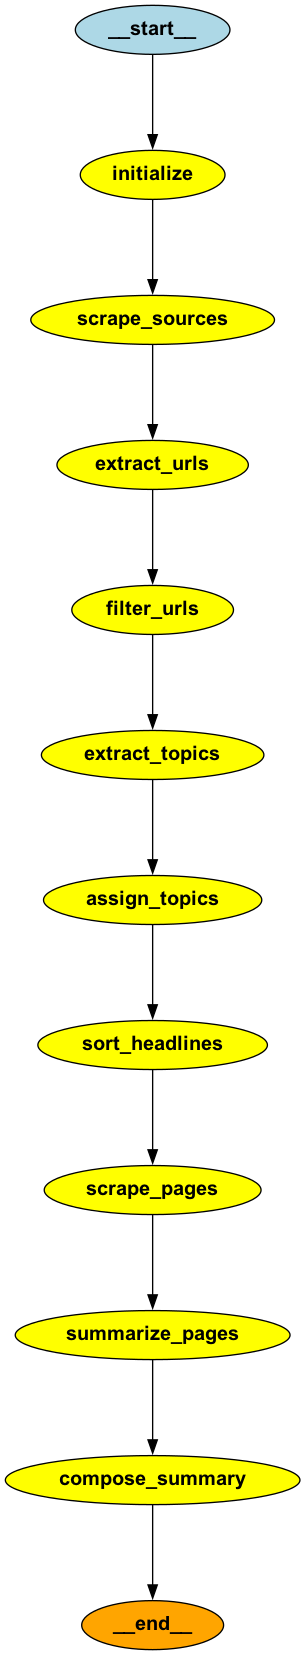

In [20]:
Image(lg_agent.graph.get_graph().draw_png())


In [21]:
# Configuration with thread ID for checkpointing
config = {"configurable": {"thread_id": "profile-thread-1"}}
# initial state
state = AgentState()
state["AIdf"]=pd.DataFrame()

lg_agent.run(config, state)


'Step 0'

""


'Step 1'

""


2024-07-10 09:27:17,321 - AInewsbot - INFO - get_driver - 38484 Initializing webdriver
2024-07-10 09:27:17,322 - AInewsbot - INFO - get_driver - 38484 Initializing webdriver
2024-07-10 09:27:17,322 - AInewsbot - INFO - get_driver - 38484 Initializing webdriver
2024-07-10 09:27:34,335 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-10 09:27:34,335 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-10 09:27:34,335 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-10 09:27:34,336 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-10 09:27:34,336 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-10 09:27:34,336 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-10 09:28:22,449 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-07-10 09:28:22,443 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-07-10 09:28:22,506 - AInewsbot - INFO - Proces

2024-07-10 09:29:08,628 - AInewsbot - INFO - Processing NYT Tech
2024-07-10 09:29:08,628 - AInewsbot - INFO - get_files(Technology - The New York Times) - starting get_files https://www.nytimes.com/section/technology
2024-07-10 09:29:14,755 - AInewsbot - INFO - get_files(Discover and Add New Feedly AI Feeds) - Loading additional infinite scroll items
2024-07-10 09:29:17,029 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-07-10 09:29:17,029 - AInewsbot - INFO - get_files(HackerNoon - read, write and l

2024-07-10 09:30:03,379 - AInewsbot - INFO - Quit webdriver
2024-07-10 09:30:06,245 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-07-10 09:30:06,246 - AInewsbot - INFO - get_files(Technology - The Washington Post) - Saving Technology - The Washington Post (07_10_2024 09_30_06 AM).html as utf-8
2024-07-10 09:30:06,249 - AInewsbot - INFO - Quit webdriver


'Step 2'

""


2024-07-10 09:30:08,741 - AInewsbot - INFO - Parsing html files
2024-07-10 09:30:08,742 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (07_10_2024 09_28_33 AM).html
2024-07-10 09:30:08,790 - AInewsbot - INFO - parse_file - found 252 raw links
2024-07-10 09:30:08,793 - AInewsbot - INFO - parse_file - found 32 filtered links
2024-07-10 09:30:08,793 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology - Bloomberg (07_10_2024 09_28_34 AM).html
2024-07-10 09:30:08,818 - AInewsbot - INFO - parse_file - found 290 raw links
2024-07-10 09:30:08,822 - AInewsbot - INFO - parse_file - found 51 filtered links
2024-07-10 09:30:08,822 - AInewsbot - INFO - Business Insider -> htmldata/Tech - Business Insider (07_10_2024 09_28_36 AM).html
2024-07-10 09:30:08,844 - AInewsbot - INFO - parse_file - found 310 raw links
2024-07-10 09:30:08,848 - AInewsbot - INFO - parse_file - found 52 filtered links
2024-07-10 09:30:08,848 - AInewsbot - INFO - FT Tech -> htmldata/Technology (07_

'Step 3'

""


2024-07-10 09:30:10,127 - AInewsbot - INFO - Existing URLs: 126162
2024-07-10 09:30:10,151 - AInewsbot - INFO - New URLs: 571
2024-07-10 09:30:10,531 - AInewsbot - INFO - Paginated 12 pages
2024-07-10 09:30:10,532 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,532 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,532 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,533 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,533 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,533 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,533 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,534 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,534 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,534 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,534 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:10,535 - AInewsbot - INFO - sent 21 items 
2024-07-10 09:30:15,105 - AInewsbot - INFO - got dict with 21 items 
2024-07-10 09:30:17,3

'Step 4'

""


2024-07-10 09:30:21,355 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:21,357 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:21,358 - AInewsbot - INFO - sent 50 items 
2024-07-10 09:30:21,360 - AInewsbot - INFO - sent 24 items 
2024-07-10 09:30:32,102 - AInewsbot - INFO - got dict with 25 items 
2024-07-10 09:30:40,115 - AInewsbot - INFO - got dict with 50 items 
2024-07-10 09:30:41,517 - AInewsbot - INFO - got dict with 50 items 
2024-07-10 09:30:43,764 - AInewsbot - INFO - got dict with 61 items 
2024-07-10 09:30:43,768 - AInewsbot - INFO - Processed 186 responses.


'Step 5'

""


2024-07-10 09:30:43,787 - AInewsbot - INFO - Categorizing headline 1 of 186
2024-07-10 09:30:43,788 - AInewsbot - INFO - Could AIs become conscious? Right now, we have no way to tell.
2024-07-10 09:30:44,747 - AInewsbot - INFO - ['Ethical issues', 'Gen AI', 'Cognitive Science', 'OpenAI']
2024-07-10 09:30:44,749 - AInewsbot - INFO - Categorizing headline 2 of 186
2024-07-10 09:30:44,749 - AInewsbot - INFO - How disinformation from a Russian AI spam farm ended up on top of Google search results
2024-07-10 09:30:45,743 - AInewsbot - INFO - ['Ethical issues', 'Cybersecurity', 'Language Models', 'Disinformation', 'Google', 'Big Tech']
2024-07-10 09:30:45,744 - AInewsbot - INFO - Categorizing headline 3 of 186
2024-07-10 09:30:45,745 - AInewsbot - INFO - Baidu Surges With Bullish Options as Robotaxi Orders Climb
2024-07-10 09:30:46,561 - AInewsbot - INFO - ['Autonomous vehicles', 'Stocks', 'China', 'Baidu', 'Big Tech']
2024-07-10 09:30:46,562 - AInewsbot - INFO - Categorizing headline 4 of 1

2024-07-10 09:31:34,822 - AInewsbot - INFO - Salesforce Empowering Sales Reps With Data, AI: Tech Disruptors
2024-07-10 09:31:48,510 - AInewsbot - INFO - ['AI economic impacts', 'AI job market', 'Meta', 'Salesforce']
2024-07-10 09:31:48,512 - AInewsbot - INFO - Categorizing headline 30 of 186
2024-07-10 09:31:48,513 - AInewsbot - INFO - Principles of Reinforcement Learning: An Introduction with Python
2024-07-10 09:31:49,500 - AInewsbot - INFO - ['Reinforcement Learning']
2024-07-10 09:31:49,502 - AInewsbot - INFO - Categorizing headline 31 of 186
2024-07-10 09:31:49,503 - AInewsbot - INFO - New AI Assistants Can Solve Your Most Confusing Home Repair Dilemmas
2024-07-10 09:31:50,234 - AInewsbot - INFO - []
2024-07-10 09:31:50,236 - AInewsbot - INFO - Categorizing headline 32 of 186
2024-07-10 09:31:50,237 - AInewsbot - INFO - US, allies take down Kremlin-backed AI bot farm
2024-07-10 09:31:51,160 - AInewsbot - INFO - ['Policy and regulation', 'Ethical issues', 'Cybersecurity', 'AI doom

2024-07-10 09:32:18,277 - AInewsbot - INFO - ['Ethical issues', 'Cybersecurity', 'Language Models', 'OpenAI', 'ChatGPT']
2024-07-10 09:32:18,279 - AInewsbot - INFO - Categorizing headline 59 of 186
2024-07-10 09:32:18,280 - AInewsbot - INFO - Empowering NGOs with generative AI in the fight against human trafficking
2024-07-10 09:32:19,322 - AInewsbot - INFO - ['Gen AI']
2024-07-10 09:32:19,324 - AInewsbot - INFO - Categorizing headline 60 of 186
2024-07-10 09:32:19,324 - AInewsbot - INFO - L.A. Schools Probe Charges its Hyped, Now-Defunct AI Chatbot Misused Student Data
2024-07-10 09:32:20,498 - AInewsbot - INFO - ['Policy and regulation', 'Robots', 'Education', 'Ethical issues', 'Legal issues', 'Cybersecurity', 'Privacy', 'Language Models', 'Gen AI', 'ChatGPT']
2024-07-10 09:32:20,500 - AInewsbot - INFO - Categorizing headline 61 of 186
2024-07-10 09:32:20,501 - AInewsbot - INFO - CyrusOne scores another $7.9B in debt financing to expand AI datacenter empire
2024-07-10 09:32:22,243 - 

2024-07-10 09:32:59,160 - AInewsbot - INFO - ['AI economic impacts', 'Language Models', 'OpenAI', 'ChatGPT']
2024-07-10 09:32:59,162 - AInewsbot - INFO - Categorizing headline 87 of 186
2024-07-10 09:32:59,163 - AInewsbot - INFO - Forget Nvidia: The Artificial Intelligence (AI) Leader
2024-07-10 09:33:00,112 - AInewsbot - INFO - ['OpenAI']
2024-07-10 09:33:00,114 - AInewsbot - INFO - Categorizing headline 88 of 186
2024-07-10 09:33:00,115 - AInewsbot - INFO - Goldman Sachs: $1tn to be spent on AI data centers, chips, and utility upgrades, with "little to show for it so far"
2024-07-10 09:33:00,960 - AInewsbot - INFO - ['AI economic impacts', 'Semiconductor chips', 'Big Tech']
2024-07-10 09:33:00,961 - AInewsbot - INFO - Categorizing headline 89 of 186
2024-07-10 09:33:00,963 - AInewsbot - INFO - AI speech generator 'reaches human parity'  but it's too dangerous to release, scientists say
2024-07-10 09:33:01,994 - AInewsbot - INFO - ['Policy and regulation', 'LLMs', 'Ethical issues', 'A

2024-07-10 09:33:26,564 - AInewsbot - INFO - Defeated by A.I., a Legend in the Board Game Go Warns: Get Ready for What's Next
2024-07-10 09:33:27,313 - AInewsbot - INFO - ['Robots', 'AI doom']
2024-07-10 09:33:27,314 - AInewsbot - INFO - Categorizing headline 117 of 186
2024-07-10 09:33:27,315 - AInewsbot - INFO - New AI model can provide high-accuracy forecasts from even low-resolution data
2024-07-10 09:33:28,269 - AInewsbot - INFO - ['AI economic impacts', 'Gen AI', 'OpenAI']
2024-07-10 09:33:28,270 - AInewsbot - INFO - Categorizing headline 118 of 186
2024-07-10 09:33:28,271 - AInewsbot - INFO - AI Cant Replace Teaching, but It Can Make It Better
2024-07-10 09:33:29,333 - AInewsbot - INFO - ['Education']
2024-07-10 09:33:29,335 - AInewsbot - INFO - Categorizing headline 119 of 186
2024-07-10 09:33:29,336 - AInewsbot - INFO - Chinese AI chip makers sell themselves at Shanghai conference with Nvidia comparisons
2024-07-10 09:33:30,780 - AInewsbot - INFO - ['AI economic impacts', 'Chi

2024-07-10 09:33:56,794 - AInewsbot - INFO - ['Policy and regulation', 'LLMs', 'Ethical issues', 'Cybersecurity', 'AI doom', 'Language Models', 'Gen AI', 'Disinformation', 'Cohere']
2024-07-10 09:33:56,795 - AInewsbot - INFO - Categorizing headline 147 of 186
2024-07-10 09:33:56,796 - AInewsbot - INFO - Learn Generative AI with Google Cloud: New Courses from Introductory to Advanced Level
2024-07-10 09:33:57,523 - AInewsbot - INFO - ['Education', 'Gen AI', 'Google']
2024-07-10 09:33:57,525 - AInewsbot - INFO - Categorizing headline 148 of 186
2024-07-10 09:33:57,526 - AInewsbot - INFO - Defeated by A.I., a Legend in the Board Game Go Warns: Get Ready for Whats Next
2024-07-10 09:33:58,633 - AInewsbot - INFO - ['AI doom']
2024-07-10 09:33:58,634 - AInewsbot - INFO - Categorizing headline 149 of 186
2024-07-10 09:33:58,638 - AInewsbot - INFO - Peloton faces lawsuit amid claims it allowed marketing firm to train AI on user chat data
2024-07-10 09:33:59,491 - AInewsbot - INFO - ['Ethical i

2024-07-10 09:34:22,323 - AInewsbot - INFO - Categorizing headline 162 of 186
2024-07-10 09:34:22,324 - AInewsbot - INFO - Microsoft agrees to buy a record 500K carbon credits from US oil producer Occidental's 1PointFive to offset its emissions, as AI creates an energy surge
2024-07-10 09:34:23,279 - AInewsbot - INFO - ['Policy and regulation', 'Ethical issues', 'AI doom', 'Climate', 'Sustainability', 'Microsoft', 'Anthropic', 'Big Tech', 'Bill Gates']
2024-07-10 09:34:23,281 - AInewsbot - INFO - Categorizing headline 163 of 186
2024-07-10 09:34:23,282 - AInewsbot - INFO - Source: Apple is not taking an OpenAI board observer role, as AI antitrust scrutiny mounts; OpenAI plans to host regular meetings with investors and partners
2024-07-10 09:34:24,894 - AInewsbot - INFO - ['OpenAI', 'Apple', 'Big Tech']
2024-07-10 09:34:24,896 - AInewsbot - INFO - Categorizing headline 164 of 186
2024-07-10 09:34:24,897 - AInewsbot - INFO - Index Ventures, an early investor in Mistral and Cohere, close

'Step 6'

""


2024-07-10 09:34:37,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


'Step 7'

""


2024-07-10 09:34:41,213 - AInewsbot - INFO - get_driver - 38484 Initializing webdriver
2024-07-10 09:34:41,214 - AInewsbot - INFO - get_driver - 38484 Initializing webdriver
2024-07-10 09:34:41,215 - AInewsbot - INFO - get_driver - 38484 Initializing webdriver
2024-07-10 09:34:41,215 - AInewsbot - INFO - get_driver - 38484 Initializing webdriver
2024-07-10 09:35:00,053 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-10 09:35:00,053 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-10 09:35:00,053 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-10 09:35:00,053 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-10 09:35:00,054 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-10 09:35:00,054 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-10 09:35:00,054 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-10 09:35:00,055 - AInewsbot 

2024-07-10 09:36:32,330 - AInewsbot - INFO - get_url(Japan's AI unicorn to use Samsung's 2-nm chip production tech) - Saving Japan_s_AI_unicorn_to_use_Samsung_s_2-nm_chip_production_tech_20240710_093632.html as utf-8
2024-07-10 09:36:32,332 - AInewsbot - INFO - Processing https://www.tomshardware.com/tech-industry/artificial-intelligence/samsung-foundry-to-build-2nm-processors-with-hbm-for-japanese-ai-firm
2024-07-10 09:36:32,332 - AInewsbot - INFO - get_url(https://www.tomshardware.com/tech-industry/artificial-intelligence/samsung-foundry-to-build-2nm-processors-with-hbm-for-japanese-ai-firm) - starting get_url https://www.tomshardware.com/tech-industry/artificial-intelligence/samsung-foundry-to-build-2nm-processors-with-hbm-for-japanese-ai-firm
2024-07-10 09:36:39,991 - AInewsbot - INFO - get_url(Samsung Hikes Prices and Bets on AI to Reclaim Foldables Lead) - Saving Samsung_Hikes_Prices_and_Bets_on_AI_to_Reclaim_Foldables_Lead_20240710_093639.html as utf-8
2024-07-10 09:36:39,993 - 

2024-07-10 09:37:06,898 - AInewsbot - INFO - Processing https://www.zdnet.com/article/here-are-the-best-new-ai-features-coming-to-samsungs-galaxy-foldable-phones/#ftag=RSSbaffb68
2024-07-10 09:37:06,898 - AInewsbot - INFO - get_url(https://www.zdnet.com/article/here-are-the-best-new-ai-features-coming-to-samsungs-galaxy-foldable-phones/#ftag=RSSbaffb68) - starting get_url https://www.zdnet.com/article/here-are-the-best-new-ai-features-coming-to-samsungs-galaxy-foldable-phones/#ftag=RSSbaffb68
2024-07-10 09:37:10,526 - AInewsbot - INFO - get_url(Zhiyun Smooth 5S AI review: follow your every move) - Saving Zhiyun_Smooth_5S_AI_review__follow_your_every_move_20240710_093710.html as utf-8
2024-07-10 09:37:10,531 - AInewsbot - INFO - Processing https://www.businessinsider.com/guides/tech/samsung-galaxy-watch-7-ultra-release-date-price-features-specs
2024-07-10 09:37:10,531 - AInewsbot - INFO - get_url(https://www.businessinsider.com/guides/tech/samsung-galaxy-watch-7-ultra-release-date-price

2024-07-10 09:37:32,793 - AInewsbot - INFO - get_url(https://www.investors.com/news/technology/tsm-stock-chipmaker-tsmc-beats-june-sales-goal/) - starting get_url https://www.investors.com/news/technology/tsm-stock-chipmaker-tsmc-beats-june-sales-goal/
2024-07-10 09:37:38,475 - AInewsbot - INFO - get_url(Samsung debuts Galaxy Flip 6 and Fold 6 smartphones in generative AI push) - Saving Samsung_debuts_Galaxy_Flip_6_and_Fold_6_smartphones_in_generative_AI_push_20240710_093738.html as utf-8
2024-07-10 09:37:38,477 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3Lm1hcmtldHdhdGNoLmNvbS9zdG9yeS90c21jLW91dHN0cmlwcy1mb3JlY2FzdHMtaW4tcG9zdGluZy00MC1zdXJnZS1pbi1zZWNvbmQtcXVhcnRlci1zYWxlcy1kYjZhYzg2Y9IBc2h0dHBzOi8vd3d3Lm1hcmtldHdhdGNoLmNvbS9hbXAvc3RvcnkvdHNtYy1vdXRzdHJpcHMtZm9yZWNhc3RzLWluLXBvc3RpbmctNDAtc3VyZ2UtaW4tc2Vjb25kLXF1YXJ0ZXItc2FsZXMtZGI2YWM4NmM
2024-07-10 09:37:38,480 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMib2h0dHBzOi8vd3d

2024-07-10 09:38:03,858 - AInewsbot - INFO - get_url(Nvidia Is Buying Shares of These 5 AI Companies. Should You Do the Same?) - Saving Nvidia_Is_Buying_Shares_of_These_5_AI_Companies__Should_You_Do_the_Same__20240710_093803.html as utf-8
2024-07-10 09:38:03,860 - AInewsbot - INFO - Processing https://www.reddit.com/r/ChatGPT/comments/1dzq8v6/claude_35_sonnet_feels_generationally_superior/
2024-07-10 09:38:03,860 - AInewsbot - INFO - get_url(https://www.reddit.com/r/ChatGPT/comments/1dzq8v6/claude_35_sonnet_feels_generationally_superior/) - starting get_url https://www.reddit.com/r/ChatGPT/comments/1dzq8v6/claude_35_sonnet_feels_generationally_superior/
2024-07-10 09:38:06,178 - AInewsbot - INFO - get_url(Forget Nvidia: The Artificial Intelligence (AI) Leader) - Saving Forget_Nvidia__The_Artificial_Intelligence__AI__Leader_20240710_093806.html as utf-8
2024-07-10 09:38:06,180 - AInewsbot - INFO - Processing https://apnews.com/article/russia-disinformation-fbi-justice-department-5091072

2024-07-10 09:38:34,144 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMid2h0dHBzOi8vd3d3LnJldXRlcnMuY29tL3RlY2hub2xvZ3kvZ2xvYmFsLXBjLXNoaXBtZW50cy1yaXNlLXNlY29uZC1xdWFydGVyLWFwcGxlLXNlZXMtYmlnZ2VzdC1qdW1wLWlkYy1zYXlzLTIwMjQtMDctMDkv0gEA) - starting get_url https://news.google.com/articles/CBMid2h0dHBzOi8vd3d3LnJldXRlcnMuY29tL3RlY2hub2xvZ3kvZ2xvYmFsLXBjLXNoaXBtZW50cy1yaXNlLXNlY29uZC1xdWFydGVyLWFwcGxlLXNlZXMtYmlnZ2VzdC1qdW1wLWlkYy1zYXlzLTIwMjQtMDctMDkv0gEA
2024-07-10 09:38:38,449 - AInewsbot - INFO - get_url(The developers suing over GitHub Copilot got dealt a major blow in court) - Saving The_developers_suing_over_GitHub_Copilot_got_dealt_a_major_blow_in_court_20240710_093838.html as utf-8
2024-07-10 09:38:38,452 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiamh0dHBzOi8vd3d3LmJ1c2luZXNzaW5zaWRlci5jb20vc3RvY2stbWFya2V0LXdoZXJlLXRvLWludmVzdC1pbnZlc3Rpbmctc3RyYXRlZ3ktYWktZWNvbm9teS1qcG1vcmdhbi0yMDI0LTfSAW5odHRwczovL3d3dy5idXNpbmVzc2luc2lkZXIuY29tL3N

2024-07-10 09:39:00,266 - AInewsbot - INFO - get_url(New AI model can provide high-accuracy forecasts from even low-resolution data) - Saving New_AI_model_can_provide_high-accuracy_forecasts_from_even_low-resolution_data_20240710_093900.html as utf-8
2024-07-10 09:39:00,268 - AInewsbot - INFO - Processing https://9to5google.com/2024/07/09/google-one-dark-web-reports-all-google-accounts/
2024-07-10 09:39:00,268 - AInewsbot - INFO - get_url(https://9to5google.com/2024/07/09/google-one-dark-web-reports-all-google-accounts/) - starting get_url https://9to5google.com/2024/07/09/google-one-dark-web-reports-all-google-accounts/
2024-07-10 09:39:00,815 - AInewsbot - INFO - get_url(Machine Learning Masters Weather Prediction) - Saving Machine_Learning_Masters_Weather_Prediction_20240710_093900.html as utf-8
2024-07-10 09:39:00,817 - AInewsbot - INFO - Processing https://www.theregister.com/2024/07/10/cyrusone_ai_datacenter/
2024-07-10 09:39:00,818 - AInewsbot - INFO - get_url(https://www.thereg

2024-07-10 09:39:32,640 - AInewsbot - INFO - get_url(My trip to the frontier of AI education) - Saving My_trip_to_the_frontier_of_AI_education_20240710_093932.html as utf-8
2024-07-10 09:39:32,647 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMid2h0dHBzOi8vd3d3LmZveGJ1c2luZXNzLmNvbS9yZWFsLWVzdGF0ZS9zYW4tZnJhbmNpc2NvLW9mZmljZS12YWNhbmNpZXMtaGl0LWFsbC10aW1lLWhpZ2gtZGVzcGl0ZS1haS1ib29tLXNpbGljb24tdmFsbGV50gF7aHR0cHM6Ly93d3cuZm94YnVzaW5lc3MuY29tL3JlYWwtZXN0YXRlL3Nhbi1mcmFuY2lzY28tb2ZmaWNlLXZhY2FuY2llcy1oaXQtYWxsLXRpbWUtaGlnaC1kZXNwaXRlLWFpLWJvb20tc2lsaWNvbi12YWxsZXkuYW1w
2024-07-10 09:39:32,649 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMid2h0dHBzOi8vd3d3LmZveGJ1c2luZXNzLmNvbS9yZWFsLWVzdGF0ZS9zYW4tZnJhbmNpc2NvLW9mZmljZS12YWNhbmNpZXMtaGl0LWFsbC10aW1lLWhpZ2gtZGVzcGl0ZS1haS1ib29tLXNpbGljb24tdmFsbGV50gF7aHR0cHM6Ly93d3cuZm94YnVzaW5lc3MuY29tL3JlYWwtZXN0YXRlL3Nhbi1mcmFuY2lzY28tb2ZmaWNlLXZhY2FuY2llcy1oaXQtYWxsLXRpbWUtaGlnaC1kZXNwaXRlLWFpLWJvb20tc2lsaWNvbi1

2024-07-10 09:40:04,116 - AInewsbot - INFO - get_url(What would happen if a small asteroid hit Earth? NASA and AI found out) - Saving What_would_happen_if_a_small_asteroid_hit_Earth__NASA_and_AI_found_out_20240710_094004.html as utf-8
2024-07-10 09:40:04,117 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiXGh0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wNy8wOS9uaWNvbGFzLWNhZ2UtbG9uZ2xlZ3MtdGVycmlmaWVkLWFib3V0LWFpLWluZmx1ZW5jZS1ob2xseXdvb2Qv0gEA
2024-07-10 09:40:04,118 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiXGh0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wNy8wOS9uaWNvbGFzLWNhZ2UtbG9uZ2xlZ3MtdGVycmlmaWVkLWFib3V0LWFpLWluZmx1ZW5jZS1ob2xseXdvb2Qv0gEA) - starting get_url https://news.google.com/articles/CBMiXGh0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wNy8wOS9uaWNvbGFzLWNhZ2UtbG9uZ2xlZ3MtdGVycmlmaWVkLWFib3V0LWFpLWluZmx1ZW5jZS1ob2xseXdvb2Qv0gEA
2024-07-10 09:40:12,363 - AInewsbot - INFO - get_url(Microsoft Is Struggling to Get Companies Onboard the AI PC Hype Train: Report) - Savi

2024-07-10 09:40:44,800 - AInewsbot - INFO - Processing https://www.forbes.com/sites/jodiecook/2024/07/09/5-free-technical-ai-courses-to-supercharge-your-income-with-nvidia/
2024-07-10 09:40:44,801 - AInewsbot - INFO - get_url(https://www.forbes.com/sites/jodiecook/2024/07/09/5-free-technical-ai-courses-to-supercharge-your-income-with-nvidia/) - starting get_url https://www.forbes.com/sites/jodiecook/2024/07/09/5-free-technical-ai-courses-to-supercharge-your-income-with-nvidia/
2024-07-10 09:40:46,491 - AInewsbot - INFO - get_url(A Beloved Tech Blog Is Now Publishing AI Articles Under the Names of Its Old Human Staff) - Saving A_Beloved_Tech_Blog_Is_Now_Publishing_AI_Articles_Under_the_Names_of_Its_Old_Human_Staff_20240710_094046.html as utf-8
2024-07-10 09:40:46,494 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiSWh0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wNy8wOS9kcmVhbWZsYXJlLWFpLWdlbmVyYXRlZC12aWRlby1wbGF0Zm9ybS_SAQA
2024-07-10 09:40:46,496 - AInewsbot - INFO - get_

2024-07-10 09:41:19,401 - AInewsbot - INFO - get_url(https://9to5google.com/2024/07/09/google-one-dark-web-reports-all-google-accounts/) - starting get_url https://9to5google.com/2024/07/09/google-one-dark-web-reports-all-google-accounts/
2024-07-10 09:41:27,925 - AInewsbot - INFO - get_url(With funding from Jeff Bezos and others, Pittsburgh startup Skild AI company raises $300 million to build robot brains) - Saving With_funding_from_Jeff_Bezos_and_others__Pittsburgh_startup_Skild_AI_company_raises__300_million_to_build_robot_brains_20240710_094127.html as utf-8
2024-07-10 09:41:27,928 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiigFodHRwczovL3d3dy55YWhvby5jb20vZW50ZXJ0YWlubWVudC9yYXNoaWRhLWpvbmVzLXRhbGtzLWFjdGluZy1vcHBvc2l0ZS1hLXJvYm90LWluLXN1bm55LXNoZS13YXMtYS1oaWdoLW1haW50ZW5hbmNlLWNvLXN0YXItMTczMzU5NzM1Lmh0bWzSAQA
2024-07-10 09:41:27,929 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiigFodHRwczovL3d3dy55YWhvby5jb20vZW50ZXJ0YWlubWVudC9yYXN

2024-07-10 09:41:59,802 - AInewsbot - INFO - get_url(https://www.reddit.com/r/technology/comments/1dz9uyz/peloton_faces_lawsuit_amid_claims_it_allowed/) - starting get_url https://www.reddit.com/r/technology/comments/1dz9uyz/peloton_faces_lawsuit_amid_claims_it_allowed/
2024-07-10 09:42:01,767 - AInewsbot - INFO - get_url(Aitomatics SemiKong uses AI to reshape chipmaking processes) - Saving Aitomatics_SemiKong_uses_AI_to_reshape_chipmaking_processes_20240710_094201.html as utf-8
2024-07-10 09:42:01,768 - AInewsbot - INFO - Processing https://gizmodo.com/googles-gemini-ai-snakes-its-way-onto-samsungs-galaxy-foldables-2000453144
2024-07-10 09:42:01,769 - AInewsbot - INFO - get_url(https://gizmodo.com/googles-gemini-ai-snakes-its-way-onto-samsungs-galaxy-foldables-2000453144) - starting get_url https://gizmodo.com/googles-gemini-ai-snakes-its-way-onto-samsungs-galaxy-foldables-2000453144
2024-07-10 09:42:02,117 - AInewsbot - INFO - get_url(Elon Musk Renews Tussle With Sam Altman After Ope

2024-07-10 09:42:35,168 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMidmh0dHBzOi8vd3d3LnZhdGljYW5uZXdzLnZhL2VuL3ZhdGljYW4tY2l0eS9uZXdzLzIwMjQtMDcvd29ybGQtcmVsaWdpb25zLXRvLWNvbW1pdC10by1yb21lLWNhbGwtb24tYWktaW4taGlyb3NoaW1hLmh0bWzSAQA) - starting get_url https://news.google.com/articles/CBMidmh0dHBzOi8vd3d3LnZhdGljYW5uZXdzLnZhL2VuL3ZhdGljYW4tY2l0eS9uZXdzLzIwMjQtMDcvd29ybGQtcmVsaWdpb25zLXRvLWNvbW1pdC10by1yb21lLWNhbGwtb24tYWktaW4taGlyb3NoaW1hLmh0bWzSAQA
2024-07-10 09:42:42,689 - AInewsbot - INFO - get_url(I swear this girl was used to train image generator AIs....) - Saving I_swear_this_girl_was_used_to_train_image_generator_AIs_____20240710_094242.html as utf-8
2024-07-10 09:42:42,694 - AInewsbot - INFO - Processing https://www.reddit.com/r/technology/comments/1dzidgt/a_beloved_tech_blog_is_now_publishing_ai_articles/
2024-07-10 09:42:42,695 - AInewsbot - INFO - get_url(https://www.reddit.com/r/technology/comments/1dzidgt/a_beloved_tech_blog_is_now_publishing_ai_artic

2024-07-10 09:43:17,809 - AInewsbot - INFO - get_url(Salesforce Empowering Sales Reps With Data, AI: Tech Disruptors) - Saving Salesforce_Empowering_Sales_Reps_With_Data__AI__Tech_Disruptors_20240710_094317.html as utf-8
2024-07-10 09:43:17,812 - AInewsbot - INFO - Processing https://www.nytimes.com/2024/07/10/world/asia/lee-saedol-go-ai.html
2024-07-10 09:43:17,812 - AInewsbot - INFO - get_url(https://www.nytimes.com/2024/07/10/world/asia/lee-saedol-go-ai.html) - starting get_url https://www.nytimes.com/2024/07/10/world/asia/lee-saedol-go-ai.html
2024-07-10 09:43:24,716 - AInewsbot - INFO - get_url(OpenAI cuts off China from ChatGPT and AI services) - Saving OpenAI_cuts_off_China_from_ChatGPT_and_AI_services_20240710_094324.html as utf-8
2024-07-10 09:43:24,718 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiWWh0dHBzOi8vbmV3YXRsYXMuY29tL3RlY2hub2xvZ3kvY2hpbmEtYXJ0aWZpY2lhbC1pbnRlbGxpZWdlbmNlaS1ndWlkZWxpbmUtaHVtYW5pdHktZmlyc3Qv0gEA
2024-07-10 09:43:24,719 - AInewsb

2024-07-10 09:43:54,994 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiSWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9jaGluZXNlLWFpLWNoaXAtbWFrZXJzLXNlbGwtMDkzMDAwMjk0Lmh0bWzSAQA) - starting get_url https://news.google.com/articles/CBMiSWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9jaGluZXNlLWFpLWNoaXAtbWFrZXJzLXNlbGwtMDkzMDAwMjk0Lmh0bWzSAQA
2024-07-10 09:43:58,197 - AInewsbot - INFO - get_url(The next Intel desktop chips may muddy the AI waters) - Saving The_next_Intel_desktop_chips_may_muddy_the_AI_waters_20240710_094358.html as utf-8
2024-07-10 09:43:58,199 - AInewsbot - INFO - Processing https://www.reddit.com/r/ProgrammerHumor/comments/1dzlp7x/proprietaryai/
2024-07-10 09:43:58,199 - AInewsbot - INFO - get_url(https://www.reddit.com/r/ProgrammerHumor/comments/1dzlp7x/proprietaryai/) - starting get_url https://www.reddit.com/r/ProgrammerHumor/comments/1dzlp7x/proprietaryai/
2024-07-10 09:44:00,335 - AInewsbot - INFO - get_url(China's laws of robotics: AI guidelines urge 

2024-07-10 09:44:26,521 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMikwFodHRwczovL3RpbWVzb2ZpbmRpYS5pbmRpYXRpbWVzLmNvbS90ZWNobm9sb2d5L3RlY2gtdGlwcy93aGF0LWlzLWFpLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWFuZC1pdHMtdXNlcy1pbi1ldmVyeWRheS1saWZlL2FydGljbGVzaG93LzExMTU2OTcyNS5jbXPSAZcBaHR0cHM6Ly90aW1lc29maW5kaWEuaW5kaWF0aW1lcy5jb20vdGVjaG5vbG9neS90ZWNoLXRpcHMvd2hhdC1pcy1haS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1hbmQtaXRzLXVzZXMtaW4tZXZlcnlkYXktbGlmZS9hbXBfYXJ0aWNsZXNob3cvMTExNTY5NzI1LmNtcw) - starting get_url https://news.google.com/articles/CBMikwFodHRwczovL3RpbWVzb2ZpbmRpYS5pbmRpYXRpbWVzLmNvbS90ZWNobm9sb2d5L3RlY2gtdGlwcy93aGF0LWlzLWFpLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWFuZC1pdHMtdXNlcy1pbi1ldmVyeWRheS1saWZlL2FydGljbGVzaG93LzExMTU2OTcyNS5jbXPSAZcBaHR0cHM6Ly90aW1lc29maW5kaWEuaW5kaWF0aW1lcy5jb20vdGVjaG5vbG9neS90ZWNoLXRpcHMvd2hhdC1pcy1haS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1hbmQtaXRzLXVzZXMtaW4tZXZlcnlkYXktbGlmZS9hbXBfYXJ0aWNsZXNob3cvMTExNTY5NzI1LmNtcw
2024-07-10 09:44:30,047 - AInewsbot - I

2024-07-10 09:44:44,573 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiU2h0dHBzOi8vd3d3Lm1hcmtldGluZ2RpdmUuY29tL25ld3MvZXRzeS1icmFuZC1taXNzaW9uLWFpLW1hcmtldGluZy1jYW1wYWlnbi83MjA4MjUv0gEA) - starting get_url https://news.google.com/articles/CBMiU2h0dHBzOi8vd3d3Lm1hcmtldGluZ2RpdmUuY29tL25ld3MvZXRzeS1icmFuZC1taXNzaW9uLWFpLW1hcmtldGluZy1jYW1wYWlnbi83MjA4MjUv0gEA
2024-07-10 09:44:47,167 - AInewsbot - INFO - get_url(Website uses AI software to predict the presidential race, and the winner is ...) - Saving Website_uses_AI_software_to_predict_the_presidential_race__and_the_winner_is_____20240710_094447.html as utf-8
2024-07-10 09:44:47,168 - AInewsbot - INFO - Processing https://venturebeat.com/ai/enterprises-embrace-generative-ai-but-challenges-remain/
2024-07-10 09:44:47,168 - AInewsbot - INFO - get_url(https://venturebeat.com/ai/enterprises-embrace-generative-ai-but-challenges-remain/) - starting get_url https://venturebeat.com/ai/enterprises-embrace-generative-ai-but-ch

2024-07-10 09:45:11,668 - AInewsbot - INFO - Processing https://www.wsj.com/articles/its-time-for-ai-to-start-making-money-for-businesses-can-it-b476c754
2024-07-10 09:45:11,670 - AInewsbot - INFO - get_url(https://www.wsj.com/articles/its-time-for-ai-to-start-making-money-for-businesses-can-it-b476c754) - starting get_url https://www.wsj.com/articles/its-time-for-ai-to-start-making-money-for-businesses-can-it-b476c754
2024-07-10 09:45:15,342 - AInewsbot - INFO - get_url(How disinformation from a Russian AI spam farm ended up on top of Google search results) - Saving How_disinformation_from_a_Russian_AI_spam_farm_ended_up_on_top_of_Google_search_results_20240710_094515.html as utf-8
2024-07-10 09:45:15,343 - AInewsbot - INFO - Processing https://www.washingtonpost.com/politics/2024/07/10/gop-platform-trump-tech-crypto-ai-musk/
2024-07-10 09:45:15,343 - AInewsbot - INFO - get_url(https://www.washingtonpost.com/politics/2024/07/10/gop-platform-trump-tech-crypto-ai-musk/) - starting get_u

2024-07-10 09:45:37,183 - AInewsbot - INFO - get_url(Babel fish? We're getting there. Reg reviews the Timekettle X1 AI Interpreter HubReviewA handy standalone translator, but you'll need deep pockets, both figuratively and literally, if you want oneAI + ML5 hrs|14) - Saving Babel_fish__We_re_getting_there__Reg_reviews_the_Timekettle_X1_AI_Interpreter_HubReviewA_handy_standalone_translator__but_you_ll_need_deep_pockets__both_figuratively_and_literally__if_you_want_oneAI___ML5_hrs_14_20240710_094537.html as utf-8
2024-07-10 09:45:37,186 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiMGh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS90cmVuZHMvZHJlYW1mbGFyZS1hadIBAA
2024-07-10 09:45:37,186 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiMGh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS90cmVuZHMvZHJlYW1mbGFyZS1hadIBAA) - starting get_url https://news.google.com/articles/CBMiMGh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS90cmVuZHMvZHJlYW1mbGFyZS1hadIBAA
2024-07-10 09:45:37,273 - AIne

'Step 8'

""


[1. Microsoft and Apple give up their OpenAI board seats - Feedly AI](https://www.engadget.com/microsoft-and-apple-give-up-their-openai-board-seats-120022867.html)  

 Apple, Big Tech, Bill Gates, Board Seats, Microsoft, Openai, Resignation 

- Microsoft has withdrawn from OpenAI's board of directors in response to EU antitrust scrutiny on their partnership, citing confidence in the company's direction.
- Apple will no longer receive an observer seat on OpenAI's board, opting for regular meetings with key partners instead.
- European authorities are investigating Microsoft's relationship with OpenAI as part of a broader antitrust inquiry, focusing on potential negative effects on competitors.  

[2. Source: Apple is not taking an OpenAI board observer role, as AI antitrust scrutiny mounts; OpenAI plans to host regular meetings with investors and partners - Techmeme](https://t.co/6ZU8HAhnGY)  

 Antitrust Scrutiny, Apple, Big Tech, Board Observer Role, Investors, Openai 

- Microsoft and Apple have dropped their seats on the board of OpenAI amidst antitrust scrutiny.
- This move indicates a shift in tech companies' involvement in organizations under increased regulatory scrutiny.
- The decision reflects a cautious approach by these companies to avoid appearing to exert too much influence in sectors facing antitrust challenges.  

[3. Microsoft and Apple may be playing the long game by ditching OpenAI board roles - Business Insider](https://www.businessinsider.com/microsoft-apple-ditch-openai-board-observer-seats-regulators-2024-7)  

 Apple, Big Tech, Board Roles, Long Game, Microsoft, Openai 

- Microsoft has relinquished its observer role on OpenAI's board, possibly to address antitrust concerns over their influence in the AI sector.
- Apple is expected to follow suit and not take up a similar observer role on OpenAI's board, amidst mounting antitrust scrutiny of Big Tech's involvement in AI.
- The moves by Microsoft and Apple may be influenced by ongoing competition and antitrust scrutiny of their influence over emerging AI players like OpenAI.  

[4. Microsoft gives up an observer seat on OpenAI's board, citing the new board's significant progress and saying the company is confident in OpenAI's direction - Techmeme](https://www.axios.com/2024/07/10/microsoft-openai-board-seat-observer)  

 Big Tech, Education, Microsoft, Online Learning, Openai, Technology 

- Microsoft gives up observer seat on OpenAI board due to the firm's progress and confidence in its direction
- OpenAI reconstituted its board with key additions such as Adam D'Angelo, Bret Taylor, Larry Summers, and Paul Nakasone
- Apple executive Phil Schiller was planned to receive an observer seat on the board, but OpenAI now plans to have no observers after Microsoft's departure
  

[5. Microsoft gives up an observer seat on OpenAI's board, citing the new board's significant progress and saying the company is confident in OpenAI's direction - Techmeme](https://www.axios.com/2024/07/10/microsoft-openai-board-seat-observer)  

 Big Tech, Board Seat, Direction, Microsoft, Openai, Progress 

- Microsoft gives up observer seat on OpenAI board due to confidence in the firm's progress and no longer seeing the seat as necessary
- OpenAI reconstituted its board in November, adding new members and removing Microsoft as an observer
- With Microsoft's departure, OpenAI no longer plans to have any observers on its board, potentially removing a concern for antitrust regulators.  

[6. Microsoft and Apple ditch OpenAI board seats amid regulatory scrutiny - The Verge](https://www.theverge.com/2024/7/10/24195528/microsoft-apple-openai-board-observer-seat-drop-regulator-scrutiny)  

 Apple, Big Tech, Board Seats, Ethical Issues, Legal Issues, Microsoft, Openai, Policy And Regulation, Regulatory Scrutiny 

- Microsoft and Apple have relinquished their board seats at OpenAI amid growing regulatory scrutiny.
- OpenAI is switching to stakeholder meetings rather than board seats for key partners like Microsoft and Apple.
- Antitrust concerns have emerged over the Microsoft-OpenAI deal, with regulators in the UK, EU, and the FTC investigating Big Tech AI partnerships.  

[7. Microsoft, Apple Drop OpenAI Board Plans as Scrutiny Grows - Bloomberg Tech](https://www.bloomberg.com/news/articles/2024-07-10/microsoft-quits-openai-board-after-antitrust-scrutiny-grows)  

 Apple, Big Tech, Board Plans, Ethical Issues, Microsoft, Openai, Scrutiny 

- Microsoft and Apple have decided not to take board roles at OpenAI, citing regulatory scrutiny over Big Tech's influence on artificial intelligence.
- Regulators in Europe and the US are concerned about Microsoft's dominance in AI and are investigating its deals with OpenAI and Inflection AI.
- Large tech companies like Microsoft, Amazon, Nvidia, and Alphabet are facing regulatory scrutiny for their investments and partnerships in the AI sector.  

[8. Japan's AI unicorn to use Samsung's 2-nm chip production tech - Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vYXNpYS5uaWtrZWkuY29tL0J1c2luZXNzL1RlY2gvU2VtaWNvbmR1Y3RvcnMvSmFwYW4tcy1BSS11bmljb3JuLXRvLXVzZS1TYW1zdW5nLXMtMi1ubS1jaGlwLXByb2R1Y3Rpb24tdGVjaNIBAA)  

 2-Nm Chip Production, AI Economic Impacts, AI Unicorn, Big Tech, Japan, Samsung, Semiconductor Chips 

- Japan's AI startup, Preferred Networks, will utilize Samsung Electronics's 2-nanometer technology for developing advanced chips for generative AI as part of a government-backed initiative.
- The collaboration aims to leverage Samsung's cutting-edge production and packaging technology to enhance the efficiency and computing power of AI chips, marking Japan's efforts to revive its semiconductor industry.
- Preferred Networks, valued at approximately $2.1 billion, has been designing its own chips since 2016, focusing on increasing efficiency and reducing energy consumption for AI applications compared to traditional GPUs.  

[9. Workers' strikes and a gloomy forecast for its foundries take the shine off Samsung's AI-boosted revenue and profits - Feedly AI](https://www.pcgamer.com/hardware/workers-strikes-and-a-gloomy-forecast-for-its-foundries-take-the-shine-off-samsungs-ai-boosted-revenue-and-profits/)  

 Big Tech, Foundries, Profits, Revenue, Samsung, Semiconductor Chips, Workers' Strikes 

- Samsung Electronics is experiencing a mixture of successes and challenges, with a significant operating profit increase fueled by AI demand for memory chips but overshadowed by workers' strikes and a bleak future forecast for its foundries.
- Despite the optimistic financial outlook, Samsung faces ongoing strikes by thousands of workers demanding better pay and benefits, as well as an independent prediction of a sharp decline in its global market share in chip manufacturing by 2032.
- Samsung aims to maintain its position as the second-largest chip manufacturer, but faces obstacles such as failing to meet requirements for certain chips and the likelihood of losing market share to competitors like TSMC due to a shift in chip production to the US and Europe.  

[10. Samsung to make 2nm chips for Japan AI firm - Google News](https://news.google.com/articles/CBMiTWh0dHBzOi8vd3d3LmRpZ2l0aW1lcy5jb20vbmV3cy9hMjAyNDA3MDlWTDIwNC9zYW1zdW5nLTJubS1jaGlwcy1qYXBhbi1haS5odG1s0gEA)  

 2Nm Chips, AI Economic Impacts, AI Firm, AI Job Market, Big Tech, Japan, Samsung, Semiconductor Chips, Technology 

- Samsung Electronics to provide turnkey semiconductor solutions using 2nm foundry process to Preferred Networks, a Japanese AI company
- Advanced 2.5D packaging technology Interposer-Cube S (I-Cube S) will be utilized in the semiconductor solutions
- The agreement reflects Samsung's commitment to innovation in chip manufacturing and meeting the demands of the AI market  

[11. Samsung Hikes Prices and Bets on AI to Reclaim Foldables Lead - Bloomberg Tech](https://www.bloomberg.com/news/articles/2024-07-10/samsung-galaxy-fold-6-flip-6-release-date-price-and-ai-plans)  

 AI Economic Impacts, Big Tech, Foldables, Pricing Strategy, Samsung 

- Samsung aims to reclaim its position as the top foldables maker by integrating AI features into its Galaxy Z Flip 6 and Galaxy Z Fold 6 models.
- The new Samsung foldable phones offer advanced AI functionalities like automatic interpreting for social apps and collaborate with Google for AI tools.
- Samsung targets the premium tier market, especially in China, by customizing products for local consumers and partnering with big Chinese IT companies like Baidu for AI tools.  

[12. Samsung Foundry to build 2nm processors with HBM for Japanese AI firm - Feedly AI](https://www.tomshardware.com/tech-industry/artificial-intelligence/samsung-foundry-to-build-2nm-processors-with-hbm-for-japanese-ai-firm)  

 2Nm Processors, AI Economic Impacts, AI Job Market, Big Tech, Gen AI, Hbm, Japanese AI Firm, Samsung, Samsung Foundry, Semiconductor Chips 

- Samsung Foundry partners with Japanese AI firm Preferred Networks for custom AI processor using 2nm technology
- The processors will be developed with Gaonchips and feature Interposer-Cube S 2.5D packaging technology with HBM memory
- Samsung aims to start high-volume manufacturing of chips on its SF2 fabrication process in 2025, catering to smartphone and high-performance computing applications  

[13. Samsung unveils its new Galaxy Ring, an AI-backed competitor to the Oura Ring - Business Insider](https://www.businessinsider.com/guides/tech/samsung-galaxy-ring-release-date-price-features-specs)  

 AI-Backed, Big Tech, Competitor, Galaxy Ring, Samsung 

- Samsung has introduced the Galaxy Ring, a discreet health-tracking wearable ring with AI-powered features
- The Galaxy Ring is available for preorder at $399.99 and is set to be released on July 24
- The ring offers features like heart-rate monitoring, activity tracking, and unique AI features such as Energy Score and Wellness Tips  

[14. Samsung Galaxy Unpacked: all the news on the summer product event - Google News](https://news.google.com/articles/CBMibGh0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzcvMTAvMjQxOTQ4ODEvc2Ftc3VuZy1nYWxheHktdW5wYWNrZWQtcmluZy1haS16LWZvbGQtNi1mbGlwLXdhdGNoLTctdWx0cmEtYnVkc9IBAA)  

 Big Tech, Samsung, Samsung Galaxy Unpacked, Summer Product Event 

- Samsung unpacked a new batch of foldables and AI features at the summer product event in Paris, revealing new products like the Galaxy Ring, Galaxy Buds, Galaxy Z Fold 6, and Galaxy Watch Ultra.
- Samsung introduced the Galaxy Ring as a $399.99 smart ring with features like titanium frame, 10ATM water resistance, and sleep tracking capabilities.
- The Galaxy Z Fold 6 and Flip 6 received minor updates, higher prices, and improvements such as a Snapdragon 8 Gen 3 chipset, improved durability, and brighter displays.  

[15. Samsung launches foldable phones with enhanced AI to stay ahead of Chinese rivals - FT Tech](https://www.ft.com/content/8b806d9d-1fb6-462e-ba6a-ea357e6357e5)  

 AI Features, Big Tech, Chinese Rivals, Foldable Phones, Samsung 

- Samsung has launched foldable phones with enhanced AI technology 
- The aim is to outdo Chinese competitors in the smartphone market
- Samsung's strategy focuses on innovation to maintain a competitive edge  

[16. Samsung brings techs latest fashion to wearable technology with AI twists in new watch and ring - Google News](https://news.google.com/articles/CBMijwFodHRwczovL3RoZWhpbGwuY29tL2hvbWVuZXdzL2FwL2FwLWJ1c2luZXNzL2FwLXNhbXN1bmctYnJpbmdzLXRlY2hzLWxhdGVzdC1mYXNoaW9uLXRvLXdlYXJhYmxlLXRlY2hub2xvZ3ktd2l0aC1haS10d2lzdHMtaW4tbmV3LXdhdGNoLWFuZC1yaW5nL9IBkwFodHRwczovL3RoZWhpbGwuY29tL2hvbWVuZXdzL2FwL2FwLWJ1c2luZXNzL2FwLXNhbXN1bmctYnJpbmdzLXRlY2hzLWxhdGVzdC1mYXNoaW9uLXRvLXdlYXJhYmxlLXRlY2hub2xvZ3ktd2l0aC1haS10d2lzdHMtaW4tbmV3LXdhdGNoLWFuZC1yaW5nL2FtcC8)  

 AI Twists, Big Tech, Gen AI, Ring, Samsung, Watch, Wearable Technology 

- Samsung introduces AI features in its new premium smartwatch and smart ring to help users monitor and manage their health
- The smartwatch offers more sophisticated functions like flagging sleep apnea, while the smart ring focuses on longer battery life
- Wearable technology market is expected to see growth, with smartwatches leading the way and Samsung facing challenges in the smart ring niche market  

[17. Samsungs new Galaxy Buds 3 and Buds 3 Pro are like AirPods with AI smarts - Feedly AI](https://www.digitaltrends.com/home-theater/samsung-galaxy-buds-3-buds-3-pro-official/)  

 AI Features, AIrpods Design, Big Tech, Galaxy Buds 3 Pro, Samsung 

- Samsung Galaxy Buds 3 and Buds 3 Pro closely resemble Apple's AirPods Gen 3 and AirPods Pro, both in design and pricing.
- The new Galaxy Buds offer improvements over previous models, including water and dust resistance, hi-res audio capabilities, active noise cancellation, and AI features.
- Both models of Galaxy Buds come with a charging case design similar to Apple's, but offer unique elements like transparent lids and will be available in silver and white colors.  

[18. Samsung's Galaxy Buds 3 have an AirPods-esque design and a dash of AI - Feedly AI](https://www.engadget.com/samsungs-galaxy-buds-3-have-an-airpods-esque-design-and-a-dash-of-ai-130019399.html)  

 AI Integration, AIrpods Design, Big Tech, Galaxy Buds 3, Samsung 

- Samsung's Galaxy Buds 3 lineup features an AirPods-like design with new features such as ANC and a stickbud design.
- The Galaxy Buds 3 Pro model offers advanced features like ambient sound mode, two-way speakers, and superior noise cancellation capabilities.
- Both models come with AI features like an Interpreter tool, Adaptive EQ, and hands-free voice controls, along with improved voice quality and machine-learning models.  

[19. Zhiyun Smooth 5S AI review: follow your every move - Feedly AI](https://www.digitalcameraworld.com/reviews/zhiyun-smooth-5s-ai-review)  

 AI Review, Movement Tracking, Zhiyun Smooth 5S 

- Zhiyun Smooth 5S AI is equipped with an AI tracker that enhances video recordings by following every movement, allowing for smooth tracks, pans, and tilts.
- The compact 3-axis gimbal is designed for smartphones, offering cinematic camera moves such as tilts, pans, cranes, gliding shots, and dolly moves.
- Featuring a magnetic AI sensor, Zhiyun Smooth 5S AI enables the attached smartphone to tilt and pan to track the movements of the user, providing various shooting modes for professional camera moves.  

[20. Samsung Galaxy Z Fold and Z Flip 6 arrive with Galaxy AI and Google Gemini - Feedly AI](https://techcrunch.com/2024/07/10/samsung-galaxy-z-fold-and-z-flip-6-arrive-with-galaxy-ai-and-google-gemini/)  

 AI Features, Big Tech, Galaxy Z Flip, Galaxy Z Fold, Google Gemini, Samsung 

- Galaxy Z Fold 6 and Z Flip 6 are thinner and lighter than predecessors, with starting prices at $1,900 and $1,100 respectively, offering a $100 increase from earlier models.
- The devices focus heavily on AI features, with 25 "AI" mentions in the release, showcasing an emphasis on Galaxy AI and Google Gemini integration for tasks like writing, learning, and planning.
- Samsung is seen responding to market demands with the shift to a squarer internal aspect ratio in the Galaxy Z Flip 6, while maintaining its dominance in the foldables space, noting that the category is still in its early stages of development.  

[21. Samsungs new Galaxy Z Fold 6 is swiping many of the AI features from the S24 Ultra - Feedly AI](https://www.engadget.com/samsungs-new-galaxy-z-fold-6-is-swiping-many-of-the-ai-features-from-the-s24-ultra-130044113.html)  

 AI Features, Big Tech, Galaxy Z Fold 6, S24 Ultra, Samsung 

- Samsung's new Galaxy Z Fold 6 integrates AI features from the S24 Ultra, including interpreter mode, live translation, and chat assist
- The device features Gorilla Glass Victus 2, a Snapdragon 8 Gen 3 chip, 12GB of RAM, and a 7.6-inch AMOLED main screen
- The Galaxy Z Fold 6 is the brightest device in its category at 2,600 nits and is available for preorder starting at $1,900  

[22. Here are the best new AI features coming to Samsung's Galaxy foldable phones - Feedly AI](https://www.zdnet.com/article/here-are-the-best-new-ai-features-coming-to-samsungs-galaxy-foldable-phones/#ftag=RSSbaffb68)  

 AI Features, Big Tech, Galaxy Foldable Phones, New Releases, Samsung 

- Samsung unveiled the Galaxy Z Flip 6 and Galaxy Z Fold 6 at Samsung Unpacked 2024, both packed with new AI features.
- The Galaxy Z Fold 6 offers AI productivity tools like Note Assist, Smart Select with S Pen, and Interpreter feature.
- Samsung's new AI features for photography include ProVisual Engine, Portrait Studio, and Instant Slow-mo; integration of Gemini app for AI assistant.  

[23. Samsung announces its latest smartwatches, including a brand-new Galaxy Watch Ultra designed to take on Apple's high-end wearable - Business Insider](https://www.businessinsider.com/guides/tech/samsung-galaxy-watch-7-ultra-release-date-price-features-specs)  

 Apple Competition, Big Tech, Galaxy Watch Ultra, Samsung, Smartwatches 

- Samsung announced a new Galaxy Watch lineup featuring the first Galaxy Watch Ultra and Galaxy Watch 7, with integrated Galaxy AI powering new features like "Energy Score" and "Wellness Tips."
- The Galaxy Watch Ultra includes new AI-powered features, a titanium case, Quick Button for workout control, enhanced sensors for fitness tracking, and a starting price of $649.99.
- The Galaxy Watch 7 offers upgrades like increased storage, BioActive Sensor, and Exynos W1000 processor, starting at $299.99, along with similar Galaxy AI-powered features as the Ultra model.  

[24. Samsungs AI-powered foldable phones get slimmer, thinner, pricier - Google News](https://news.google.com/articles/CBMiRGh0dHBzOi8vd3d3LmNubi5jb20vMjAyNC8wNy8xMC90ZWNoL3NhbXN1bmctei1mb2xkLWZsaXAtNi9pbmRleC5odG1s0gE9aHR0cHM6Ly9hbXAuY25uLmNvbS9jbm4vMjAyNC8wNy8xMC90ZWNoL3NhbXN1bmctei1mb2xkLWZsaXAtNg)  

 AI-Powered Phones, Big Tech, Innovation, Samsung, Technology 

- Samsung introduced slimmer and thinner foldable phones, the Galaxy Z Fold 6 and Galaxy Z Flip 6, with AI tools and improved features at a higher cost.
- The devices aim to entice traditional phone users with AI capabilities like transcription, translation, summarizing, live translation for calls, and generative AI features for enhanced productivity.
- Samsung's foldable line incorporates AI heavily, offering a hybrid approach to privacy, while also unveiling a new smart ring for health monitoring and Galaxy Buds 3 with interpreter mode and control functions for music playback.  

[25. Check out this crazy cool One UI 6.1.1 Galaxy AI feature! - Google News](https://news.google.com/articles/CBMiWGh0dHBzOi8vd3d3LnNhbW1vYmlsZS5jb20vbmV3cy9jaGVjay1vdXQtdGhpcy1jcmF6eS1jb29sLW9uZS11aS02LTEtMS1nYWxheHktYWktZmVhdHVyZS_SAQA)  

 Big Tech, Galaxy AI Feature, One Ui 6.1.1, Samsung, Technology 

- Samsung will unveil a new version of One UI, One UI 6.1.1, alongside two next-gen foldable phones, with rumors suggesting the addition of new Galaxy AI tools
- One rumored Galaxy AI feature for One UI 6.1.1 is an innovative drawing tool named AI Graffiti, which can convert rough sketches into realistic representations using Generative AI techniques
- The new Generative drawing tool is expected to be a part of Galaxy AI via the One UI 6.1.1 update, and it remains to be seen whether it will be exclusive to the new foldable phones or available for other devices  

[26. Samsung Launches $400 Smart Ring and Ultra Watch to Challenge Apple - Bloomberg Tech](https://www.bloomberg.com/news/articles/2024-07-10/samsung-unpacked-galaxy-ring-galaxy-watch-ultra-launched-in-challenge-to-apple)  

 Apple, Apple Competition, Big Tech, Samsung, Smart Ring, Smartwatch 

- Samsung is challenging Apple in the wearables market by launching a $400 smart ring called Galaxy Ring that monitors fitness and sleep, along with a $650 high-end wearable called Galaxy Watch Ultra with features similar to Apple Watch Ultra.
- Samsung's focus on premium health gadgets is part of its strategy to build an ecosystem of complementary products to compete with Apple and other competitors in the market.
- The new Galaxy Ring comes in nine sizes, offers fitting kits, and does not require a subscription, setting it apart from competitors, while the Galaxy Watch Ultra includes advanced features like improved sensors, dual GPS bands, and a faster processor.  

[27. Oura Ring gets an 'AI advisor' right before Samsung Galaxy Ring launch - Google News](https://news.google.com/articles/CBMiRWh0dHBzOi8vbWFzaGFibGUuY29tL2FydGljbGUvb3VyYS1yaW5nLWFkdmlzb3ItYWktc2Ftc3VuZy1nYWxheHktcmluZ9IBAA)  

 AI Advisor, Big Tech, Oura Ring, Samsung Galaxy Ring, Wearable Technology 

- Oura Ring introduces an 'AI advisor' through its Oura Labs feature, providing personalized wellness coaching and health advice through a chatbot.
- The AI advisor feature offers customization options for communication styles and notification preferences, with an emphasis on privacy and the ability to delete personal health information.
- The timing of Oura Ring's AI advisor launch coincides with Samsung's upcoming Galaxy Ring launch, which is expected to incorporate AI features as well.  

[28. Oura unveils AI health advisor a day before Samsung Galaxy Ring's likely debut - Google News](https://news.google.com/articles/CBMibGh0dHBzOi8vd3d3LnpkbmV0LmNvbS9hcnRpY2xlL291cmEtdW52ZWlscy1haS1oZWFsdGgtYWR2aXNvci1hLWRheS1iZWZvcmUtc2Ftc3VuZy1nYWxheHktcmluZ3MtbGlrZWx5LWRlYnV0L9IBAA)  

 AI Health Advisor, Oura, Samsung Galaxy Ring 

- Oura unveils AI health advisor through Oura Labs, providing personalized insights, recommendations, and encouragement for members to achieve health goals.
- Oura continues to showcase itself as a leading smart ring brand with new features focusing on holistic health and wellness.
- The AI health advisor feature is part of Oura's strategy to stay competitive in the smart ring market, offering similar AI capabilities as seen in competitors like Ultrahuman's Ring Air.  

[29. Samsung debuts Galaxy Flip 6 and Fold 6 smartphones in generative AI push - Google News](https://news.google.com/articles/CBMid2h0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9zYW1zdW5nLWRlYnV0cy1nYWxheHktZmxpcC02LWFuZC1mb2xkLTYtc21hcnRwaG9uZXMtaW4tZ2VuZXJhdGl2ZS1haS1wdXNoLTEzMDAxMDQ4OC5odG1s0gEA)  

 Big Tech, Fold 6, Galaxy Flip 6, Gen AI, Generative AI, Samsung, Smartphones 

- Samsung unveiled the Galaxy Flip 6 and Fold 6 smartphones with generative AI features during the Unpacked event.
- The phones are priced at $1,099 and $1,899 respectively, with the AI platform offering real-time translation, conversation capabilities, photo editing tools, and productivity options.
- The new smartphones come equipped with Google's Gemini app, a variety of camera upgrades, Qualcomm's Snapdragon 8 Gen 3 chip, and significant memory and storage options.  

[30. TSMC Sales Surge Past Expectations on AI Infrastructure Boom - Bloomberg Tech](https://www.bloomberg.com/news/articles/2024-07-10/tsmc-sales-surge-past-expectations-on-ai-infrastructure-demand)  

 AI Economic Impacts, AI Infrastructure, Expectations, Sales Surge, Semiconductor Chips, Stocks, Tsmc 

- TSMC's second-quarter sales exceeded expectations, driven by the AI boom fueling global data center investments.
- The chipmaker's revenue for June was NT$207.9 billion, representing 40% growth in the June quarter to NT$673.5 billion.
- TSMC's AI chip orders have offset the decline in smartphone sales, with Nvidia and Apple as key customers.  

[31. TSMC second-quarter revenue jumps on AI boost, handily beats market forecasts - Feedly AI](https://www.cnbc.com/2024/07/10/tsmc-second-quarter-revenue-jumps-on-ai-boost.html)  

 AI Boost, AI Economic Impacts, Market Forecasts, Revenue, Semiconductor Chips, Tsmc 

- Taiwan Semiconductor Manufacturing Co (TSMC) experienced a significant revenue increase in the second quarter of the year, driven by the demand for artificial intelligence (AI) applications.
- TSMC's revenue for the April-June period reached T$673.51 billion ($20.67 billion), representing a 32% year-on-year growth, surpassing market forecasts.
- The surge towards AI has been instrumental in TSMC's success, with the company's shares reaching record highs and expected to report a 30% rise in second-quarter net profit.  

[32. Chipmaker TSMC Beats June Sales Goal On AI Boost - Feedly AI](https://www.investors.com/news/technology/tsm-stock-chipmaker-tsmc-beats-june-sales-goal/)  

 AI Boost, AI Economic Impacts, Performance, Sales Goal, Semiconductor Chips, Tsmc 

- Taiwan Semiconductor Manufacturing (TSMC) exceeded sales expectations in June, with a significant rise in monthly sales driven by production of chips for AI applications.
- TSMC, the largest contract chipmaker in the world, manufactures chips for leading tech companies like AMD, Apple, Nvidia, and Qualcomm, and is known for its expertise in AI chips for data centers, PCs, and smartphones.
- TSMC's stock saw an increase following the sales announcement, with analysts anticipating positive results for the second quarter and potential price increases for advanced process nodes in 2025.  

[33. TSMC outstrips forecasts in posting 40% surge in second quarter sales - Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3Lm1hcmtldHdhdGNoLmNvbS9zdG9yeS90c21jLW91dHN0cmlwcy1mb3JlY2FzdHMtaW4tcG9zdGluZy00MC1zdXJnZS1pbi1zZWNvbmQtcXVhcnRlci1zYWxlcy1kYjZhYzg2Y9IBc2h0dHBzOi8vd3d3Lm1hcmtldHdhdGNoLmNvbS9hbXAvc3RvcnkvdHNtYy1vdXRzdHJpcHMtZm9yZWNhc3RzLWluLXBvc3RpbmctNDAtc3VyZ2UtaW4tc2Vjb25kLXF1YXJ0ZXItc2FsZXMtZGI2YWM4NmM)  

 Forecasts, Sales Surge, Semiconductor Chips, Stocks, Tsmc 

- TSMC reported a 40% increase in second-quarter sales, beating analysts' forecasts, driven by high demand for advanced chips for AI technologies
- The company's shares rose following the sales announcement, with a valuation surpassing $1 trillion, outperforming market expectations
- TSMC's strong sales were attributed to the demand for data center expansion and infrastructure for AI technologies, offsetting industry-wide semiconductor demand slowdown  

[34. TSMC Sales Surge Past Expectations on AI Infrastructure Demand - Google News](https://news.google.com/articles/CBMicWh0dHBzOi8vd3d3LmJsb29tYmVyZy5jb20vbmV3cy9hcnRpY2xlcy8yMDI0LTA3LTEwL3RzbWMtc2FsZXMtc3VyZ2UtcGFzdC1leHBlY3RhdGlvbnMtb24tYWktaW5mcmFzdHJ1Y3R1cmUtZGVtYW5k0gEA)  

 AI Economic Impacts, AI Infrastructure Demand, Big Tech, Sales Surge, Semiconductor Chips, Tsmc 

- Taiwan Semiconductor Manufacturing Co.’s second-quarter sales grew at their fastest pace since 2022, driven by the AI boom and data center investments globally. 
- TSMC, the sole supplier of Nvidia Corp. and Apple Inc.’s advanced chips, saw a 40% growth in the June quarter, surpassing average projections for a 35.5% rise. 
- The surge in AI chip orders has compensated for sluggish smartphone sales, with TSMC's ADR shares gaining over 80% in the past year, indicating potential price increases in 2025 for further earnings growth.  

[35. TSMC second-quarter revenue jumps on AI boost, handily beats market forecasts - Google News](https://news.google.com/articles/CBMiUmh0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjQvMDcvMTAvdHNtYy1zZWNvbmQtcXVhcnRlci1yZXZlbnVlLWp1bXBzLW9uLWFpLWJvb3N0Lmh0bWzSAVZodHRwczovL3d3dy5jbmJjLmNvbS9hbXAvMjAyNC8wNy8xMC90c21jLXNlY29uZC1xdWFydGVyLXJldmVudWUtanVtcHMtb24tYWktYm9vc3QuaHRtbA)  

 AI Boost, AI Economic Impacts, Market Forecasts, Revenue, Semiconductor Chips, Technology, Tsmc 

- Taiwan Semiconductor Manufacturing Co (TSMC) reported strong growth in second-quarter revenue driven by the surge in demand for artificial intelligence (AI) applications.
- TSMC's revenue in the April-June period reached T$673.51 billion ($20.67 billion), marking a 32% increase year-on-year, beating market forecasts.
- TSMC's share price reached a record high as the company benefits from the AI trend, with expectations of a 30% increase in second-quarter net profit.  

[36. Beyond Nvidia: How the AI Picture Could Evolve for Investors - Feedly AI](https://www.advisorperspectives.com/commentaries/2024/07/10/beyond-nvidia-how-ai-picture-could-evolve-investors)  

 AI Economic Impacts, Future Outlook, Investors, Nvidia, Stocks 

- Investors are facing a puzzle in seeking exposure to AI as it is anticipated to be integrated into almost every industry, similar to the evolution of the internet industry.
- Companies in the AI sector might fall into categories like pick and shovel makers, second chancers, trojan horses, and new faces, each offering distinct opportunities and risks.
- To navigate the AI landscape, investors can consider following breadcrumbs from early AI developments, monitoring AI-related IPOs, researching sectors with AI applications, and exploring thematic investing options to diversify their exposure to AI-related stocks.  

[37. Nvidia Is Buying Shares of These 5 AI Companies. Should You Do the Same? - Google News](https://news.google.com/articles/CBMiWmh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzEwL252aWRpYS1pcy1idXlpbmctc2hhcmVzLW9mLXRoZXNlLTUtYWktY29tcGFuaWVzL9IBAA)  

 AI Companies, Investment, Nvidia, Stocks, Technology 

- Nvidia has invested in SoundHound AI, Arm, Nano-X, Recursion, and TuSimple companies, with SoundHound and Arm being more established, while Nano-X, Recursion, and TuSimple are considered speculative plays.
- Arm and SoundHound AI have shown larger gains compared to the other three companies in Nvidia's portfolio, with Arm being consistently profitable.
- Among the five companies, SoundHound AI is perceived as the most reasonably valued relative to its growth potential, while TuSimple is viewed as a riskier investment due to delisting and high valuation.  

[38. Nvidia Is Buying Shares of These 5 AI Companies. Should You Do the Same? - Feedly AI](https://www.fool.com/investing/2024/07/10/nvidia-is-buying-shares-of-these-5-ai-companies/)  

 AI Companies, Investment, Nvidia, Shares, Stocks 

- Nvidia has investments in five AI companies, namely SoundHound AI, Arm, Nano-X, Recursion, and TuSimple.
- Arm and SoundHound AI are more established companies in Nvidia's portfolio, while Nano-X, Recursion, and TuSimple are considered more speculative investments.
- Among these companies, Arm Holdings is the only consistently profitable one, with the others showing varying levels of revenue growth potential and enterprise values.  

[39. Forget Nvidia: The Artificial Intelligence (AI) Leader - Google News](https://news.google.com/articles/CBMiqAFodHRwczovL3d3dy5zaGFyZXdpc2UuY29tL3VzL25ld3NfYXJ0aWNsZXMvRm9yZ2V0X052aWRpYV9UaGVfQXJ0aWZpY2lhbF9JbnRlbGxpZ2VuY2VfQUlfTGVhZGVyc19Ub3BfQmlsbGlvbmFpcmVfU2VsbGVyX0lzX0J1eWluZ19UaGVzZV80X1N1cF9UaGVNb3RsZXlGb29sXzIwMjQwNzA5XzExMDbSAQA)  

 Leader, Nvidia, Openai 

- Wall Street and investors have been anticipating the next big innovation in technology to drive corporate America's growth trajectory.
- The artificial intelligence (AI) revolution is seen as a game-changer, with AI technology having the potential to add $15.7 trillion to the global economy by 2030.
- Investors are showing interest in AI stocks, recognizing the vast market potential and the possibility for significant growth.  

[40. Anthropics Claude adds a prompt playground to quickly improve your AI apps - Feedly AI](https://techcrunch.com/2024/07/09/anthropics-claude-adds-a-prompt-playground-to-quickly-improve-your-ai-apps/)  

 AI Apps, Anthropic, Anthropics Claude, Big Tech, Claude, Code Assistants, Gen AI, Improvement, Language Models, Prompt Playground 

- Anthropic's Claude introduces a prompt playground tool to automate prompt engineering for improving AI applications.
- The tool allows developers to generate, test, and evaluate prompts using prompt engineering techniques to enhance AI model performance.
- Anthropic's new features aim to assist developers in creating more effective applications with Claude, potentially saving time for prompt engineers and less experienced users.  

[41. Claude 3.5 Sonnet feels generationally superior compared to chatGPT in terms of critical thinking and programming skills. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dzq8v6/claude_35_sonnet_feels_generationally_superior/)  

 Claude, Startups, Technology, Venture Capital 

- Claude 3.5 Sonnet is regarded as superior to chatGPT in critical thinking and programming skills
- Users find that chatGPT, especially the GPT 4o model, struggles with larger code blocks and can provide incorrect or unsatisfactory responses 
- There is a preference for Claude over chatGPT when it comes to programming tasks due to the perceived better quality of responses, especially in handling larger and complex coding problems  

[42. Claude 3.5 Sonnet feels generationally superior compared to chatGPT in terms of critical thinking and programming skills. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dzq8v6/claude_35_sonnet_feels_generationally_superior/)  

 Chatgpt, Claude, Claude 3.5 Sonnet, Critical Thinking, Programming Skills 

- Claude 3.5 Sonnet is perceived as generationally superior to chatGPT in terms of critical thinking and programming skills, specifically in creating a chess engine in Python.
- Users report that Claude provides detailed responses with correct details but solutions that do not work effectively, while chatGPT may struggle with larger code blocks and context.
- ChatGPT Plus is seen as part of OpenAI's marketing plan to generate hype and attract enterprise customers, while users have varied preferences between Claude and chatGPT for different tasks such as programming and rewriting text.  

[43. US disrupts Russian government-backed disinformation campaign that relied on AI - Hacker News 2](https://apnews.com/article/russia-disinformation-fbi-justice-department-50910729878377c0bf64a916983dbe44)  

 AI Doom, AI Technology, Cohere, Cybersecurity, Disinformation, Disinformation Campaign, Ethical Issues, Gen AI, Language Models, Llms, Policy And Regulation, Russian Government, Us 

- A Russian government-backed disinformation campaign that relied on AI technology to spread propaganda in the United States has been disrupted by the US Justice Department.
- The campaign involved the creation of fictitious social media profiles purporting to be authentic Americans but were actually promoting Russian government aims, including spreading disinformation about the war with Ukraine.
- The operation, organized in 2022, involved a social media bot farm developed by a senior editor at RT with support from the Kremlin and the FSB, leading to the seizure of nearly 1,000 bogus social media accounts.  

[44. US, allies take down Kremlin-backed AI bot farm - Feedly AI](https://www.govexec.com/technology/2024/07/us-allies-take-down-kremlin-backed-ai-bot-farm/397922/)  

 AI Bot Farm, AI Doom, Cybersecurity, Disinformation, Ethical Issues, Kremlin-Backed, Military, Policy And Regulation, Takedown, Us Allies 

- FBI dismantled two websites and nearly 1,000 accounts linked to a Kremlin-backed AI bot farm spreading disinformation on social media
- The bot farm operation was spearheaded by individuals affiliated with a Russian state-backed news agency RT and aimed to influence public opinion in favor of the Russian government
- The takedown marks a significant effort by the US to counter Russian information operations and prevent interference in domestic and international politics via social media  

[45. FBI, cyber-cops zap ~1K Russian AI disinfo Twitter botsRT News snarks back after it's accused of building social nyet-work for KremlinCyber-crime14 hrs|6 - The Register](https://www.theregister.com/2024/07/09/russian_ai_bot_farm/)  

 Cyber-Cops, Cybersecurity, Disinformation, Fbi, Kremlin, Robots, Russian AI Disinfo, Twitter Bots 

- FBI and cybersecurity agencies collaborated to dismantle a Twitter bot farm of 968 'Russian AI disinfo' accounts linked to the state-run media network RT News, aiming to spread discord and misinformation, particularly in the United States.
- The bot farm utilized generative AI and software like Meliorator to create authentic personas en masse for spreading disinformation on social media platforms.
- Strategies employed by the bot farm to evade detection included using proxy IP addresses, following big accounts, and signing up through domains they owned, but ultimately, they were traced and taken down by authorities.  

[46. U.S. and allies take down Russian bot farm powered by AI - WaPo Tech](https://www.washingtonpost.com/technology/2024/07/09/us-russia-bot-farm-propaganda-ai/)  

 Allies, Cybersecurity, Disinformation, Military, Russian Bot Farm, U.S. 

- U.S. and allies successfully take down Russian 'bot farm' that used AI to drive covert accounts on X
- Western intelligence agencies linked the operation to an officer of the Russian FSB intelligence force and a former senior editor at RT
- The FBI obtained a court order to seize domains used by the operation, aiming to disrupt the spread of AI-generated disinformation  

[47. Coders' Copilot code-copying copyright claims crumble against GitHub, Microsoft - Reddit](https://www.reddit.com/r/technology/comments/1dzgs77/coders_copilot_codecopying_copyright_claims/)  

 Automation, Big Tech, Code Assistants, Copilot, Ethical Issues, Intellectual Property, Language Models, Legal Issues, Microsoft, Open Source, Robotics, Technology 

- Coders' Copilot faced copyright claims from GitHub and Microsoft
- The claims against Copilot were related to code-copying
- The allegations made against Copilot seem to be declining or disputed  

[48. Coders' Copilot code-copying copyright claims crumble against GitHub, Microsoft - Reddit](https://www.reddit.com/r/technology/comments/1dzgs77/coders_copilot_codecopying_copyright_claims/)  

 Big Tech, Code Assistants, Code-Copying, Coders' Copilot, Copilot, Copyright Claims, Ethical Issues, Github, Intellectual Property, Language Models, Legal Issues, Microsoft, Open Source 

- Coders' Copilot code-copying copyright claims faced by GitHub and Microsoft have weakened, as highlighted in a post on r/technology.
- A Reddit user shared feedback about the concept being discussed but faced difficulties accessing the information due to a broken link.
- Additional comments from Reddit users humorously referenced the alliteration and asked about the situation with Apple.  

[49. The developers suing over GitHub Copilot got dealt a major blow in court - Feedly AI](https://www.theverge.com/2024/7/9/24195233/github-ai-copyright-coding-lawsuit-microsoft-openai)  

 Code Assistants, Copilot, Court Ruling, Developers, Github Copilot, Intellectual Property, Language Models, Lawsuit, Legal Issues, Microsoft 

- A California judge dismissed nearly all claims in a lawsuit against GitHub, Microsoft, and OpenAI related to code copying by GitHub Copilot.
- The lawsuit's allegations regarding violations of the Digital Millennium Copyright Act and memorization of code by AI models were not upheld in court.
- The litigation will continue with remaining claims of breach of contract and open-source license violations.  

[50. The developers suing over GitHub Copilot got dealt a major blow in court - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzcvOS8yNDE5NTIzMy9naXRodWItYWktY29weXJpZ2h0LWNvZGluZy1sYXdzdWl0LW1pY3Jvc29mdC1vcGVuYWnSAQA)  

 Code Assistants, Copilot, Developers, Github Copilot, Intellectual Property, Language Models, Lawsuit, Legal Issues, Microsoft, Technology 

- A California judge dismissed nearly all claims in a lawsuit against GitHub, Microsoft, and OpenAI over the AI-powered GitHub Copilot coding assistant.
- Only two claims accusing open-source license violation and breach of contract remain in the lawsuit.
- The court ruled that the allegations of GitHub Copilot violating the Digital Millennium Copyright Act were dismissed due to code not being similar enough to developers' original work.  

[51. Global PC market goes from strength to strength as Mac sales give Apple a huge boost  now just wait for AI PCs - Feedly AI](https://www.techradar.com/pro/global-pc-market-goes-from-strength-to-strength-as-mac-sales-give-apple-a-huge-boost)  

 AI Pcs, Apple, Big Tech, Mac Sales, Pc Market 

- PC market is experiencing growth with Apple's Mac sales contributing to the increase
- Analysts predict continued interest in AI-capable PCs and expect a spike in interest with upcoming AI-enhanced hardware from tech giants
- Apple saw healthy rise in shipments, and industry experts anticipate a strong commercial refresh cycle in the PC market  

[52. The Rise Of AI PCs: A New Era For Computer Sales - Google News](https://news.google.com/articles/CBMiY2h0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvdGltYmFqYXJpbi8yMDI0LzA3LzA5L3RoZS1yaXNlLW9mLWFpLXBjcy1hLW5ldy1lcmEtZm9yLWNvbXB1dGVyLXNhbGVzL9IBAA)  

 AI Pcs, Computer Sales, Innovation, Technology 

- Qualcomm's faster Snapdragon processors and Microsoft's optimized code for ARM have led to the development of AI PCs, marking a new era for computer sales.
- The competition between Qualcomm, Microsoft, Intel, and AMD in creating high-powered CPUs, GPUs, and NPUs for AI PCs is revitalizing the PC market and expected to lead to growth in PC shipments.
- The introduction of AI PCs, like the Lenovo Yoga Slim 7x, offers features such as the 'Recall' function and aims to prevent users from switching to Apple laptops, contributing to increased demand for PCs.  

[53. Global PC shipments rise in second quarter, Apple sees biggest jump, IDC says - Google News](https://news.google.com/articles/CBMid2h0dHBzOi8vd3d3LnJldXRlcnMuY29tL3RlY2hub2xvZ3kvZ2xvYmFsLXBjLXNoaXBtZW50cy1yaXNlLXNlY29uZC1xdWFydGVyLWFwcGxlLXNlZXMtYmlnZ2VzdC1qdW1wLWlkYy1zYXlzLTIwMjQtMDctMDkv0gEA)  

 Apple, Big Tech, Idc, Pc Shipments, Second Quarter 

- Global PC shipments rose by 3% in the second quarter, with Apple experiencing the largest growth among PC makers, seeing a 20.8% increase in shipments.
- The increase in PC shipments was attributed to demand for AI-capable devices and a rebound in the market after a period of decline.
- While China's market performance was weak, worldwide PC shipments grew over 5% year-over-year when excluding China, with Lenovo Group holding the highest market share.  

[54. 3 undervalued stock-market sectors to invest in as AI trade slows: JPM - Google News](https://news.google.com/articles/CBMiamh0dHBzOi8vd3d3LmJ1c2luZXNzaW5zaWRlci5jb20vc3RvY2stbWFya2V0LXdoZXJlLXRvLWludmVzdC1pbnZlc3Rpbmctc3RyYXRlZ3ktYWktZWNvbm9teS1qcG1vcmdhbi0yMDI0LTfSAW5odHRwczovL3d3dy5idXNpbmVzc2luc2lkZXIuY29tL3N0b2NrLW1hcmtldC13aGVyZS10by1pbnZlc3QtaW52ZXN0aW5nLXN0cmF0ZWd5LWFpLWVjb25vbXktanBtb3JnYW4tMjAyNC03P2FtcA)  

 AI Trade, Investment, Jpm, Stock-Market Sectors, Stocks 

- JPMorgan Asset Management suggests investing in three underbought areas of the stock market: semiconductor, rail and parcel, and home improvement sectors
- These sectors are expected to offer substantial gains as earnings growth in AI stocks slows down
- JPMorgan expects earnings growth for the non-Magnificent 7 stocks in the S&P 500 to catch up by the end of the year, presenting an opportunity for investors.  

[55. 10 Popular AI Stocks to Buy With $200 Right Now - Google News](https://news.google.com/articles/CBMiV2h0dHBzOi8vMjQ3d2FsbHN0LmNvbS9pbnZlc3RpbmcvMjAyNC8wNy8wOS9wb3B1bGFyLWFpLXN0b2Nrcy10by1idXktd2l0aC0yMDAtcmlnaHQtbm93L9IBAA)  

 AI Stocks, Financial Markets, Investment, Stocks 

- Palantir Technologies is a leading AI company specializing in data mining and machine learning with a focus on government contracts.
- UiPath is a prominent player in the robotics automation industry, utilizing AI to automate tasks across various sectors.
- Microsoft, NVIDIA, Alphabet, Amazon, Meta Platforms, Baidu, and Tesla are also key players incorporating AI technology in their products and services.  

[56. 2 Artificial Intelligence (AI) Stocks That Could Go Parabolic - Google News](https://news.google.com/articles/CBMiXGh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzEwLzItYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWktc3RvY2tzLXRoYXQtY291bGQtZ28v0gEA)  

 AI Stocks, Financial Markets, Investment, Nvidia, Stocks 

- Nvidia and other megacap tech stocks have been prominent winners in the AI boom, but there are other potential winning stocks in various industries as AI technology evolves.
- Lemonade leverages AI technology to disrupt the insurance industry, showing promising growth and potential profitability, making it an attractive investment opportunity.
- Cadence Design Systems, a leader in electronic design automation software essential for chipmakers, is positioned for growth with the increasing complexity in chip designs due to AI technology advancement.  

[57. Buy this healthcare companys stock because its an AI play, analysts say - Google News](https://news.google.com/articles/CBMicWh0dHBzOi8vd3d3Lm1hcmtldHdhdGNoLmNvbS9zdG9yeS9idXktdGhpcy1oZWFsdGhjYXJlLWNvbXBhbnlzLXN0b2NrLWJlY2F1c2UtaXRzLWFuLWFpLXBsYXktYW5hbHlzdHMtc2F5LWIwOGYxMjJj0gEA)  

 AI Economic Impacts, AI Play, Analysts, Gen AI, Healthcare Company, Stock, Stocks 

- Wall Street analysts are bullish on the stock of Tempus AI Inc., a healthcare company that uses artificial intelligence in cancer-diagnostics.
- The company went public on the Nasdaq on June 14 with an initial public offering valuing it at $6.1 billion.
- Tempus AI's AI platform for analyzing lab results and providing diagnostic services is a key factor driving the positive analyst outlook.  

[58. Argonne readies novel AI model for weather forecasting - Google News](https://news.google.com/articles/CBMiS2h0dHBzOi8vd3d3LnJkd29ybGRvbmxpbmUuY29tL2FpLWRyaXZlbi13ZWF0aGVyLWZvcmVjYXN0aW5nLW1vZGVscy1hcmdvbm5lL9IBAA)  

 AI Model, Argonne, Reinforcement Learning, Technology, Weather Forecasting 

- Argonne National Laboratory and UCLA researchers are developing a novel AI approach for weather forecasting to improve accuracy and reduce computational costs.
- This new AI-driven approach uses tokenizing weather data in patches of images to make predictions, showing comparable results to high-resolution models even at coarse resolution.
- The research is focused on improving long-term weather predictions for various industries like aviation and shipping, with potential broader applications in climate modeling, enabled by the supercomputing power of Argonne's Aurora.  

[59. New AI model can provide high-accuracy forecasts from even low-resolution data - Google News](https://news.google.com/articles/CBMiPmh0dHBzOi8vcGh5cy5vcmcvbmV3cy8yMDI0LTA3LWFpLWhpZ2gtYWNjdXJhY3ktcmVzb2x1dGlvbi5odG1s0gEA)  

 AI Economic Impacts, AI Model, Data Analysis, Forecasts, Gen AI, Openai, Technology 

- New AI model developed for weather forecasting uses tokens representing images
- The model provides accurate predictions even with low-resolution data
- AI model shows potential for outperforming existing numerical weather prediction models, offering extended forecasting windows  

[60. Machine Learning Masters Weather Prediction - Google News](https://news.google.com/articles/CBMiTWh0dHBzOi8vZW9zLm9yZy9lZGl0b3ItaGlnaGxpZ2h0cy9tYWNoaW5lLWxlYXJuaW5nLW1hc3RlcnMtd2VhdGhlci1wcmVkaWN0aW9u0gEA)  

 Forecasting, Machine Learning, Technology, Weather Prediction 

- Community datasets and evaluation standards are essential for advancing machine learning in weather prediction.
- Modern numerical weather prediction models can forecast weather accurately up to fifteen days in advance, saving lives and having economic value.
- A framework called WeatherBench 2 provides standard metrics for comparing machine learning and traditional weather prediction models, aiming to improve forecasting accuracy.  

[61. Google now lets Advanced Protection Program users set up with a single passkey, using Android or iOS biometric authentication, instead of two physical keys - Techmeme](https://www.theverge.com/2024/7/10/24195306/google-accounts-advanced-protection-passkey-enrollment-support-security-key)  

 Advanced Protection Program, Big Tech, Biometric Authentication, Cybersecurity, Google, Passkey, Privacy 

- Google now allows users to enroll in its Advanced Protection Program for high-risk accounts using just a passkey, utilizing biometric authentication from Pixel phones or iPhones.
- Passkeys replace traditional passwords by using the device's authentication methods, such as Face ID or fingerprint sensors, for secure sign-ins across various services.
- The program requires setting up with a passkey or a physical security key, along with recovery methods like phone number or email in case of account lockouts.  

[62. Google plans to make its dark web monitoring feature available to all users for free in late July, no longer requiring a Google One membership - Techmeme](https://9to5google.com/2024/07/09/google-one-dark-web-reports-all-google-accounts/)  

 Big Tech, Cybersecurity, Dark Web Monitoring, Free Feature, Google, Google One, Privacy, Scams 

- "Dark Web reports" function coming to all Google Account holders from late July 2024
- Reports monitor dark web for personal data breaches and leaks
- Integration into "Results about you" section to help users protect online presence  

[63. CyrusOne scores another $7.9B in debt financing to expand AI datacenter empireLenders bet you're willing to rent GPUsOn-Prem1 hr| - The Register](https://www.theregister.com/2024/07/10/cyrusone_ai_datacenter/)  

 AI Datacenter, Cyrusone, Debt Financing, Gen AI, Gpus 

- CyrusOne secures a $7.9 billion loan to expand its AI datacenter empire, bringing its total debt financing to roughly $9.7 billion. 
- The funding will support meeting the growing demand for sustainable AI infrastructure, emphasizing the need for energy-efficient operations and sustainable practices. 
- AI datacenters are seen as a lucrative investment with high capital costs but potential for substantial returns, especially in the context of increasing demand for accelerators and GPUs in the AI sector.  

[64. Goldman Sachs: $1tn to be spent on AI data centers, chips, and utility upgrades, with "little to show for it so far" - Google News](https://news.google.com/articles/CBMimQFodHRwczovL3d3dy5kYXRhY2VudGVyZHluYW1pY3MuY29tL2VuL25ld3MvZ29sZG1hbi1zYWNocy0xdG4tdG8tYmUtc3BlbnQtb24tYWktZGF0YS1jZW50ZXJzLWNoaXBzLWFuZC11dGlsaXR5LXVwZ3JhZGVzLXdpdGgtbGl0dGxlLXRvLXNob3ctZm9yLWl0LXNvLWZhci_SAQA)  

 AI Data Centers, AI Economic Impacts, Big Tech, Chips, Goldman Sachs, Semiconductor Chips, Utility Upgrades 

- The investment banking firm Goldman Sachs estimates that around $1 trillion will be spent on AI data centers, chips, and utility upgrades in the next few years, but there is skepticism about sustainable business models and financial returns in generative AI development.
- Concerns have been raised about the financial impact of AI investments and the uncertainty of cost declines, with questions about the potential for significant AI applications to emerge within the next 12-18 months.
- The AI data center buildout will have a near-term impact on electricity demand and grid infrastructure, with data centers expected to more than double their electricity use by 2030, putting a strain on the grid and requiring additional capacity to serve data center-driven load growth.  

[65. A new era of creativity: Insights from leaders in AI - Google News](https://news.google.com/articles/CBMiZmh0dHBzOi8vd3d3LnRoaW5rd2l0aGdvb2dsZS5jb20vaW50bC9lbi1hcGFjL21hcmtldGluZy1zdHJhdGVnaWVzL2F1dG9tYXRpb24vaW5zaWdodHMtZnJvbS1haS1sZWFkZXJzL9IBAA)  

 AI Leaders, Creativity, Insights, Openai, Technology 

- Insights from AI leaders on effectively leveraging AI for advertising creative processes
- Importance of creating a dedicated task force to accelerate AI adoption and ensure responsible use
- Usage of AI tools across strategy, ideation, and production stages to streamline creative processes and build transformative experiences  

[66. Microsoft drops OpenAI board seat amid antitrust concerns - Feedly AI](https://www.fastcompany.com/91153670/microsoft-drops-openai-board-seat-amid-anti-trust-concerns)  

 Antitrust Concerns, Big Tech, Board Seat, Ethical Issues, Legal Issues, Microsoft, Openai, Policy And Regulation 

- Microsoft has relinquished its observer seat on OpenAI's board due to improved governance at OpenAI since the return of CEO Sam Altman.
- The relinquishment of the observer seat by Microsoft was attributed to OpenAI's new partnerships, innovation, and expanding customer base.
- There were concerns raised by antitrust watchdogs in Europe, Britain, and the U.S. regarding Microsoft's control and influence over OpenAI, especially in light of their competing interests in selling AI technology to enterprise customers.  

[67. Big Tech's eventual response to my LLM-crasher bug report was direColumnFixes have been made, it appears, but disclosure or discussion is invisibleAI + ML6 hrs|17 - The Register](https://www.theregister.com/2024/07/10/vendors_response_to_my_llmcrasher/)  

 AI + Ml, Big Tech, Cybersecurity, Disclosure, Language Models, Llm-Crasher Bug, Llms 

- Fixes have been made to the LLM-crasher bug reported, but the disclosure and discussion around it are minimal
- Lack of bug reporting infrastructure from LLM providers highlighted a collaborative failure in addressing vulnerabilities in AI chatbots
- Concerns raised about the safety implications of the bug prompt and the need for broader testing before deeming it safe  

[68. New AI security measure at Mall of America raises concerns for some - Google News](https://news.google.com/articles/CBMibGh0dHBzOi8vd3d3Lm1wcm5ld3Mub3JnL3N0b3J5LzIwMjQvMDcvMDkvbmV3LWFpLXNlY3VyaXR5LW1lYXN1cmUtYXQtbWFsbC1vZi1hbWVyaWNhLXJhaXNlcy1jb25jZXJucy1mb3Itc29tZdIBAA)  

 AI Security Measure, Concerns, Cybersecurity, Ethical Issues, Mall Of America, Privacy 

- Mall of America launched new facial recognition technology with 99.3% accuracy rate for security purposes
- Concerns raised by experts and lawmakers regarding privacy risks and potential misuse of technology
- Debate over accuracy, reliability, and potential bias in facial recognition technology, with differing opinions on effectiveness and ethical implications  

[69. My trip to the frontier of AI education - Google News](https://news.google.com/articles/CBMiQmh0dHBzOi8vd3d3LmdhdGVzbm90ZXMuY29tL015LXRyaXAtdG8tdGhlLWZyb250aWVyLW9mLUFJLWVkdWNhdGlvbtIBAA)  

 AI Education, Education, Future, Innovation, Technology 

- Bill Gates visited First Avenue Elementary School in Newark where they are pioneering the use of AI tools in the classroom, specifically piloting the Khanmigo AI-powered tutor and teacher support tool.
- Teachers at the school creatively use AI tools, such as creating tailored problem sets and utilizing student dashboards to track progress, showcasing the potential of AI in education.
- While AI technology is still evolving and faces challenges like inclusivity and customization, Gates believes AI has the potential to revolutionize education by empowering teachers and supporting all students.  

[70. How BCG Is Revolutionizing Consulting With AI: A Case Study - Google News](https://news.google.com/articles/CBMib2h0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvYmVybmFyZG1hcnIvMjAyNC8wNy8xMC9ob3ctYmNnLWlzLXJldm9sdXRpb25pemluZy1jb25zdWx0aW5nLXdpdGgtYWktYS1jYXNlLXN0dWR5L9IBAA)  

 Bcg, Case Study, Consulting 

- BCG is utilizing AI, particularly generative AI, to enhance business processes and consulting services, driving significant productivity and client engagement through tools like enterprise GPT and conversational AI 'Gene'.
- The company's conversational AI, Gene, initially created for a podcast, has evolved into a versatile tool for engaging with clients and creating content, demonstrating the expanding applications of AI within BCG.
- BCG conducted experiments that showed an increase in productivity from AI implementation for simpler tasks but highlighted the importance of understanding AI limitations and implementing proper safeguards for accurate results and performance improvement.  

[71. I banned most overused GPT words- this is what happened - Reddit](https://www.reddit.com/r/OpenAI/comments/1dzoaac/i_banned_most_overused_gpt_words_this_is_what/)  

 Banning, Chatgpt, Cohere, Gpt, Language Models, Openai, Overused Words, Policy And Regulation 

- User codewithbernard conducted an experiment by identifying overused words in ChatGPT-generated text and excluding them to see the impact on the text's quality.
- The experiment involved creating inspiring LinkedIn posts with and without overused words to showcase AI's transformative power and included analyzing the differences in the responses generated by GPT-4o.
- Responses highlighted how AI transforms abstract ideas into tangible outcomes and how it enhances human interactions, with some users commenting on the test results and suggesting improvements for future experiments.  

[72. San Francisco office vacancies hit all-time high despite AI boom in Silicon Valley - Google News](https://news.google.com/articles/CBMid2h0dHBzOi8vd3d3LmZveGJ1c2luZXNzLmNvbS9yZWFsLWVzdGF0ZS9zYW4tZnJhbmNpc2NvLW9mZmljZS12YWNhbmNpZXMtaGl0LWFsbC10aW1lLWhpZ2gtZGVzcGl0ZS1haS1ib29tLXNpbGljb24tdmFsbGV50gF7aHR0cHM6Ly93d3cuZm94YnVzaW5lc3MuY29tL3JlYWwtZXN0YXRlL3Nhbi1mcmFuY2lzY28tb2ZmaWNlLXZhY2FuY2llcy1oaXQtYWxsLXRpbWUtaGlnaC1kZXNwaXRlLWFpLWJvb20tc2lsaWNvbi12YWxsZXkuYW1w)  

 AI Boom, AI Economic Impacts, Big Tech, Office Vacancies, San Francisco, Silicon Valley 

- San Francisco office vacancies reach an all-time high of 34.5%, despite the AI boom in Silicon Valley.
- AI companies like OpenAI have driven leasing activity, with OpenAI leasing roughly 500,000 square feet of office space in the Mission Bay neighborhood.
- Venture capital funding for AI companies in the Bay Area remains strong, contributing positively to the region's economy amidst remote work shifts and tech layoffs.  

[73. Ad giant Omnicom lifts the lid on its new generative AI platform ArtBotAI, which it says improves ad performance by 40% - Business Insider](https://www.businessinsider.com/omnicom-launches-artbotai-generative-ai-ad-creation-platform-2024-7)  

 Ad Performance, AI Economic Impacts, Artbotai, Gen AI, Generative AI, Language Models, Omnicom 

- Omnicom launched ArtBotAI, a generative AI platform for quick creation and measurement of marketing assets, leading to a 40% increase in ad engagement for clients like AT&T.
- ArtBotAI integrates consumer insights, data, and virtual assistants from Omni, and includes a unique offering for a "synthetic neural voice" option for voice regeneration.
- The use of generative AI tools like ArtBotAI is disrupting the advertising industry, prompting agencies to reconsider fee structures and adopt new pricing models based on usage and outcomes.  

[74. Skild AI raises $300M to build a general-purpose, AI-powered brain for any robot - Google News](https://news.google.com/articles/CBMiZmh0dHBzOi8vc2lsaWNvbmFuZ2xlLmNvbS8yMDI0LzA3LzA5L3NraWxkLWFpLXJhaXNlcy0zMDBtLWJ1aWxkLWdlbmVyYWwtcHVycG9zZS1haS1wb3dlcmVkLWJyYWluLXJvYm90L9IBAA)  

 $300M Funding, Anthropic, Gen AI, Robotics, Robots, Skild AI, Startup Funding, Technology 

- Skild AI raised $300 million in Series A funding to develop a general-purpose AI-powered brain for various robots
- The AI brain by Skild AI can equip robots for versatile tasks like object manipulation, navigating obstacles, and more
- The company's goal is to address labor shortages by enabling robots to perform tasks in industries such as construction, healthcare, manufacturing, and warehousing  

[75. Hollywood star 'terrified' of AI 'using his body' after his death - Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LnNjb3RzbWFuLmNvbS9hcnRzLWFuZC1jdWx0dXJlL2ZpbG0tYW5kLXR2L2hvbGx5d29vZC1zdGFyLW5pY29sYXMtY2FnZS10ZXJyaWZpZWQtb2YtYWktNDY5Njk5OdIBAA)  

 AI Doom, Celebrities, Deepfakes, Entertainment, Ethical Issues, Futurism, Hollywood, Meta 

- Nicolas Cage is 'terrified' of his likeness being used by AI after his death
- He expressed his concerns about AI 'stealing' his body and voice for digital use
- Cage fears the implications on artists' truth and the potential replacement or alteration of their likenesses by AI  

[76. What is an AI Agents and how do they work? - Feedly AI](https://www.geeky-gadgets.com/ai-agents-explained-2024/)  

 AI Agents, Explanation, Technology 

- AI agents are advanced AI systems capable of executing tasks autonomously, using agentic workflows for increased accuracy and efficiency.
- AI agents are being deployed in various industries for tasks like coding, customer service, and trip planning.
- Despite facing challenges in reliability and usability, leading companies are investing in the development of more advanced AI agents with the potential for transformative impact in personal and professional settings.  

[77. The Future of AI: Key Takeaways from Sigma Computing's "AI Leaders Spill Their Secrets" Webinar - Google News](https://news.google.com/articles/CBMigQFodHRwczovL2Z1dHVyZXN0YXJ0dXAuY29tLzIwMjQvMDcvMDUvdGhlLWZ1dHVyZS1vZi1haS1rZXktdGFrZWF3YXlzLWZyb20tc2lnbWEtY29tcHV0aW5ncy1haS1sZWFkZXJzLXNwaWxsLXRoZWlyLXNlY3JldHMtd2ViaW5hci_SAQA)  

 AI Leaders, Sigma Computing, Webinar 

- Sigma Computing hosted a webinar featuring AI experts discussing real-world applications, trends like conversational BI and generative AI, the need for continuous innovation, and challenges of regulation and security in AI adoption.
- The panelists highlighted the importance of balancing automation with human decision-making, building trust in AI systems, and discussed the impact of AI on hardware and infrastructure development.
- The future of AI is seen as collaborative, with a focus on integrating AI capabilities across industries and leveraging tools like Sigma Computing to democratize access to AI technologies for businesses of all sizes.  

[78. What would happen if a small asteroid hit Earth? NASA and AI found out - Google News](https://news.google.com/articles/CBMiY2h0dHBzOi8vd3d3LmVhcnRoLmNvbS9uZXdzL3doYXQtd291bGQtaGFwcGVuLXNtYWxsLWFzdGVyb2lkLWhpdC1lYXJ0aC1uYXNhLWFpLXNpbXVsYXRpb24tZm91bmQtb3V0L9IBAA)  

 AI Doom, AI Simulation, Asteroid Impact, Nasa, Space Exploration 

- NASA and AI conduct hypothetical exercises every two years to simulate asteroid impact scenarios, involving various federal and international agencies to address uncertainties and develop effective response plans.
- Recent simulation revealed a 72% chance of a significant asteroid striking Earth in 14 years, highlighting the need for global collaboration and preparedness in case of such an event.
- NASA employs proactive measures like asteroid deflection missions and reactive strategies, such as emergency response exercises, to protect Earth from potential asteroid impacts, emphasizing the importance of innovation, collaboration, and advanced technology in planetary defense.  

[79. Microsoft Is Struggling to Get Companies Onboard the AI PC Hype Train: Report - Feedly AI](https://www.extremetech.com/computing/microsoft-is-struggling-to-get-companies-onboard-the-ai-pc-hype-train-report)  

 AI Pc, Big Tech, Hype Train, Microsoft, Report 

- Microsoft is facing challenges in getting tech companies to optimize their apps for AI PCs, with some major names hesitant due to the market size.
- Only 3% of PCs shipped in 2024 are expected to meet Microsoft's criteria for AI PCs, with Qualcomm aiming to capture up to 50% of the market in five years.
- Some companies, like Salesforce and Adobe, are hesitant to create Arm-compatible versions of their apps, leaving AI features mainly developed by Microsoft.  

[80. BlackRock Sees More U.S. AI Winnersand Turns Upbeat on the U.K. - Google News](https://news.google.com/articles/CBMiTmh0dHBzOi8vd3d3LmJhcnJvbnMuY29tL2FydGljbGVzL2JsYWNrcm9jay1haS1zdG9ja3MtZ3Jvd3RoLWZvcmVjYXN0cy0yYzNjYTA2MdIBUmh0dHBzOi8vd3d3LmJhcnJvbnMuY29tL2FtcC9hcnRpY2xlcy9ibGFja3JvY2stYWktc3RvY2tzLWdyb3d0aC1mb3JlY2FzdHMtMmMzY2EwNjE)  

 AI Economic Impacts, AI Job Market, Blackrock, Financial Markets, Stocks, U.K., U.S. 

- BlackRock strategists anticipate a significant transformation in the global economy, with a surge in capital spending for AI, transitioning towards a low-carbon world, and reorganizing global supply chains.
- Investors are advised by BlackRock to make specific moves in the near term to navigate the changing economic landscape.
- The strategists at BlackRock are optimistic about the U.K. and expect more AI winners to emerge from the U.S.  

[81. Nicolas Cage is terrified about AIs influence on Hollywood - Google News](https://news.google.com/articles/CBMiXGh0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wNy8wOS9uaWNvbGFzLWNhZ2UtbG9uZ2xlZ3MtdGVycmlmaWVkLWFib3V0LWFpLWluZmx1ZW5jZS1ob2xseXdvb2Qv0gEA)  

 AI Influence, Entertainment, Futurism, Hollywood, Nicolas Cage 

- Nicolas Cage is concerned about AI being used in Hollywood to manipulate his image and likeness, expressing fear about his body and face being digitally used after his death.
- Other actors like Tom Hanks and Robin Williams have also experienced unauthorized use of their images and voices through AI-generated content, leading to concerns about loss of control over their identities.
- The rise of AI technology in Hollywood poses a threat to traditional entertainment jobs, with potentially over 200,000 positions at risk within the next three years, particularly impacting roles such as voice actors, sound engineers, and concept artists.  

[82. Index Ventures, an early investor in Mistral and Cohere, closed $2.3B to chase AI breakthroughs and says that 50%+ of its recent investments have been in AI - Techmeme](https://t.co/Gabl8WwaF0)  

 AI Breakthroughs, AI Economic Impacts, AI Job Market, Cognitive Science, Cohere, Gen AI, Index Ventures, Investments, Language Models, Mistral, Startup Funding 

- Index Ventures has raised $2.3 billion to pursue AI breakthroughs
- The funding will support Index Ventures in investing in companies focused on artificial intelligence
- The initiative aims to back startups that are driving advancements in AI technology  

[83. Microsoft agrees to buy a record 500K carbon credits from US oil producer Occidental's 1PointFive to offset its emissions, as AI creates an energy surge - Techmeme](https://t.co/5UJmpgCVZj)  

 AI Doom, Anthropic, Big Tech, Bill Gates, Carbon Credits, Climate, Emissions, Energy Surge, Ethical Issues, Microsoft, Occidental, Policy And Regulation, Sustainability 

- Microsoft and Occidental Petroleum signed a record carbon credit deal to offset AI-induced energy surge, allowing Microsoft to pay Occidental to remove carbon from the atmosphere and store it underground.
- Occidental will sell 500,000 carbon credits to Microsoft over six years, the largest deal of its kind, with Microsoft aiming to become "carbon negative" by 2030.
- The carbon credits will come from Occidental's first DAC project, Stratos, using direct air capture technology, with critics highlighting concerns over the cost and energy usage of such initiatives.  

[84. Why Wall Street Is Bullish on Healthcare Tech Stock Tempus AI - Google News](https://news.google.com/articles/CBMiYmh0dHBzOi8vd3d3LmludmVzdG9wZWRpYS5jb20vd2h5LXdhbGwtc3RyZWV0LWlzLWJ1bGxpc2gtb24taGVhbHRoY2FyZS10ZWNoLXN0b2NrLXRlbXB1cy1haS04Njc1MTc40gEA)  

 Healthcare, Healthcare Tech Stock, Investment, Stocks, Tempus AI, Wall Street 

- Wall Street analysts are bullish on healthcare tech stock Tempus AI due to its applications of artificial intelligence in healthcare, with potential for significant gains.
- Tempus AI has compelling revenue growth potential, with a path to profitability highlighted by several analysts including William Blair.
- The company is well-positioned to benefit from integrating AI into healthcare, leveraging its large library of data and AI-enabled precision medicine solutions for personalized patient treatment.  

[85. Defeated by A.I., a Legend in the Board Game Go Warns: Get Ready for What's Next - Google News](https://news.google.com/articles/CBMiQ2h0dHBzOi8vd3d3Lm55dGltZXMuY29tLzIwMjQvMDcvMTAvd29ybGQvYXNpYS9sZWUtc2FlZG9sLWdvLWFpLmh0bWzSAQA)  

 AI Doom, Board Game Go, Competition, Future Technology, Robots 

- Lee Saedol, a top Go player, suffered a shocking defeat to an A.I. opponent AlphaGo, signaling a new era in human-machine interactions.
- The victory of AlphaGo highlighted the potential of A.I. to master complex skills, leading Mr. Lee to retire and warn others to prepare for the impact of technological advancements.
- A.I.'s advancements in various fields like music, art, and prediction raise concerns for Mr. Lee about the changing values and impact on future job prospects in a society increasingly influenced by artificial intelligence.  

[86. AI speech generator 'reaches human parity'  but it's too dangerous to release, scientists say - Feedly AI](https://www.livescience.com/technology/artificial-intelligence/ai-speech-generator-reaches-human-parity-but-its-too-dangerous-to-release-scientists-say)  

 AI Doom, Danger, Ethical Issues, Gen AI, Human Parity, Language Models, Openai, Policy And Regulation, Robots, Scientists, Speech Generator 

- Microsoft's AI speech generator VALL-E 2 can replicate human voices with high accuracy and quality using just a few seconds of audio.
- The technology has reached human parity in terms of speech generation, but due to potential misuse risks, Microsoft has no plans to release it to the public.
- VALL-E 2 incorporates features like Repetition Aware Sampling and Grouped Code Modeling to enhance speech synthesis efficiency and quality.  

[87. NVIDIAs China-Compliant H20 GPU Has 41% Fewer Cores & 28% Lower Performance Versus Top Hopper H100 Config - Google News](https://news.google.com/articles/CBMicGh0dHBzOi8vd2NjZnRlY2guY29tL252aWRpYS1jaGluYS1jb21wbGlhbnQtaDIwLWdwdS00MS1wZXJjZW50LWZld2VyLWNvcmVzLWxvd2VyLXBlcmZvcm1hbmNlLXZzLXRvcC1ob3BwZXItaDEwMC_SAXRodHRwczovL3djY2Z0ZWNoLmNvbS9udmlkaWEtY2hpbmEtY29tcGxpYW50LWgyMC1ncHUtNDEtcGVyY2VudC1mZXdlci1jb3Jlcy1sb3dlci1wZXJmb3JtYW5jZS12cy10b3AtaG9wcGVyLWgxMDAvYW1wLw)  

 Big Tech, China, China-Compliant H20 Gpu, Hopper H100, Nvidia, Performance, Policy And Regulation, Semiconductor Chips 

- NVIDIA's China-Compliant H20 GPU has 41% fewer cores and 28% lower performance compared to the top Hopper H100 configurations.
- The H20 GPU is a cut-down variant with 78 SMs out of the total 144 SMs of the H100 GPU, and it scores 248,992 points in the Geekbench 6 OpenCL test.
- Despite being a reduced variant, NVIDIA's H20 AI GPUs are in high demand in China due to the company's better performance capabilities and software support compared to local AI tech competitors.  

[88. How Elon Musk blindsided Narendra Modi with a cancelled India trip - FT Tech](https://www.ft.com/content/8266a1a5-a785-4ad8-bfa1-d6a606704f3a)  

 Cancellation, Elon Musk, India Trip, Narendra Modi 

- Elon Musk cancelled a trip to India, blindsiding Narendra Modi
- This move reflects strained relations between Tesla and the Indian government
- Musk's decision raises questions about the future of Tesla's investments and operations in India  

[89. A Beloved Tech Blog Is Now Publishing AI Articles Under the Names of Its Old Human Staff - Feedly AI](https://www.404media.co/a-beloved-tech-blog-tuaw-is-now-publishing-ai-articles-under-the-names-of-its-old-human-staff/)  

 AI Articles, Ethical Issues, Language Models, Publishing, Robots, Staff Names, Tech Blog 

- TUAW, a tech blog shut down 10 years ago, has had its old workers' identities stolen and their old work run through AI summarizers by new owners in Hong Kong.
- The site is now publishing AI-generated articles under the names of real journalists, with their images replaced by AI-generated ones and their original work destroyed by a summarization tool.
- The site has recreated archives by summarizing old articles, republishing them under real bylines without the authors' consent, leading to misattribution and misuse of their work.  

[90. World Religions Commit To Rome Call On AI In Hiroshima Meeting - Feedly AI](https://religionunplugged.com/news/2024/7/10/world-religions-commit-to-rome-call-on-artificial-intelligence-in-hiroshima-meeting)  

 AI Doom, Ethical Issues, Gen AI, Hiroshima Meeting, Rome Call, World Religions 

- Religious leaders gathered in Hiroshima to sign the "Rome Call for AI Ethics," emphasizing guiding AI development with ethical principles for peace.
- A multi-religious approach to AI ethics was stressed as crucial for ensuring responsible development of AI for the good of humanity.
- Speakers highlighted the importance of cooperation, solidarity, and ethical integrity in utilizing AI as a force for good and reinforcing spiritual connections.  

[91. 5 Free Technical AI Courses To Supercharge Your Income (With NVIDIA) - Feedly AI](https://www.forbes.com/sites/jodiecook/2024/07/09/5-free-technical-ai-courses-to-supercharge-your-income-with-nvidia/)  

 AI Economic Impacts, AI Job Market, Education, Income, Nvidia, Technical AI Courses 

- NVIDIA offers free online courses in artificial intelligence to help ambitious professionals supercharge their income
- The courses cover various AI topics such as Generative AI, neural networks, creating robots, deep learning classification projects, and building advanced agents with large language models
- Learning and implementing AI skills can open up career and business opportunities, even for those without coding skills  

[92. Ex-Googler joins filmmaker to launch DreamFlare, a studio for AI-generated video - Google News](https://news.google.com/articles/CBMiSWh0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wNy8wOS9kcmVhbWZsYXJlLWFpLWdlbmVyYXRlZC12aWRlby1wbGF0Zm9ybS_SAQA)  

 AI Job Market, AI-Generated Video, Big Tech, Deepfakes, Dreamflare, Entertainment, Ex-Googler, Filmmaker, Gen AI, Language Models, Robots, Startup Funding 

- DreamFlare AI aims to help content creators make and monetize short-form AI-generated video content through a subscription-based online service.
- DreamFlare offers two types of animated content on its platform: Flips (comic book-style stories) and Spins (interactive choose-your-own-adventure short films).
- The platform collaborates with creators to ensure quality, legality, and originality of content, allowing creators to earn money through various means such as platform revenue sharing, ad revenue cuts, tips, and merchandise sales.  

[93. Welcome to the new Fightertown USA: Inside San Diego's AI-powered unmanned aircraft boom - Business Insider](https://www.businessinsider.com/inside-san-diego-unmanned-aircraft-boom-2024-7)  

 AI-Powered, Fightertown Usa, Military, Robots, San Diego, Unmanned AIrcraft 

- San Diego's tech sector is driving a new era of aerial innovation with AI-powered defense startups, attracting investors' attention.
- Startups like Shield AI and Firestorm are developing AI-powered autonomous defense aircraft in San Diego, with increasing interest from venture capitalists.
- San Diego has a rich history of aerial innovation and military aviation, making it an ideal location for defense tech companies with access to military resources and talent pool.  

[94. A nuclear accident made Three Mile Island infamous. AIs needs may revive it. - Google News](https://news.google.com/articles/CBMiZWh0dHBzOi8vd3d3Lndhc2hpbmd0b25wb3N0LmNvbS9idXNpbmVzcy8yMDI0LzA3LzEwL3RocmVlLW1pbGUtaXNsYW5kLW51Y2xlYXItYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2Uv0gEA)  

 AI Doom, AI Economic Impacts, AI Needs, Nuclear Accident, Technology, Three Mile Island 

- Three Mile Island, infamous for a nuclear accident in 1979, may be restarted to meet the growing demand for electricity driven by artificial intelligence development and green technology manufacturing.
- Several closed nuclear power plants, including Three Mile Island, are being reconsidered for revival to address the rising need for zero-emissions power to cater to data centers and tech companies.
- The nuclear power industry is experiencing a shift with a surge in interest to revive mothballed plants, driven by clean energy subsidies, state incentives, and the increasing demand for electricity from tech companies and electric vehicles.  

[95. Analysts reboot Microsoft stock price target on AI transformation - Google News](https://news.google.com/articles/CBMibGh0dHBzOi8vd3d3LnRoZXN0cmVldC5jb20vaW52ZXN0aW5nL3N0b2Nrcy9hbmFseXN0cy1yZWJvb3QtbWljcm9zb2Z0LXN0b2NrLXByaWNlLXRhcmdldC1vbi1haS10cmFuc2Zvcm1hdGlvbtIBAA)  

 AI Economic Impacts, AI Transformation, Big Tech, Gen AI, Meta, Microsoft, Stock Price Target, Stocks 

- Microsoft's Azure has expanded to cater to the AI market, with a focus on AI solutions and partnerships like OpenAI.
- McKinsey forecasts significant economic impact from generative AI, with Microsoft being well-positioned in this space.
- Analysts raise Microsoft's stock price target to $526, citing the company's strong presence in generative AI alongside investments in cloud and enterprise solutions.  

[96. Index Ventures raises $2.3bn to chase AI breakthroughs - FT Tech](https://www.ft.com/content/b61710b7-40d2-4e7d-a6c2-6e24fa5276e7)  

 AI Breakthroughs, Index Ventures, Investment, Startup Funding 

- Index Ventures has raised $2.3bn to focus on AI breakthroughs
- The funding aims to support advancements and innovations in Artificial Intelligence
- This investment will drive research and development in AI technologies  

[97. Artificial intelligence scientists developing tools to decode what your dog's barks mean - Google News](https://news.google.com/articles/CBMie2h0dHBzOi8vbnlwb3N0LmNvbS8yMDI0LzA3LzA5L3RlY2gvYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2Utc2NpZW50aXN0cy1kZXZlbG9waW5nLXRvb2xzLXRvLWRlY29kZS13aGF0LXlvdXItZG9ncy1iYXJrcy1tZWFuL9IBAA)  

 Artificial Intelligence Scientists, Decoding, Dog'S Barks, Tools 

- Researchers at the University of Michigan are using artificial intelligence to interpret a dog's communication through vocalizations, aiming to understand expressions like playfulness or aggression, and gather details like age, breed, and sex.
- The study found that AI models trained on human speech can be repurposed to trace patterns in animal vocalizations, potentially revolutionizing our understanding of animal communication.
- There are challenges in developing AI for animal vocalization analysis due to the limited availability of data, as animal vocalizations are harder to obtain and record compared to human speech.  

[98. How Israel tried to use AI to covertly sway Americans about Gaza - Reddit](https://www.reddit.com/r/technology/comments/1dzgrvv/how_israel_tried_to_use_ai_to_covertly_sway/)  

 AI Doom, Americans, Covert Influence, Disinformation, Ethical Issues, Gaza, Gen AI, Israel, Language Models, Meta 

- Israel attempted to use AI for influencing Americans about Gaza covertly
- Reddit users discussing AI involvement in influencing online discussions about Israel and Gaza
- Reference to Director of National Intelligence's statement on Russian and Iranian bots driving anti-Israel protests  

[99. proprietaryAI - Reddit](https://www.reddit.com/r/ProgrammerHumor/comments/1dzlp7x/proprietaryai/)  

 Proprietaryai 

- A post titled "proprietaryAI" was shared on the ProgrammerHumor subreddit by MR-POTATO-MAN-CODER with 989 points and 25 comments.
- The post includes interactions with an AI language model answering questions related to fruits, mathematics, and programming humor.
- The comments section discusses topics like implementing large language models, working with AI tools, and sharing humorous experiences related to programming.  

[100. With funding from Jeff Bezos and others, Pittsburgh startup Skild AI company raises $300 million to build robot brains - Google News](https://news.google.com/articles/CBMidWh0dHBzOi8vd3d3LnBvc3QtZ2F6ZXR0ZS5jb20vYnVzaW5lc3MvdGVjaC1uZXdzLzIwMjQvMDcvMDkvcGl0dHNidXJnaC1haS1yb2JvdGljcy1za2lsZC1haS1iZXpvcy9zdG9yaWVzLzIwMjQwNzA5MDEwMNIBAA)  

 AI Economic Impacts, AI Job Market, Big Tech, Funding, Gen AI, Jeff Bezos, Pittsburgh Startup, Robot Brains, Robots, Skild AI, Startup Funding 

- Pittsburgh startup Skild AI raised $300 million in funding led by Jeff Bezos and Softbank Group to build a "general-purpose brain" for robots
- Skild AI aims to develop robots that can perform complex tasks, reduce robot costs, and be applicable in various environments
- The startup, founded by CMU professors Deepak Pathak and Abhinav Gupta, plans to create artificial general intelligence rooted in the physical world  

[101. Q&A with Meta CTO Andrew Bosworth on the company's metaverse strategy, barriers to MR/VR growth, Reality Labs spending, AR glasses, AI, and more - Techmeme](https://www.matthewball.co/all/bozinterview2024)  

 Big Tech, Influencers, Meta, Social Media, Technology, Virtual Reality 

- Discussion with Meta CTO Andrew Bosworth covers topics such as the Metaverse strategy, headset sales crossing 100 million annually, specs of a dream headset, Meta's spending on Reality Labs, Quest's raw camera feed access, inventions required for AR glasses, the role of AI, and more.
- Bosworth highlights three main barriers to reaching 100 million MR/VR headset sales: content availability, pricing, and accessibility factors like comfort, weight, and motion sickness.
- The conversation delves into future advancements in MR/VR technology, emphasizing aspects such as resolution, frame rate, weight, battery life, optical AR glasses technology requirements including NTIs (New Technology Initiatives), and the challenges in achieving high-quality optical pass-through.  

[102. Google plans to make its dark web monitoring feature available to all users for free in late July, no longer requiring a Google One membership - Techmeme](https://9to5google.com/2024/07/09/google-one-dark-web-reports-all-google-accounts/)  

 Big Tech, Climate Change, Cybersecurity, Environmental Impact, Google, Privacy, Scams, Technology 

- Google One 'Dark web reports' function coming to all Google Account holders from late July 2024
- Dark web reports will be integrated into the "Results About You" section for all users with a consumer Google Account
- This move aims to help users protect their online presence by monitoring the dark web for personal data breaches and leaks  

[103. Rashida Jones talks acting opposite a robot in 'Sunny': She was a 'high-maintenance co-star' - Google News](https://news.google.com/articles/CBMiigFodHRwczovL3d3dy55YWhvby5jb20vZW50ZXJ0YWlubWVudC9yYXNoaWRhLWpvbmVzLXRhbGtzLWFjdGluZy1vcHBvc2l0ZS1hLXJvYm90LWluLXN1bm55LXNoZS13YXMtYS1oaWdoLW1haW50ZW5hbmNlLWNvLXN0YXItMTczMzU5NzM1Lmh0bWzSAQA)  

 Acting, Entertainment, Rashida Jones, Robot, Sunny 

- Rashida Jones stars in the dark comedy series "Sunny" set in near-future Japan, where she investigates her family's disappearance with the help of a lifelike domestic robot.
- The importance of female friendships is highlighted in the series, with Jones playing a character who forms unlikely bonds with other women while dealing with a mysterious plane crash.
- Jones appreciated the challenge of acting opposite a robot co-star, acknowledging the technical aspects involved in bringing the character to life through advanced technology and actor portrayal.  

[104. Oura Ring gets an AI-powered wellness advisor to help make sense of your health data - Google News](https://news.google.com/articles/CBMiiQFodHRwczovL3d3dy50ZWNocmFkYXIuY29tL2hlYWx0aC1maXRuZXNzL291cmEtaXMtZXhwZXJpbWVudGluZy13aXRoLWFuLWFpLXBvd2VyZWQtd2VsbG5lc3MtYWR2aXNvci10by1oZWxwLW1ha2Utc2Vuc2Utb2YteW91ci1oZWFsdGgtZGF0YdIBAA)  

 AI-Powered Wellness Advisor, Health Data, Healthcare, Oura Ring 

- Oura Ring introduces an experimental AI-powered 'personal wellness coach' called Oura Advisor to provide wellness tips, answer questions, and analyze health data
- Users can opt-in for this new feature within Oura Labs and choose from three conversation styles and frequency of notifications
- Oura Advisor offers personalized recommendations based on user data analysis, with the ability to provide additional information and the option to opt out at any time  

[105. Baidus robotaxi growth could be clipped by human rivals - FT Tech](https://www.ft.com/content/423d1bd8-75b7-49a7-8ece-a4b7f0bc6dca)  

 AI Economic Impacts, Autonomous Vehicles, Baidu, Big Tech, China, Competition, Human Rivals, Robotaxi Growth, Robots 

- Baidu's robotaxi growth could be impacted by competition from human-driven ride-hailing services
- The autonomous taxi arm of Baidu, Apollo Go, faces challenges in reaching profitability due to increased competition
- Regulations and uncertain consumer acceptance could also hinder the growth of Baidu's robotaxi service  

[106. YouTube Music is testing letting you build custom radio stations using AI prompts - Feedly AI](https://www.androidcentral.com/apps-software/youtube-music-is-testing-letting-you-build-custom-radio-stations-using-ai-prompts)  

 AI Prompts, Big Tech, Cognitive Science, Custom Radio Stations, Entertainment, Gen AI, Google, Language Models, Testing, Youtube Music 

- YouTube Music is testing a new AI feature allowing users to describe their mood to create custom radio stations.
- The feature is in its testing phase with only a limited number of users currently having access to it.
- Users can use text prompts to describe the music vibe they want, and the AI creates a custom radio station matching the mood.  

[107. Microsoft ticks up as Argus boosts price target on gen AI prospects - Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vc2Vla2luZ2FscGhhLmNvbS9uZXdzLzQxMjI4NzAtbWljcm9zb2Z0LXRpY2tzLXVwLWFzLWFyZ3VzLWJvb3N0cy1wcmljZS10YXJnZXQtb24tZ2VuLWFpLXByb3NwZWN0c9IBAA)  

 Argus, Big Tech, Gen AI, Gen AI Prospects, Investment, Microsoft, Stocks, Technology 

- Research firm Argus raised Microsoft's price target citing investments in generative AI
- Microsoft's focus on Gen AI and cloud investments positioned it as a leader in business software technology
- Microsoft is considered a "haven" by investors due to its diversified assets and loyal customer base  

[108. Apple wants to put AI in your pocket  but Samsung is putting it on your finger - Feedly AI](https://www.businessinsider.com/samsung-galaxy-ring-ai-finger-wearables-apple-intelligence-iphone-2024-7)  

 AI Technology, Apple, Big Tech, Pocket, Samsung Finger 

- Samsung is introducing the Galaxy Ring, a wearable smart jewelry with AI aimed at monitoring health biomarkers and providing users with personalized wellness insights
- The Galaxy Ring features an "energy score" to assess overall well-being based on various health metrics, as well as AI-driven tips for improving health and a sleep quality algorithm
- Samsung envisions the Galaxy Ring as part of offering users a more integrated and personalized experience within the Galaxy ecosystem, complementing smartphones and smartwatches  

[109. AMD to buy Silo AI for $665mn in drive to compete with Nvidia - FT Tech](https://www.ft.com/content/7b8d2057-2687-45b3-bae4-1488a75ac5b2)  

 Acquisition, AI Economic Impacts, Amd, Competition, Nvidia, Silo AI 

- AMD is purchasing Finnish start-up Silo AI for $665 million to enhance its competitiveness against Nvidia
- The acquisition is part of AMD's strategy to expand its capabilities in the artificial intelligence sector
- The deal represents a significant investment by AMD to strengthen its position in the market regarding AI technology  

[110. Aitomatics SemiKong uses AI to reshape chipmaking processes - Google News](https://news.google.com/articles/CBMiV2h0dHBzOi8vdmVudHVyZWJlYXQuY29tL2FpL2FpdG9tYXRpY3Mtc2VtaWtvbmctdXNlcy1haS10by1yZXNoYXBlLWNoaXBtYWtpbmctcHJvY2Vzc2VzL9IBAA)  

 AI Economic Impacts, AI Technology, AItomatics Semikong, Big Tech, Chipmaking, Innovation, Semiconductor Chips 

- Aitomatic's SemiKong is an open-source AI Large Language Model designed for the chip industry, aiming to revolutionize semiconductor processes and fabrication technology.
- Developed in collaboration with industry experts, SemiKong surpasses generic LLMs in accuracy, relevance, and understanding of semiconductor processes, potentially leading to accelerated innovation and cost reduction in the semiconductor industry.
- SemiKong will be available for download on HuggingFace and GitHub, with plans for a more powerful version in December 2024, aiming to drive down semiconductor production costs and lead to more advanced consumer electronics at lower prices.  

[111. Elon Musk Renews Tussle With Sam Altman After OpenAI CEO Spotted Driving A $2M Koenigsegg Regera Megacar - Feedly AI](https://www.benzinga.com/news/24/07/39706672/elon-musk-renews-tussle-with-sam-altman-after-openai-ceo-spotted-driving-a-2m-koenigsegg-regera-mega)  

 Elon Musk, Koenigsegg Regera Megacar, Openai, Openai Ceo, Sam Altman 

- Elon Musk questioned OpenAI CEO Sam Altman's ownership of an expensive Koenigsegg Regera megacar, highlighting changes in OpenAI from a non-profit to profit-driven organization.
- Musk's rivalry with Altman continues despite dropping a lawsuit against OpenAI in June, with Musk accusing OpenAI of lying and criticizing their partnership with Microsoft.
- The Koenigsegg Regera is a highly exclusive car, with only 80 units produced, priced at over $1.9 million each, and Musk co-founded OpenAI in 2015 with Altman and others with a mission to democratize AI.  

[112. Peloton faces lawsuit amid claims it allowed marketing firm to train AI on user chat data - Reddit](https://www.reddit.com/r/technology/comments/1dz9uyz/peloton_faces_lawsuit_amid_claims_it_allowed/)  

 AI Doom, AI Training, Ethical Issues, Gen AI, Language Models, Lawsuit, Legal Issues, Marketing Firm, Meta, Peloton, Privacy, Privacy Concerns 

- Peloton is facing a lawsuit for allegedly allowing a marketing firm to train AI using user chat data.
- Customers express concerns about privacy violations and data misuse by Peloton and other firms leveraging AI technology.
- Chat data for training AI was collected from customer support chat on Peloton's website, sparking debates about privacy and data collection practices.  

[113. Google Gemini AI Makes Its Way Onto Samsungs Galaxy Foldables - Feedly AI](https://gizmodo.com/googles-gemini-ai-snakes-its-way-onto-samsungs-galaxy-foldables-2000453144)  

 Big Tech, Gemini, Google, Google Gemini AI, Samsung, Samsung Galaxy Foldables 

- Google is introducing its Gemini AI chatbot to Samsung's Galaxy Z Flip 6 and Z Fold 6, providing users with options besides Galaxy's own AI features.
- Users can access Gemini by swiping or using voice commands, allowing for multitasking capabilities such as watching YouTube TV and interacting with Google apps.
- The Galaxy Z phones will also have features like Circle to Search, translation capabilities, and improvements in battery life and performance with WearOS 5.  

[114. University City-based AI firm makes two more acquisitions - Feedly AI](https://www.stltoday.com/news/local/business/university-city-based-ai-firm-makes-two-more-acquisitions/article_aec74640-3e01-11ef-8505-f7e031155c86.html)  

 Acquisitions, AI Economic Impacts, AI Job Market, Cohere, University City-Based AI Firm 

- Capacity, a University City-based AI firm, has acquired two more businesses 
- The acquisitions include a company that converts text to speech and another that responds to customer service questions  

[115. Has Artificial Intelligence Co-opted the Sparkle Emoji? - Bloomberg Tech](https://www.bloomberg.com/news/newsletters/2024-07-10/openai-google-adobe-and-more-have-embraced-the-sparkle-emoji-for-ai)  

 Co-Opted, Emoji, Technology 

- Artificial intelligence companies like OpenAI, Google, Adobe, and more are using the sparkle emoji to represent AI in their products, such as chatbots and generative AI.
- The use of the sparkle emoji in AI marketing has sparked mixed reactions, with some seeing it as a magical representation that distracts from real-world AI issues.
- Despite varying opinions, the sparkle emoji is becoming a de facto standard for indicating AI usage in products, creating a common symbol for consumers to recognize across different platforms and services.  

[116. AI has powered the S&P 500 this year. Don't expect that to change anytime soon, BlackRock says. - Google News](https://news.google.com/articles/CBMiiAFodHRwczovL2ZpbmFuY2UueWFob28uY29tL25ld3MvYWktaGFzLXBvd2VyZWQtdGhlLXNwLTUwMC10aGlzLXllYXItZG9udC1leHBlY3QtdGhhdC10by1jaGFuZ2UtYW55dGltZS1zb29uLWJsYWNrcm9jay1zYXlzLTA4MDAxMjUwOC5odG1s0gEA)  

 AI Economic Impacts, Blackrock, Financial Markets, S&P 500, Stocks 

- BlackRock analysts predict that AI will continue to drive the S&P 500's performance in the next six to 12 months due to massive capital expenditures on AI and the growing demand for low-carbon energy.
- Nvidia, a key AI player, contributed significantly to the S&P 500's gains in the first half of 2024, and BlackRock advises investors to focus on sectors like Energy, Health Care, and Utilities for opportunities in the AI boom.
- Challenges to AI's growth include policy and regulatory hurdles, rules on AI usage, and possible supply bottlenecks for metals like copper and lithium amid increasing demand.  

[117. AI Chatbots Like ChatGPT Can Pass Certified Ethical Hacking Exams, Study Finds - Feedly AI](https://www.techtimes.com/articles/306542/20240710/ai-chatbots-chatgpt-pass-certified-ethical-hacking-exams-study-finds.htm)  

 AI Chatbots, Certified Ethical Hacking, Chatgpt, Cybersecurity, Ethical Issues, Language Models, Openai, Study 

- AI chatbots like ChatGPT and Google's Bard can pass certified ethical hacking exams but are not completely reliable for security protection.
- The study evaluated the abilities of these AI chatbots in explaining cyber attacks and recommending security measures, with Bard showing slightly better accuracy than ChatGPT.
- Despite their potential in providing foundational information for cybersecurity, AI tools like ChatGPT are not yet ready to replace human cybersecurity experts due to occasional inaccuracies and the need for significant refinement.  

[118. Principles of Reinforcement Learning: An Introduction with Python - Feedly AI](https://machinelearningmastery.com/principles-of-reinforcement-learning-an-introduction-with-python/)  

 Introduction, Principles, Python, Reinforcement Learning 

- Reinforcement Learning (RL) is a type of machine learning that trains an agent to interact with an environment to make decisions, involving key concepts like states, actions, rewards, policies, and the Markov Decision Process (MDP).
- Markov Decision Process (MDP) provides a structured framework for describing the environment in RL, defined by elements like states, actions, transition model, reward functions, and a discount factor.
- Q-Learning is a model-free RL algorithm that learns action values without requiring a model of the environment, utilizing concepts like Q-values, Q-tables, learning rate, and discount factor, and can be implemented in Python for tasks like the FrozenLake environment.  

[119. AI Finds That AI Is Great In New Garbage Research From Tony Blair Institute - Feedly AI](https://www.404media.co/ai-finds-that-ai-is-great-in-new-garbage-research-from-tony-blair-institute/)  

 AI Research, Garbage Research, Meta, Tony Blair Institute 

- Research from the Tony Blair Institute predicts over 40% of public-sector tasks could be automated by AI, potentially reducing workforce and costs
- The study relied on ChatGPT-4 to assess tasks performed by public-sector workers in the UK for automatability, facing criticism for lack of validation and methodology
- Previous studies by OpenAI also used similar methodology with O*NET data to predict AI automation in the workforce  

[120. DreamFlare AI Launches Interactive AI-Generated Streaming Service - Google News](https://news.google.com/articles/CBMidmh0dHBzOi8vd3d3LmZvcmJlcy5jb20vc2l0ZXMvY2hhcmxpZWZpbmsvMjAyNC8wNy8wOS9kcmVhbWZsYXJlLWFpLWxhdW5jaGVzLWludGVyYWN0aXZlLWFpLWdlbmVyYXRlZC1zdHJlYW1pbmctc2VydmljZS_SAQA)  

 AI Economic Impacts, AI Job Market, Big Tech, Dreamflare AI, Entertainment, Gen AI, Interactive, Language Models, Streaming Service 

- DreamFlare AI launched a new interactive AI-generated streaming service focusing on merging technology and creativity to offer immersive storytelling experiences with Cinematic AI.
- The platform offers two main types of experiences: "Flips" with AI-generated imagery and audio, and "Spins" which are interactive short films allowing viewers to influence the storyline.
- DreamFlare AI aims to bridge the gap between Hollywood executives and emerging AI creators by providing funding and tools for content creation, operating on a freemium model with subscription options and plans for expanding content regularly.  

[121. I swear this girl was used to train image generator AIs.... - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dzqvta/i_swear_this_girl_was_used_to_train_image/)  

 Bias, Ethics, Technology 

- The post in r/ChatGPT by u/Uncle___Marty discusses the belief that a certain girl was utilized to train image generator AIs
- The post has received 95 points and 14 comments, prompting varied reactions and discussions within the community
- Users in the thread debate the authenticity of the video showcasing the girl's unique finger movements, with some expressing admiration and others voicing concerns.  

[122. New AI Assistants Can Solve Your Most Confusing Home Repair Dilemmas - Feedly AI](https://www.housebeautiful.com/home-remodeling/diy-projects/a61409955/ai-home-repair-services/)  

 AI Assistants, Dilemmas, Home Repair, Technology 

- AI assistants can help homeowners assess repair issues and find the right professionals for the job, saving time and effort in the process.
- AI applications like Yelp's AI Assistant and ChatGPT can assist in solving home repair dilemmas by asking targeted questions and connecting users with suitable businesses.
- Home AI tools are not only beneficial for homeowners but also for design professionals, simplifying renovation planning and project execution with the help of AI-powered helpers.  

[123. World Religions to commit to Rome Call on AI in Hiroshima - Google News](https://news.google.com/articles/CBMidmh0dHBzOi8vd3d3LnZhdGljYW5uZXdzLnZhL2VuL3ZhdGljYW4tY2l0eS9uZXdzLzIwMjQtMDcvd29ybGQtcmVsaWdpb25zLXRvLWNvbW1pdC10by1yb21lLWNhbGwtb24tYWktaW4taGlyb3NoaW1hLmh0bWzSAQA)  

 Hiroshima, Rome Call, World Religions 

- Religious leaders gathered in Hiroshima, Japan, to sign the "Rome Call for AI Ethics" to emphasize ethical and peaceful development of artificial intelligence.
- The event focused on promoting cooperation among major world religions to ensure AI is ethically developed to serve humanity and protect human dignity.
- The signing of the "Rome Call" aims to guide the development of AI with ethical principles, promote responsibility among organizations, governments, and IT companies, and foster a future where technology serves human creativity while preserving dignity and the planet.  

[124. A Beloved Tech Blog Is Now Publishing AI Articles Under the Names of Its Old Human Staff - Reddit](https://www.reddit.com/r/technology/comments/1dzidgt/a_beloved_tech_blog_is_now_publishing_ai_articles/)  

 AI Articles, Ethical Issues, Gen AI, Human Staff, Language Models, Robots, Tech Blog, Technology 

- A beloved tech blog is now publishing AI-generated articles under the names of its old human staff members, including stolen identities and AI-generated author photos.
- The use of AI in replacing human writers is seen as a form of identity theft and fraud, rather than merely a technological innovation.
- Companies utilizing AI to replace human workers with more efficient automated processes may face backlash and negative consequences.  

[125. AI sparkles! AI sparkles everywhere! - The Verge](https://www.theverge.com/2024/7/10/24195605/ai-sparkles-ai-sparkles-everywhere)  

 AI Sparkles, Openai 

- The article discusses the prevalence of sparkles as the official logo of AI 
- It references a video by David Imel exploring why the official logo of AI is represented by sparkles 
- The text is featured in The Verge, discussing AI and technology-related content  

[126. AI Can Now Personalise Perfume & Cologne Based On Shopping Preferences - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LmNoYW5uZWxuZXdzLmNvbS5hdS9haS1jYW4tbm93LXBlcnNvbmFsaXNlLXBlcmZ1bWUtY29sb2duZS1iYXNlZC1vbi1zaG9wcGluZy1wcmVmZXJlbmNlcy_SAQA)  

 Big Tech, Cologne, Gen AI, Perfume, Personalization, Shopping Preferences 

- iRomaScents has introduced AI technology to personalize perfume and cologne selection based on shopping preferences
- The technology involves a digital scent generator with refillable cartridges, an AI application that asks users questions to determine preferences, and the ability to provide recommendations and samples
- The co-founders mentioned plans to expand the use of the device beyond retail, such as in educational settings and for individuals with anosmia  

[127. L.A. Schools Probe Charges its Hyped, Now-Defunct AI Chatbot Misused Student Data - Feedly AI](https://www.the74million.org/article/chatbot-los-angeles-whistleblower-allhere-ai/)  

 AI Chatbot, Chatgpt, Cybersecurity, Education, Ethical Issues, Gen AI, Investigation, L.A. Schools, Language Models, Legal Issues, Misuse, Policy And Regulation, Privacy, Robots, Student Data 

- LAUSD investigators are looking into claims that the AI chatbot, known as "Ed," misused student data, with a former engineer revealing privacy flaws at the ed tech company AllHere.
- The former head software engineer disclosed that the chatbot processed personal information for all students in a household, potentially jeopardizing student data security.
- After concerns were raised, AllHere's financial crisis led to furloughs and the departure of its CEO, with LAUSD disclosing that the company is up for sale and the fate of the AI chatbot is uncertain.  

[128. Learn Generative AI with Google Cloud: New Courses from Introductory to Advanced Level - HackerNoon](https://hackernoon.com/learn-generative-ai-with-google-cloud-new-courses-from-introductory-to-advanced-level)  

 Courses, Education, Gen AI, Generative AI, Google, Google Cloud, Technology 

- Google Cloud offers new generative AI training options at both introductory and advanced levels.
- There are two learning paths available: "Introduction to Generative AI" for non-technical audiences and "Generative AI for Developers" for technical practitioners.
- The training includes courses, labs, and skill badges to help users learn about generative AI technology and its applications.  

[129. Porsche AI Commercial 4K - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dzmwof/porsche_ai_commercial_4k/)  

 Copilot, Data Privacy, Security Concerns, Technology 

- Porsche AI Commercial 4K video showcases the Porsche 911 in action with creative effects and attention to detail.
- The video creator used various tools like ChatGPT, Midjourney for images, and Luma Labs for animation in the production process.
- Feedback on the video included suggestions to dial back effects, use enhancements as transitions, and consider real-life videographers for showcasing real cars.  

[130. AI study shows faster growth of abdominal aortic aneurysms in women - Google News](https://news.google.com/articles/CBMiTWh0dHBzOi8vbWVkaWNhbHhwcmVzcy5jb20vbmV3cy8yMDI0LTA3LWFpLWZhc3Rlci1ncm93dGgtYWJkb21pbmFsLWFvcnRpYy5odG1s0gEA)  

 Abdominal Aortic Aneurysms, Healthcare, Research, Study 

- Abdominal aortic aneurysms can grow faster in women, highlighting the need for more rigorous surveillance due to the higher risk of rupture and mortality compared to men.
- Existing care guidelines may not adequately reflect women's risk, leading to potential deadly consequences if aneurysms rupture.
- AI technology, such as the Illuminate software, can analyze electronic health records and medical images to identify faster growth patterns of aneurysms in women, potentially influencing guidelines and improving care practices.  

[131. CyrusOne scores another $7.9B in debt financing to expand AI datacenter empire - Feedly AI](https://go.theregister.com/feed/www.theregister.com/2024/07/10/cyrusone_ai_datacenter/)  

 AI Datacenter Expansion, AI Economic Impacts, Big Tech, Cyrusone, Debt Financing, Gen AI 

- CyrusOne secures a $7.9 billion loan to expand its AI datacenter empire, focusing on meeting the increasing demand for sustainable AI infrastructure and emphasizing sustainability practices.
- The investment in AI datacenters, driven by the need for large-scale accelerators like GPUs for training AI models, is seen as a lucrative opportunity despite high capital costs.
- Other datacenter operators like CoreWeave and Lambda have also used heavy borrowing to fund expansion, with CoreWeave recently securing a $7.5 billion loan backed by its GPU collection.  

[132. Salesforce Empowering Sales Reps With Data, AI: Tech Disruptors - Feedly AI](https://www.bloomberg.com/news/audio/2024-07-10/salesforce-empowering-sales-reps-with-data-ai-tech-disruptors)  

 AI Economic Impacts, AI Job Market, Data, Disruption, Meta, Sales Reps, Salesforce 

- Salesforce aims to empower sales representatives by utilizing data and AI technologies.
- Salesforce executive emphasizes the amount of time salespeople spend on post-call processing and discusses how AI solutions can help reduce unnecessary tasks.
- The discussion also covers topics such as software consolidation trends, customer evolution on the Salesforce platform, and the significance of its developer ecosystem.  

[133. OpenAI cuts off China from ChatGPT and AI services - Google News](https://news.google.com/articles/CBMiV2h0dHBzOi8vd3d3Lndpb25ld3MuY29tL3dvcmxkL29wZW5haS1jdXRzLW9mZi1jaGluYS1mcm9tLWNoYXRncHQtYW5kLWFpLXNlcnZpY2VzLTczOTMwNtIBW2h0dHBzOi8vd3d3Lndpb25ld3MuY29tL3dvcmxkL29wZW5haS1jdXRzLW9mZi1jaGluYS1mcm9tLWNoYXRncHQtYW5kLWFpLXNlcnZpY2VzLTczOTMwNi9hbXA)  

 AI Economic Impacts, AI Services, Big Tech, Chatgpt, China, Code Assistants, Ethical Issues, Intellectual Property, Language Models, Openai, Policy And Regulation, Technology 

- OpenAI will block users in China from accessing its tools and services, including ChatGPT, starting July 9.
- This decision follows rising tensions between Washington and Beijing, with the US imposing restrictions on semiconductor exports crucial for AI technology in China.
- Chinese AI community expresses concern over the block, but it presents opportunities for Chinese AI firms like SenseTime and Baidu, offering free tokens and migration services to attract former OpenAI users.  

[134. How Israel tried to use AI to covertly sway Americans about Gaza - Reddit](https://www.reddit.com/r/technology/comments/1dzgrvv/how_israel_tried_to_use_ai_to_covertly_sway/)  

 AI Doom, Disinformation, Ethical Issues, Gen AI, Healthcare, Language Models, Medical Diagnosis, Meta, Technology 

- Israel utilized AI in an attempt to influence American perceptions regarding Gaza.
- AI was used to covertly sway Americans through propaganda, as evident from discussions on platforms like Reddit.
- Individuals noted patterns of behavior suggesting the involvement of AI bots and propaganda campaigns in shaping online discourse surrounding Israel and Gaza.  

[135. Defeated by A.I., a Legend in the Board Game Go Warns: Get Ready for Whats Next - NYT Tech](https://www.nytimes.com/2024/07/10/world/asia/lee-saedol-go-ai.html)  

 AI Doom, Board Game Go, Competition, Future Technology 

- Lee Saedol, a top Go player, shocked the world with his defeat by an A.I. opponent, signaling a new era of human-machine interactions.
- The A.I. program AlphaGo's victory showcased the potential for machines to master complex skills like Go, leading Lee to retire and warn about the impact of A.I. on society.
- Lee emphasizes the importance of preparing for A.I.'s influence on jobs, creativity, and values, while reflecting on his career in the game of Go and advocating for A.I. education.  

[136. World AI Conference: USA and China agree humanity must come first - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vbmV3YXRsYXMuY29tL3RlY2hub2xvZ3kvY2hpbmEtYXJ0aWZpY2lhbC1pbnRlbGxpZWdlbmNlaS1ndWlkZWxpbmUtaHVtYW5pdHktZmlyc3Qv0gEA)  

 China, Ethical Issues, Humanity, Policy And Regulation, Technology, Usa, World AI Conference 

- China released the Shanghai Declaration on Global AI Governance at the World AI Conference, emphasizing the importance of considering humanity in global AI development
- The Declaration highlights the promotion of AI development in various sectors, the importance of AI safety and privacy protection, and the need for international cooperation in AI governance
- It calls for a people-centered approach, equal rights in AI technology development, and the adoption of ethical guidelines to prevent misuse or abuse  

[137. Forget Nvidia: Billionaires Are Buying Up This Artificial Intelligence (AI) Stock Instead - Google News](https://news.google.com/articles/CBMiXGh0dHBzOi8vd3d3LmZvb2wuY29tL2ludmVzdGluZy8yMDI0LzA3LzEwL2ZvcmdldC1ob3QtdGlja2VyLWJpbGxpb25haXJlcy1hcmUtYnV5aW5nLXVwLXRoaXMv0gEA)  

 AI Stock, Billionaires, Financial Markets, Investment, Nvidia, Stocks 

- Nvidia stock has gained nearly 700% over the past two years, prompting some billionaires to sell and invest in Amazon instead.
- Amazon offers a competitive array of generative AI applications for AWS clients, attracting investments from notable billionaire investors.
- Amazon's use of AI across its spectrum of businesses, particularly in cloud computing and e-commerce, positions it as a strong AI stock for potential growth.  

[138. Oura's New AI Coach Wants to Chat About Your Health Data - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LmNuZXQuY29tL3RlY2gvbW9iaWxlL291cmFzLW5ldy1haS1jb2FjaC13YW50cy10by1jaGF0LWFib3V0LXlvdXItaGVhbHRoLWRhdGEv0gEA)  

 AI Coach, Big Tech, Gen AI, Health Data, Healthcare, Oura, Wearable Technology 

- Oura is introducing a new AI health coach called Oura Advisor that allows users to ask questions about health metrics and receive personalized recommendations, aiming to make wearable device data more actionable.
- The AI health coach feature will be part of the Oura Labs program, offering users the ability to chat with the coach, opt for different tones of interaction, and set preferences for notifications.
- Oura's use of multiple AI models, data quality, consistent transparency, and the ability to remember user information set it apart from competitors like Fitbit and Samsung in the health tech industry's AI integration.  

[139. Destroying Russian Tanks Is Just The Start For U.S. AI Drone Autopilot - Feedly AI](https://www.forbes.com/sites/davidhambling/2024/07/10/destroying-russian-tanks-is-just-the-start-for-us-ai-drone-autopilot/)  

 AI Drone Autopilot, Autonomous Vehicles, Military, Military Technology, Robots, Russian Tanks 

- AI-enabled drone autopilot from Auterion is being used in Ukraine to hit targets and evade jamming, with a high hit rate compared to human pilots.
- Skynode S autopilot offers terminal guidance apps for attack drones, allowing for autonomous targeting and increased efficiency.
- The system is part of the Pentagon's Blue sUAS initiative, providing secure American-made drones with open-source software to enhance capabilities like visual navigation and terminal guidance for precision strikes.  

[140. Tempus AI Gains Wall Street's Favor After Positive Broker Ratings - Google News](https://news.google.com/articles/CBMiXWh0dHBzOi8vZmluaW1pemUuY29tL2NvbnRlbnQvdGVtcHVzLWFpLWdhaW5zLXdhbGwtc3RyZWV0cy1mYXZvci1hZnRlci1wb3NpdGl2ZS1icm9rZXItcmF0aW5nc9IBAA)  

 Broker Ratings, Fintech, Investment, Stocks, Technology, Tempus AI, Wall Street 

- Tempus AI's shares rose after receiving positive buy ratings from major Wall Street brokerages like J.P. Morgan, Morgan Stanley, BofA Global Research, and Stifel.
- Despite a net loss last year, Tempus AI's total revenue surged by 65.8% to $531.8 million, signifying its potential in the genetic testing industry.
- The positive ratings highlight investor confidence in Tempus AI's business model, showcasing the company's innovative approach in genomic diagnostics and strategic partnerships with pharmaceutical companies.  

[141. A former OpenAI safety employee said he quit because the company's leaders were 'building the Titanic' and wanted 'newer, shinier' things to sell - Business Insider](https://www.businessinsider.com/former-openai-employee-williams-saunders-artificial-intelligence-building-titanic-apollo-2024-7)  

 AI Doom, Big Tech, Company Culture, Ethical Issues, Leadership, Openai, Safety Employee 

- Former OpenAI employee compared the company's work to 'building the Titanic' due to concerns about safety decisions and priorities resembling a product company rather than a highly ambitious project like the Apollo program.
- The employee warned about potential risks of AI disasters and emphasized the need for more research into potential harms, such as large-scale cyberattacks or persuasive campaigns.
- OpenAI faced criticism for not sufficiently prioritizing AI safety work, leading to the dissolution of its superalignment team and the resignation of key figures, amidst the broader context of AI arms race and calls for better corporate governance in the tech industry.  

[142. The next Intel desktop chips may muddy the AI waters - Feedly AI](https://www.digitaltrends.com/computing/intel-arrow-lake-s-npu-desktop/)  

 AI Doom, AI Economic Impacts, AI Technology, Big Tech, Competition, Desktop Chips, Gen AI, Intel, Semiconductor Chips 

- Intel's upcoming Arrow Lake-S desktop processors will be the first to feature a neural processing unit (NPU) in a desktop PC, but the NPU may fall short in AI performance compared to other CPUs.
- The NPU in the Arrow Lake-S processors is reported to have 13 TOPS of AI performance, while Intel's Lunar Lake CPUs for laptops offer 45 TOPS and AMD's Ryzen AI 300 series offers 50 TOPS.
- Despite the lower AI performance of the NPU in the Arrow Lake-S processors, it may not be a significant issue for desktop users as NPUs are more beneficial for ultralight workstation laptops handling AI and machine learning workloads.  

[143. Vivekananda Pani on Building AI Rocket for India - Feedly AI](https://analyticsindiamag.com/vivekananda-pani-on-building-ai-rocket-for-india/)  

 AI Rocket, India, Vivekananda Pani 

- Vivekananda Pani advocates for creating a large amount of natural data for Indian languages to feed AI systems.
- Pani emphasizes the need for standardization of Indian languages in the digital world to improve AI efficiency.
- He highlights the challenges in AI research for Indian languages, including scarcity of data and the need for government support in setting standards.  

[144. China's laws of robotics: AI guidelines urge nations to put humanity first - Feedly AI](https://newatlas.com/technology/china-artificial-intelliegencei-guideline-humanity-first/)  

 AI Guidelines, China, Ethical Issues, Gen AI, Humanity First, Legal Issues, Policy And Regulation, Robotics Laws, Robots 

- China released the Shanghai Declaration on Global AI Governance at the World AI Conference, emphasizing the importance of humanity in AI development.
- The Declaration calls for international cooperation to ensure AI development benefits mankind and promotes ethical guidelines and norms for AI technologies.
- The guidelines focus on promoting AI development across various fields, ensuring AI safety, and developing a comprehensive AI governance system with regulatory and accountability mechanisms.  

[145. Chinese AI chip makers sell themselves at Shanghai conference with Nvidia comparisons - Google News](https://news.google.com/articles/CBMiSWh0dHBzOi8vZmluYW5jZS55YWhvby5jb20vbmV3cy9jaGluZXNlLWFpLWNoaXAtbWFrZXJzLXNlbGwtMDkzMDAwMjk0Lmh0bWzSAQA)  

 AI Economic Impacts, Baidu, China, Chinese AI Chip Makers, Nvidia, Nvidia Comparisons, Semiconductor Chips, Shanghai Conference, Technology 

- Chinese GPU developers promote their offerings at an AI show in Shanghai in the absence of Nvidia, facing issues related to manufacturing and software ecosystem bottlenecks.
- Chinese chip makers compare their offerings to Nvidia at the conference, citing the shift from foreign to Chinese GPUs in computing clusters and the need to increase the use of home-grown computational power.
- Huawei, Enflame, Moore Threads, and other Chinese companies face challenges due to US export restrictions and being on the trade blacklist, impacting their access to advanced chips and manufacturing capabilities.  

[146. proprietaryAI - Reddit](https://www.reddit.com/r/ProgrammerHumor/comments/1dzlp7x/proprietaryai/)  

 Finance, Financial Markets, Investment 

- A user posted about 'proprietaryAI' in the r/ProgrammerHumor subreddit with 997 points and 25 comments.
- The discussion involved questions to an AI model and responses related to fruits, mathematical expressions, and programming challenges such as reversing Mario's velocity.
- The post also mentions related subreddits for programmer humor and provides guidelines for submissions and comments.  

[147. Empowering NGOs with generative AI in the fight against human trafficking - Feedly AI](https://www.microsoft.com/en-us/research/blog/empowering-ngos-with-generative-ai-in-the-fight-against-human-trafficking/)  

 Empowerment, Gen AI, Generative AI, Human Trafficking, Ngos 

- Microsoft researchers developed generative AI tools to empower NGOs in combating human trafficking and other societal challenges
- The Intelligence Toolkit was created to automate data analysis and reporting for NGOs, aiming to help them in identifying and addressing labor exploitation and trafficking issues
- The toolkit consists of six workflows including data synthesis, attribute patterns, group narratives, record matching, risk networks, and question answering, providing a comprehensive solution for analyzing and reporting on complex data sets  

[148. Porsche AI Commercial 4K - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dzmwof/porsche_ai_commercial_4k/)  

 4K, Commercial, Copilot, Porsche 

- Porsche AI Commercial 4K video showcases creative use of AI tools for scene creation and editing, including Chat GPT, Midjourney for image, Luma Labs for animation, and Capcut for editing.
- The video received positive feedback for its creativity and visual effects, with viewers noting the impactful transitions and attention to detail in the scenes.
- While some viewers appreciated the effects added to the video, others suggested dialing them back to maintain immersion and focus on design elements, highlighting the importance of balancing creativity with viewer experience.  

[149. The Download: defining AI, and Chinas driverless ambitions - Feedly AI](https://www.technologyreview.com/2024/07/10/1094823/the-download-defining-ai-and-chinas-driverless-ambitions/)  

 China, Definition, Driverless Ambitions 

- AI is a hot topic with conflicting views on its impact
- China is heavily investing in autonomous vehicles, with government support
- Microsoft and Apple are stepping down from OpenAI's board, signaling regulatory scrutiny  

[150. Babel fish? We're getting there. Reg reviews the Timekettle X1 AI Interpreter Hub - Google News](https://news.google.com/articles/CBMiSGh0dHBzOi8vd3d3LnRoZXJlZ2lzdGVyLmNvbS8yMDI0LzA3LzEwL3RpbWVrZXR0bGVfeDFfYWlfaW50ZXJwcmV0ZXJfaHViL9IBTGh0dHBzOi8vd3d3LnRoZXJlZ2lzdGVyLmNvbS9BTVAvMjAyNC8wNy8xMC90aW1la2V0dGxlX3gxX2FpX2ludGVycHJldGVyX2h1Yi8)  

 AI Interpreter Hub, Babel Fish, Language Models, Timekettle X1, Translation Technology 

- Timekettle X1 AI Interpreter Hub is a well-designed standalone translator with features for corporate users, including wireless earpieces and multiple translation modes.
- The device offers offline and online translation capabilities, with a focus on privacy by ensuring data is not stored and deleted permanently from the server.
- While the device works well for business settings, the high price of £554.11 ($699.99) may make it inaccessible to most consumers but could be justified for frequent international interactions in enterprises.  

[151. AI startup Hebbia raised $130M at a $700M valuation on $13 million of profitable revenue - Google News](https://news.google.com/articles/CBMid2h0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wNy8wOS9haS1zdGFydHVwLWhlYmJpYS1yYXNlZC0xMzBtLWF0LWEtNzAwbS12YWx1YXRpb24tb24tMTMtbWlsbGlvbi1vZi1wcm9maXRhYmxlLXJldmVudWUv0gEA)  

 AI Economic Impacts, AI Startup, Code Assistants, Hebbia, Revenue, Startup Funding, Valuation 

- Hebbia, an AI startup, raised $130 million in Series B funding at a $700 million valuation
- The startup uses generative AI for document search and analysis, with $13 million in profitable revenue
- Hebbia's main product, Matrix, provides AI analysis for financial institutions and is expanding to other industries  

[152. The 6 Highest Paying Jobs In AI In 2024 (Average Salaries Revealed) - Feedly AI](https://www.forbes.com/sites/jodiecook/2024/07/10/the-6-highest-paying-jobs-in-ai-in-2024-average-salaries-revealed/)  

 2024, AI Job Market, Highest Paying Jobs, Salaries 

- Prompt engineers specialize in designing and optimizing prompts for AI models, focusing on improving performance and accuracy with an average salary of $127,000 per year.
- AI software engineers integrate AI capabilities into software applications, requiring strong programming skills and offering an average salary of $147,000 per year.
- AI startup founders lead companies developing AI technologies, with potential for high earnings through dividends, salary, and company valuation.  

[153. Microsoft and Apple drop OpenAI seats amid antitrust scrutiny - FT Tech](https://www.ft.com/content/ecfa69df-5d1c-4177-9b14-a3a73072db12)  

 Antitrust Scrutiny, Apple, Big Tech, Legal Issues, Microsoft, Openai, Policy And Regulation 

- Microsoft and Apple have decided to relinquish their seats on the board of OpenAI due to antitrust concerns
- This move comes as both companies face increasing scrutiny over their market dominance and business practices
- OpenAI is an artificial intelligence research organization that aims to develop and promote friendly AI for the benefit of humanity  

[154. From decision-making to efficiency gains: Leaders at 'Summer Davos' discuss ways to harness AI - Feedly AI](https://www.weforum.org/agenda/2024/07/artificial-intelligence-highlights-summer-davos/)  

 AI Economic Impacts, Decision-Making, Efficiency Gains, Leadership, Summer Davos 

- Leaders at the World Economic Forum's AMNC24 in China discussed maximizing the potential and avoiding the pitfalls of AI, emphasizing the importance of proactive regulatory frameworks and ethical standards.
- AI can benefit decision-making processes, speed up recruitment, and improve efficiency in industries such as manufacturing.
- AI enables hyper-personalization of learning, unlocking growth potential through digital technologies like the Digital Economy Framework Agreement (DEFA) in ASEAN countries.  

[155. GenAI Slashes the Time Needed to Draft Patents by 70% - Feedly AI](https://analyticsindiamag.com/genai-slashes-the-time-needed-to-draft-patents-by-70/)  

 AI Economic Impacts, Drafting, Efficiency, Gen AI, Gen AI, Intellectual Property, Language Models, Legal Issues, Patents 

- Patent filers in India are using AI and generative AI technology to reduce the time needed to draft patents by up to 70%, leading to an increase in the number of patents filed.
- There is a shift in India towards prioritizing patenting inventions internationally, with a growing focus on diverse sectors beyond traditional fields like pharmaceuticals.
- The Indian Patent Office and researchers are leveraging AI, including platforms like PatSeer, to expedite the patent filing process, resulting in a more streamlined process with reduced timelines and lower fees.  

[156. Alibaba Leans Into AI to Draw Shoppers Beyond China - Feedly AI](https://www.wsj.com/tech/ai/alibaba-leans-into-ai-to-draw-shoppers-beyond-china-4538a893)  

 AI Economic Impacts, Alibaba, Big Tech, China, Global Expansion, Shoppers 

- Alibaba is focusing on expanding its international e-commerce division using artificial intelligence to overcome challenges of competition, a weakened Chinese economy, and changing consumer preferences.
- The company is leveraging generative AI models and AI applications to support its drive to go beyond China, assisting small sellers in overcoming language barriers and handling complex tasks like negotiating refunds.
- Alibaba aims to draw shoppers beyond China by integrating AI technologies into its operations to enhance its presence and competitiveness in the global e-commerce market.  

[157. What is (AI) Artificial Intelligence and its uses in everyday life - Google News](https://news.google.com/articles/CBMikwFodHRwczovL3RpbWVzb2ZpbmRpYS5pbmRpYXRpbWVzLmNvbS90ZWNobm9sb2d5L3RlY2gtdGlwcy93aGF0LWlzLWFpLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWFuZC1pdHMtdXNlcy1pbi1ldmVyeWRheS1saWZlL2FydGljbGVzaG93LzExMTU2OTcyNS5jbXPSAZcBaHR0cHM6Ly90aW1lc29maW5kaWEuaW5kaWF0aW1lcy5jb20vdGVjaG5vbG9neS90ZWNoLXRpcHMvd2hhdC1pcy1haS1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1hbmQtaXRzLXVzZXMtaW4tZXZlcnlkYXktbGlmZS9hbXBfYXJ0aWNsZXNob3cvMTExNTY5NzI1LmNtcw)  

 Everyday Life 

- AI enables digital systems to perform tasks requiring human reasoning in various fields such as scientific proofs, chess, medical diagnosis, voice assistants, and chatbots, among others
- AI is utilized in everyday activities like taxi booking apps for efficient driver allocation and route optimization, voice assistants for voice commands interpretation, and chatbots for personalized responses
- Industries like entertainment streaming, marketing, banking, navigation apps, and healthcare leverage AI technology to enhance user experiences, optimize operations, and improve security  

[158. Roundup: Ochsner outage / Record highs / LSU AI research - Google News](https://news.google.com/articles/CBMiWmh0dHBzOi8vd3d3LmJ1c2luZXNzcmVwb3J0LmNvbS9hcnRpY2xlL3JvdW5kdXAtb2Noc25lci1vdXRhZ2UtcmVjb3JkLWhpZ2hzLWxzdS1haS1yZXNlYXJjaNIBYGh0dHBzOi8vd3d3LmJ1c2luZXNzcmVwb3J0LmNvbS9hcnRpY2xlL3JvdW5kdXAtb2Noc25lci1vdXRhZ2UtcmVjb3JkLWhpZ2hzLWxzdS1haS1yZXNlYXJjaD9hbXA9MQ)  

 AI Research, Lsu, Ochsner, Technology 

- Ochsner phone numbers experiencing nationwide outage due to Hurricane Beryl, recommending the use of MyOchsner app for services
- S&P 500 and Nasdaq hit record highs driven by gains in Nvidia after remarks from U.S. Federal Reserve Chair Jerome Powell
- LSU AI researchers collaborating with other universities on a $25 million project to develop AI models for national defense against nuclear threats  

[159. AI Cant Replace Teaching, but It Can Make It Better - Google News](https://news.google.com/articles/CBMiSWh0dHBzOi8vd3d3LndpcmVkLmNvbS9zdG9yeS93aGF0LWFzcGVjdHMtb2YtdGVhY2hpbmctc2hvdWxkLXJlbWFpbi1odW1hbi_SAQA)  

 Education, Teaching, Technology 

- AI is seen as a tool to augment and improve teaching rather than replace human educators.
- The use of AI in education involves chatbots and tutoring tools to provide assistance with tasks like generating quizzes and providing feedback.
- Challenges with AI in education include engaging and motivating students, as well as the limitations of emotionally intelligent AI in fostering genuine connections with students.  

[160. Watch: Can spaghetti dance? Generative AI makes noodles shake a leg, garners love on social media - Google News](https://news.google.com/articles/CBMihgFodHRwczovL3d3dy53aW9uZXdzLmNvbS90cmVuZGluZy93YXRjaC1jYW4tc3BhZ2hldHRpLWRhbmNlLWdlbmVyYXRpdmUtYWktbWFrZXMtbm9vZGxlcy1zaGFrZS1hLWxlZy1nYXJuZXJzLWxvdmUtb24tc29jaWFsLW1lZGlhLTczOTE3ONIBigFodHRwczovL3d3dy53aW9uZXdzLmNvbS90cmVuZGluZy93YXRjaC1jYW4tc3BhZ2hldHRpLWRhbmNlLWdlbmVyYXRpdmUtYWktbWFrZXMtbm9vZGxlcy1zaGFrZS1hLWxlZy1nYXJuZXJzLWxvdmUtb24tc29jaWFsLW1lZGlhLTczOTE3OC9hbXA)  

 Entertainment, Gen AI, Generative AI, Noodles, Openai, Social Media 

- Viral video created using generative AI showcases spaghetti 'dancing' like human dancers, created by James Gerde
- Video has gained over 48 million views on social media, with viewers captivated by the smooth render and creative animation
- Social media users express fascination and admiration for the artistic representation of spaghetti as a medium for creativity and expression  

[161. Website uses AI software to predict the presidential race, and the winner is ... - Google News](https://news.google.com/articles/CBMihAFodHRwczovL3d3dy5wZW5ubGl2ZS5jb20vbmV3cy8yMDI0LzA3L3dlYnNpdGUtdXNlcy1haS1zb2Z0d2FyZS10by1wcmVkaWN0LXRoZS1yZXN1bHQtb2YtdGhlLXByZXNpZGVudGlhbC1yYWNlLWFuZC10aGUtd2lubmVyLWlzLmh0bWzSAZMBaHR0cHM6Ly93d3cucGVubmxpdmUuY29tL25ld3MvMjAyNC8wNy93ZWJzaXRlLXVzZXMtYWktc29mdHdhcmUtdG8tcHJlZGljdC10aGUtcmVzdWx0LW9mLXRoZS1wcmVzaWRlbnRpYWwtcmFjZS1hbmQtdGhlLXdpbm5lci1pcy5odG1sP291dHB1dFR5cGU9YW1w)  

 Gen AI, Politics, Predictions, Presidential Race, Robots 

- Sports website predicts former President Donald Trump will win 311 electoral votes in November and recapture the White House.
- Prediction states that President Joe Biden will win 227 electoral votes but lose Pennsylvania.
- Pennsylvania is forecasted to switch from blue in 2020 to red in 2024 according to the AI software prediction.  

[162. AI Marketing Secrets: 3 Game-Changing GPT-4 Use Cases to Make Money with AI - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vd3d3LmVudHJlcHJlbmV1ci5jb20vc2NpZW5jZS10ZWNobm9sb2d5L2FpLW1hcmtldGluZy1zZWNyZXRzLTMtZ2FtZS1jaGFuZ2luZy1ncHQtNC11c2UtY2FzZXMtdG8vNDc2NzQz0gEA)  

 AI Economic Impacts, AI Marketing, Chatgpt, Gpt-4, Language Models, Money Making, Openai, Use Cases 

- Learn how to harness AI to generate leads and increase sales
- Strategies to make money with AI even with limited resources and a small social media following
- Download the free 'AI Success Kit' for further insights  

[163. China is leading the world in using AI, study says - Google News](https://news.google.com/articles/CBMiSmh0dHBzOi8vcXouY29tL2NoaW5hLWxlYWRzLXVzaW5nLWdlbmVyYXRpdmUtYWktdXMtb3JnYW5pemF0aW9ucy0xODUxNTc1NjY20gEA)  

 AI Economic Impacts, Baidu, China, Technology, World Leadership 

- A global study found that 83% of organizations in China are using generative artificial intelligence, leading the world in AI adoption.
- Organizations in the U.S. lead in fully implementing GenAI technologies, with 24% having fully implemented compared to 19% in China.
- China's investment in manufacturing technology allows for continuous automated monitoring systems, contributing to its lead in AI adoption.  

[164. Etsy addresses anxiety over AI, mass manufacturing with new brand mission - Google News](https://news.google.com/articles/CBMiU2h0dHBzOi8vd3d3Lm1hcmtldGluZ2RpdmUuY29tL25ld3MvZXRzeS1icmFuZC1taXNzaW9uLWFpLW1hcmtldGluZy1jYW1wYWlnbi83MjA4MjUv0gEA)  

 Brand Mission, Ethical Issues, Etsy, Mass Manufacturing 

- Etsy launched an ad campaign spotlighting real sellers to address anxiety over AI and mass manufacturing threats.
- The company is emphasizing a human touch on product listings and adjusting platform guidelines to enforce artisan craftsmanship.
- Etsy's new brand mission aims to differentiate itself from e-commerce giants by promoting handmade goods and challenging automation in marketing campaigns.  

[165. Enterprises embrace generative AI, but challenges remain - VentureBeat](https://venturebeat.com/ai/enterprises-embrace-generative-ai-but-challenges-remain/)  

 AI Economic Impacts, Challenges, Enterprises, Gen AI, Generative AI, Language Models, Openai 

- Enterprises are making significant financial investments in generative AI initiatives, with many planning to spend over $500,000 in the next 12 months, but challenges persist in integration, operational costs, and tech stack complexities.
- Challenges in implementing generative AI include infrastructure barriers, regulatory compliance, operational costs, and complexities in managing generative models' costs at scale.
- Data quality and usability pose major challenges for IT leaders, with data access issues and data silos hindering machine learning projects, creating opportunities for companies to simplify tech stacks and help enterprises harness generative AI's full potential.  

[166. Bitcoin Miners Are Attractive Partners to Build Artificial Intelligence Data Centers: Bernstein - Google News](https://news.google.com/articles/CBMiiwFodHRwczovL3d3dy5jb2luZGVzay5jb20vbWFya2V0cy8yMDI0LzA3LzEwL2JpdGNvaW4tbWluZXJzLWFyZS1hdHRyYWN0aXZlLXBhcnRuZXJzLXRvLWJ1aWxkLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWRhdGEtY2VudGVycy1iZXJuc3RlaW4v0gGPAWh0dHBzOi8vd3d3LmNvaW5kZXNrLmNvbS9tYXJrZXRzLzIwMjQvMDcvMTAvYml0Y29pbi1taW5lcnMtYXJlLWF0dHJhY3RpdmUtcGFydG5lcnMtdG8tYnVpbGQtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtZGF0YS1jZW50ZXJzLWJlcm5zdGVpbi9hbXAv)  

 AI Economic Impacts, Artificial Intelligence Data Centers, Bernstein, Bitcoin Miners, Partnership 

- Bernstein initiated coverage on Bitcoin miners Iris Energy and Core Scientific with outperform ratings.
- Bitcoin miners are seen as attractive partners for building Artificial Intelligence data centers.
- Highlight on the strategic partnership potential between Bitcoin miners and AI data center development.  

[167. Skild AI Raises $300M Series A To Build A Scalable AI Foundation Model For Robotics - Google News](https://news.google.com/articles/CBMiiwFodHRwczovL3d3dy5idXNpbmVzc3dpcmUuY29tL25ld3MvaG9tZS8yMDI0MDcwOTMwNjQwMC9lbi9Ta2lsZC1BSS1SYWlzZXMtMzAwTS1TZXJpZXMtQS1Uby1CdWlsZC1BLVNjYWxhYmxlLUFJLUZvdW5kYXRpb24tTW9kZWwtRm9yLVJvYm90aWNz0gEA)  

 Robotics, Robots, Scalable AI, Series A, Skild AI, Startup Funding 

- Skild AI has raised a $300M Series A funding round to develop a scalable AI foundation model for robotics, leading to a valuation of $1.5B.
- The company's approach aims to provide a general-purpose brain for robots, enabling them to perform diverse tasks in various real-world applications.
- Skild AI's model, developed by experienced founders and supported by significant funding, seeks to address labor shortages and enhance automation in industries like healthcare, construction, and manufacturing.  

[168. OpenAI ban expected to spur domestic Chinese LLM development despite short-term impact: experts - Google News](https://news.google.com/articles/CBMiNGh0dHBzOi8vd3d3Lmdsb2JhbHRpbWVzLmNuL3BhZ2UvMjAyNDA3LzEzMTU3Mjguc2h0bWzSAQA)  

 AI Economic Impacts, Ban, China, Chinese Llm Development, Experts, Language Models, Llms, Openai, Policy And Regulation 

- China excluded from OpenAI's API service, expected to push Chinese companies to develop domestic models
- Short-term impact on Chinese developers as they transition away from OpenAI, but also motivates Chinese tech firms to develop their own large language models
- Chinese tech companies offering free migration services to help transition from OpenAI to domestic AI models, accelerating the development of domestic AI industry  

[169. Insights 2024 | Attitudes toward AI - Google News](https://news.google.com/articles/CBMiNWh0dHBzOi8vd3d3LmVsc2V2aWVyLmNvbS9pbnNpZ2h0cy9hdHRpdHVkZXMtdG93YXJkLWFp0gEA)  

 AI Attitudes, AI Economic Impacts, Cognitive Science, Ethical Issues, Gen AI, Insights 2024 

- Researchers and clinicians believe AI tools can accelerate knowledge discovery and increase work quality, leading to a clear appetite for adopting AI tools in their work.
- Trusted content is deemed essential for realizing the benefits of AI tools, with respondents expecting high-quality, trusted sources and expressing caution about misinformation causing critical errors.
- Clinicians have growing optimism about AI increasing productivity, while researchers foresee AI impacting their work by enabling faster information retrieval and increased scholarly output.  

[170. Could AIs become conscious? Right now, we have no way to tell. - Ars Technica](https://arstechnica.com/science/2024/07/could-ais-become-conscious-right-now-we-have-no-way-to-tell/)  

 Cognitive Science, Consciousness, Ethical Issues, Ethics, Gen AI, Openai, Technology 

- Scientists struggle to define consciousness, AI or otherwise.
- Von Neumann computers face processing limitations hindering the development of consciousness in modern-day computers.
- Neuromorphic computers show potential in experiencing consciousness by mimicking the brain's architecture and processing methods.  

[171. How disinformation from a Russian AI spam farm ended up on top of Google search results - Ars Technica](https://arstechnica.com/ai/2024/07/how-disinformation-from-a-russian-ai-spam-farm-ended-up-on-top-of-google-search-results/)  

 Big Tech, Cybersecurity, Disinformation, Ethical Issues, Google, Google Search, Language Models, Russian AI, Spam Farm 

- A fake article about Volodymyr Zelensky's wife buying a Bugatti car with US aid money was promoted by bots, originating from a Russian AI spam farm.
- The disinformation quickly spread across the internet, becoming a trending topic and the top result on Google search results.
- The network behind the fake story is linked to the Russian government, using generative AI to create and manipulate content for spreading propaganda and disinformation.  

[172. Baidu Surges With Bullish Options as Robotaxi Orders Climb - Bloomberg Tech](https://www.bloomberg.com/news/articles/2024-07-10/baidu-shares-surge-in-hong-kong-as-robotaxi-orders-increase)  

 Autonomous Vehicles, Baidu, Big Tech, China, Options Trading, Orders, Robotaxi, Stocks 

- Baidu's shares surged, along with bullish options bets, due to growing popularity of its Apollo Go robotaxi in China
- Apollo Go has started manned tests in various Chinese cities and is expected to break even in Wuhan in 2024
- Baidu is diversifying its business with investments in generative AI and autonomous driving as China's economic growth slows  

[173. After Spaghetti, AI Video Of French Fries 'Dancing' Takes Internet By Storm - Google News](https://news.google.com/articles/CBMicGh0dHBzOi8vd3d3Lm5kdHYuY29tL2Zvb2QvdmlyYWwtYWZ0ZXItc3BhZ2hldHRpLWFpLXZpZGVvLW9mLWZyZW5jaC1mcmllcy1kYW5jaW5nLXRha2VzLWludGVybmV0LWJ5LXN0b3JtLTYwNzUwNTjSAQA)  

 AI Video, Entertainment, French Fries, Internet Sensation 

- A generative art video of French fries 'dancing' has become viral online, following the success of a similar video featuring spaghetti.
- The AI creation shows the fries moving in a bowl of ketchup, emulating elaborate dance moves.
- The video by Alex Glocknitzer (@ai.with.glock) has garnered 5.7 million views and elicited mixed reactions from viewers on Instagram.  

[174. Its Time for AI to Start Making Money for Businesses. Can It? - WSJ Tech](https://www.wsj.com/articles/its-time-for-ai-to-start-making-money-for-businesses-can-it-b476c754)  

 AI Economic Impacts, Big Tech, Businesses, Gen AI, Meta, Openai, Profitability 

- Chief information officers are seeking ways for artificial intelligence to not only enhance organizational efficiency but also contribute to revenue generation in industries like retail and financial services.
- A survey by KPMG revealed that businesses are increasingly focusing on revenue generation as the primary metric to measure the return on investment in artificial intelligence, surpassing productivity gains.
- Companies are investing heavily in generative AI, with a projected $38.8 billion spend in 2024, aiming to leverage AI's potential to drive revenue through personalized customer experiences and sales enhancements.  

[175. Tech winners from Trumps 2024 platform: crypto, AI and Elon Musk - WaPo Tech](https://www.washingtonpost.com/politics/2024/07/10/gop-platform-trump-tech-crypto-ai-musk/)  

 2024 Platform, Crypto, Elon Musk, Tesla, Trump 

- The 2024 GOP platform aims to roll back tech regulations on AI and crypto, emphasizing a laissez-faire approach to emerging industries such as cryptocurrency and artificial intelligence.
- Republicans prioritize promoting cryptocurrency, opposing Central Bank Digital Currency, defending the right to mine bitcoin, and advocating for self-custody of digital assets.
- The platform also targets repealing Biden's executive order on AI, advocating for AI development rooted in free speech and human flourishing, while boosting commercial space exploration as another tech-adjacent priority.  

[176. China is leading on GenAI experimentation, but lags U.S. in implementation, survey shows - Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjQvMDcvMTAvY2hpbmEtaXMtZ2xvYmFsLWxlYWRlci1pbi1nZW5haS1leHBlcmltZW50YXRpb24tYnV0LWxhZ3MtdXMtaW4taW1wbGVtZW50YXRpb24uaHRtbNIBdmh0dHBzOi8vd3d3LmNuYmMuY29tL2FtcC8yMDI0LzA3LzEwL2NoaW5hLWlzLWdsb2JhbC1sZWFkZXItaW4tZ2VuYWktZXhwZXJpbWVudGF0aW9uLWJ1dC1sYWdzLXVzLWluLWltcGxlbWVudGF0aW9uLmh0bWw)  

 AI Economic Impacts, Baidu, China, Experimentation, Gen AI, Gen AI, Implementation, Survey 

- Chinese companies lead global GenAI experimentation but lag behind the U.S. in full implementation, according to a survey by SAS Institute and Coleman Parkes
- Survey findings show that 64% of Chinese companies are running initial experiments on generative AI, but only 19% have fully implemented the technology into their business systems
- China is preparing to adhere to AI regulations, with nearly a fifth of respondents claiming full readiness, surpassing the U.S. in confidence levelrengths of the U.S. in generative AI integration include a mature ecosystem, skilled AI professionals, innovation culture, and a transparent regulatory environment.  

[177. AI speech generator 'reaches human parity'  but it's too dangerous to release, scientists say - Google News](https://news.google.com/articles/CBMilwFodHRwczovL3d3dy5saXZlc2NpZW5jZS5jb20vdGVjaG5vbG9neS9hcnRpZmljaWFsLWludGVsbGlnZW5jZS9haS1zcGVlY2gtZ2VuZXJhdG9yLXJlYWNoZXMtaHVtYW4tcGFyaXR5LWJ1dC1pdHMtdG9vLWRhbmdlcm91cy10by1yZWxlYXNlLXNjaWVudGlzdHMtc2F50gEA)  

 AI Doom, Danger, Ethical Issues, Human Parity, Language Models, Llms, Openai, Policy And Regulation, Scientists, Speech Generator 

- Microsoft's VALL-E 2 AI speech generator can recreate human voices with high accuracy and naturalness.
- VALL-E 2 has achieved human parity in zero-shot text-to-speech synthesis, surpassing previous systems in speech robustness and speaker similarity.
- Despite its capabilities, Microsoft will not release VALL-E 2 to the public due to potential risks of misuse, such as voice identification spoofing and impersonation.  

[178. AI generates humorous installations from geo-localized keywords at london exhibition - Google News](https://news.google.com/articles/CBMihQFodHRwczovL3d3dy5kZXNpZ25ib29tLmNvbS9hcnQvYWktaHVtb3JvdXMtaW5zdGFsbGF0aW9ucy1nZW8tbG9jYWxpemVkLWtleXdvcmRzLWxvbmRvbi1leGhpYml0aW9uLWZhYmlvLWxhdHRhbnppLWFudGlub3JpLTEwLTA3LTIwMjQv0gEA)  

 Art Installations, Gen AI, Geo-Localized Keywords, London Exhibition 

- AI generates humorous installations using geo-localized keywords at a London exhibition
- The exhibition explores the impact of digital technology on society and data consumption
- Fabio Lattanzi Antinori's artwork delves into the commodification of keywords and our online behavior  

[179. Babel fish? We're getting there. Reg reviews the Timekettle X1 AI Interpreter HubReviewA handy standalone translator, but you'll need deep pockets, both figuratively and literally, if you want oneAI + ML5 hrs|14 - The Register](https://www.theregister.com/2024/07/10/timekettle_x1_ai_interpreter_hub/)  

 AI Interpreter Hub, Babel Fish, Language Models, Timekettle X1, Translator 

- The Timekettle X1 AI Interpreter Hub is a well-designed standalone translator device with features like wireless earpieces for real-time conversation in different languages.
- It is suitable for business settings with modes like One-on-One and Multi-Person for meetings across multiple languages, offering offline and online translation capabilities.
- The device's price may be a deterrent for most consumers at £554.11 ($699.99), but frequent international users could find value in its efficiency for multi-language interactions.  

[180. Judge dismisses lawsuit over GitHub Copilot AI coding assistant - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vd3d3LmluZm93b3JsZC5jb20vYXJ0aWNsZS8yNTE1MTEyL2p1ZGdlLWRpc21pc3Nlcy1sYXdzdWl0LW92ZXItZ2l0aHViLWNvcGlsb3QtYWktY29kaW5nLWFzc2lzdGFudC5odG1s0gFzaHR0cHM6Ly93d3cuaW5mb3dvcmxkLmNvbS9hcnRpY2xlLzI1MTUxMTIvanVkZ2UtZGlzbWlzc2VzLWxhd3N1aXQtb3Zlci1naXRodWItY29waWxvdC1haS1jb2RpbmctYXNzaXN0YW50Lmh0bWwvYW1wLw)  

 Big Tech, Code Assistants, Copilot, Dismissal, Github Copilot, Language Models, Lawsuit, Legal Issues, Microsoft, Open Source 

- A class-action lawsuit challenging GitHub's use of code samples to train GitHub Copilot AI has been mostly dismissed by a US District Court judge.
- The lawsuit alleged that Copilot violated the rights of creators by training on public GitHub code repositories without respecting open-source licenses.
- The judge dismissed claims for monetary relief, unjust enrichment, and punitive damages, but allowed the claim for breach of contract of open-source license violations.  

[181. I swear this girl was used to train image generator AIs.... - Reddit](https://www.reddit.com/r/ChatGPT/comments/1dzqvta/i_swear_this_girl_was_used_to_train_image/)  

 Image Generator AIs 

- A Reddit user posted a video/gif titled "I swear this girl was used to train image generator AIs...." in r/ChatGPT
- The post led to discussions and comments speculating about the girl in the video and her abilities
- The rules for the ChatGPT community include guidelines against malicious communication, trash posts, self-advertising, and encourage discussions related to ChatGPT and LLMs.  

[182. I banned most overused GPT words- this is what happened - Reddit](https://www.reddit.com/r/OpenAI/comments/1dzoaac/i_banned_most_overused_gpt_words_this_is_what/)  

 Chatgpt, Cohere, Future Of Work, Job Automation, Language Models, Openai, Policy And Regulation, Technology 

- A user conducted an experiment by identifying and excluding overused words generated by ChatGPT to see the impact on the generated text.
- The user created a prompt for ChatGPT to write an inspiring LinkedIn post while avoiding overused words to observe the differences in output.
- Comments on the experiment varied, with some users finding the results interesting, others suggesting improvements to the prompts, and discussions on AI-generated content detection tools like Quillbot.  

[183. AI-Generated Streaming Services : DreamFlare AI - Google News](https://news.google.com/articles/CBMiMGh0dHBzOi8vd3d3LnRyZW5kaHVudGVyLmNvbS90cmVuZHMvZHJlYW1mbGFyZS1hadIBAA)  

 AI-Generated Streaming Services, Anthropic, Dreamflare AI, Entertainment, Gen AI, Language Models, Robots 

- DreamFlare AI is an advanced platform that integrates technology and creativity to deliver interactive AI storytelling elements through "Flips" and "Spins"
- DreamFlare AI's initiative represents a significant leap forward in interactive storytelling by leveraging AI capabilities to redefine narrative engagement
- Industry Implications include transforming digital entertainment, pushing boundaries in creative tech, and marking advancements in AI technology's applications  

[184. Q&A with Meta CTO Andrew Bosworth on the company's metaverse strategy, barriers to MR/VR growth, Reality Labs spending, AR glasses, AI, and more - Techmeme](https://www.matthewball.co/all/bozinterview2024)  

 Andrew Bosworth, Ar Glasses, Big Tech, Cto, Meta, Metaverse Strategy, Virtual Reality 

- Meta CTO Andrew Bosworth discusses Meta's Metaverse strategy, VR/AR advancements, investment in Reality Labs, requirements for headset sales to cross 100 million annually, and challenges in developing optical AR glasses.
- The significance of content, pricing, and accessibility in achieving widespread adoption of MR/VR headsets.
- Andrew Bosworth reflects on the future of MR/VR headsets, emphasizing factors such as resolution, field of view, weight, battery life, audio capabilities, and addressing the trade-offs and advancements needed.

2024-07-10 09:46:03,838 - AInewsbot - INFO - Sending bullet points email


'Step 9'

""


2024-07-10 09:47:02,117 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Today's AI News

### Big Tech and Antitrust Scrutiny:
- Microsoft and Apple relinquished their seats on OpenAI's board due to antitrust concerns and regulatory scrutiny in the EU, UK, and US. ([Engadget](https://www.engadget.com/microsoft-and-apple-give-up-their-openai-board-seats-120022867.html), [Business Insider](https://www.businessinsider.com/microsoft-apple-ditch-openai-board-observer-seats-regulators-2024-7))
- OpenAI plans to shift to stakeholder meetings with key partners including Microsoft and Apple instead of board seats. ([Axios](https://www.axios.com/2024/07/10/microsoft-openai-board-seat-observer))

### AI in Hardware:
- Samsung partners with Japanese AI firm Preferred Networks to develop advanced 2-nanometer chips, leveraging Samsung's cutting-edge production technology. ([Google News](https://news.google.com/articles/CBMicmh0dHBzOi8vYXNpYS5uaWtrZWkuY29tL0J1c2luZXNzL1RlY2gvU2VtaWNvbmR1Y3RvcnMvSmFwYW4tcy1BSS11bmljb3JuLXRvLXVzZS1TYW1zdW5nLXMtMi1ubS1jaGlwLXByb2R1Y3Rpb24tdGVjaNIBAA))

### AI-Powered Devices:
- Samsung introduced the Galaxy Ring with AI-backed health-tracking features, aiming to compete with Apple's wearables. ([Business Insider](https://www.businessinsider.com/guides/tech/samsung-galaxy-ring-release-date-price-features-specs))

### AI in Investment:
- TSMC's second-quarter revenue surpassed expectations, driven by robust demand for AI chips, compensating for a decline in smartphone sales. ([Bloomberg](https://www.bloomberg.com/news/articles/2024-07-10/tsmc-sales-surge-past-expectations-on-ai-infrastructure-demand))
- Index Ventures raised \$2.3 billion to invest in AI breakthroughs, focusing on innovative startups. ([Techmeme](https://t.co/Gabl8WwaF0))

### AI in Health Care:
- AI-driven software Illuminate detects faster growth in abdominal aortic aneurysms in women, stressing the need for more rigorous surveillance. ([Google News](https://news.google.com/articles/CBMiTWh0dHBzOi8vbWVkaWNhbHhwcmVzcy5jb20vbmV3cy8yMDI0LTA3LWFpLWZhc3Rlci1ncm93dGgtYWJkb21pbmFsLWFvcnRpYy5odG1s0gEA))

### AI in Cybersecurity:
- The US and allies dismantled a Kremlin-backed AI bot farm spreading disinformation, marking a significant effort to counter Russian information operations. ([AP News](https://apnews.com/article/russia-disinformation-fbi-justice-department-50910729878377c0bf64a916983dbe44))

### AI in Education:
- Bill Gates highlighted the potential of AI tools like Khanmigo in revolutionizing education by empowering teachers and supporting student learning. ([Gates Notes](https://www.gatesnotes.com/My-trip-to-the-frontier-of-AI-education))

### AI in Entertainment:
- DreamFlare AI launches an interactive AI-generated streaming service, offering immersive storytelling experiences through Cinematic AI. ([Forbes](https://www.forbes.com/sites/charliefink/2024/07/09/dreamflare-ai-launches-interactive-ai-generated-streaming-service/))

### AI in Policy and Regulation:
- The Shanghai Declaration on Global AI Governance emphasizes humanity-centered AI development, promoting safety, privacy, and ethical guidelines. ([New Atlas](https://newatlas.com/technology/china-artificial-intelliegencei-guideline-humanity-first/))

### AI in Finance:
- BlackRock remains optimistic about AI driving the S&P 500's performance, advising investment in sectors like Energy, Health Care, and Utilities. ([Yahoo Finance](https://finance.yahoo.com/news/ai-has-powered-the-s-p-500-this-year-dont-expect-that-to-change-anytime-soon-blackrock-says-080012508.html))

### AI and Legal Issues:
- A judge dismissed most claims in a lawsuit against GitHub, Microsoft, and OpenAI related to code copying by GitHub Copilot, allowing only breach of contract claims to proceed. ([The Verge](https://www.theverge.com/2024/7/9/24195233/github-ai-copyright-coding-lawsuit-microsoft-openai))

### AI in Consumer Tech:
- Samsung introduces AI features in the Galaxy Z Fold 6 and Z Flip 6, enhancing productivity and user experience with tools like Note Assist and Interpreter. ([ZDNet](https://www.zdnet.com/article/here-are-the-best-new-ai-features-coming-to-samsungs-galaxy-foldable-phones/#ftag=RSSbaffb68))

### AI in Ethics:
- Nicolas Cage expresses concerns about AI's potential to manipulate his image after death, highlighting ethical issues in the entertainment industry. ([Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LnNjb3RzbWFuLmNvbS9hcnRzLWFuZC1jdWx0dXJlL2ZpbG0tYW5kLXR2L2hvbGx5d29vZC1zdGFyLW5pY29sYXMtY2FnZS10ZXJyaWZpZWQtb2YtYWktNDY5Njk5OdIBAA))

### AI in Marketing:
- Omnicom's ArtBotAI, a generative AI platform, improves ad performance by 40%, driving engagement through quick creation and measurement of marketing assets. ([Business Insider](https://www.businessinsider.com/omnicom-launches-artbotai-generative-ai-ad-creation-platform-2024-7))

### AI in Research:
- Argonne National Laboratory develops a novel AI model for weather forecasting, providing accurate predictions from low-resolution data. ([Google News](https://news.google.com/articles/CBMiPmh0dHBzOi8vcGh5cy5vcmcvbmV3cy8yMDI0LTA3LWFpLWhpZ2gtYWNjdXJhY3ktcmVzb2x1dGlvbi5odG1s0gEA))

### AI in Retail:
- Alibaba leverages AI to expand its international e-commerce division, aiming to overcome competition and economic challenges. ([WSJ](https://www.wsj.com/tech/ai/alibaba-leans-into-ai-to-draw-shoppers-beyond-china-4538a893))

### AI in Robotics:
- Skild AI raised \$300 million to develop a scalable AI foundation model for robotics, aiming to address labor shortages and enhance automation in various industries. ([Business Wire](https://www.businesswire.com/news/home/20240709306400/en/Skild-AI-Raises-300M-Series-A-To-Build-A-Scalable-AI-Foundation-Model-For-Robotics))

### AI and Privacy:
- Google plans to make its dark web monitoring feature available to all users for free, enhancing online presence protection by monitoring for personal data breaches. ([9to5Google](https://9to5google.com/2024/07/09/google-one-dark-web-reports-all-google-accounts/))

### AI in Autonomous Vehicles:
- Baidu's Apollo Go robotaxi service sees increased orders and bullish options trading, with expected profitability in Wuhan by 2024. ([Bloomberg Tech](https://www.bloomberg.com/news/articles/2024-07-10/baidu-shares-surge-in-hong-kong-as-robotaxi-orders-increase))

### AI and Gaming:
- Lee Saedol, a top Go player, warns of AI's impact on society after his defeat by AlphaGo, emphasizing the need to prepare for AI's influence on jobs and creativity. ([NYT](https://www.nytimes.com/2024/07/10/world/asia/lee-saedol-go-ai.html))

### AI in Cloud Services:
- Microsoft is expanding Azure to cater to the AI market, with strong investments in generative AI positioning it as a leader in the business software technology space. ([Seeking Alpha](https://seekingalpha.com/news/4122870-microsoft-ticks-up-as-argus-boosts-price-target-on-gen-ai-prospects))

2024-07-10 09:47:02,296 - AInewsbot - INFO - Sending bullet points email


'Step 10'

""


TypeError: Object of type DataFrame is not JSON serializable

In [25]:
lg_agent.state.keys()

dict_keys(['AIdf', 'sources', 'sources_reverse', 'topic_counts', 'bullets', 'summary', 'messages'])

In [ ]:
state = AgentState()
state["AIdf"]=pd.DataFrame()
state



In [28]:
display(lg_agent.state["AIdf"])

,id,topics,src,title,url,isAI,date,title_clean,assigned_topics,topic_str,title_topic_str,sort_order,cluster,path
0,0,"[Microsoft, Apple, OpenAI, board seats, resign...",Feedly AI,Microsoft and Apple give up their OpenAI board...,https://www.engadget.com/microsoft-and-apple-g...,True,2024-07-10,MicrosoftandApplegiveuptheirOpenAIboardseats,"[OpenAI, Apple, Microsoft, Big Tech, Bill Gates]","Apple, Big Tech, Bill Gates, Board Seats, Micr...",Microsoft and Apple give up their OpenAI board...,71,0,htmldata/Microsoft_and_Apple_give_up_their_Ope...
1,1,"[Apple, OpenAI, board observer role, antitrust...",Techmeme,Source: Apple is not taking an OpenAI board ob...,https://t.co/6ZU8HAhnGY,True,2024-07-10,Source:AppleisnottakinganOpenAIboardobserverro...,"[OpenAI, Apple, Big Tech]","Antitrust Scrutiny, Apple, Big Tech, Board Obs...",Source: Apple is not taking an OpenAI board ob...,89,0,htmldata/Source__Apple_is_not_taking_an_OpenAI...
2,2,"[Microsoft, Apple, OpenAI, board roles, long g...",Business Insider,Microsoft and Apple may be playing the long ga...,https://www.businessinsider.com/microsoft-appl...,True,2024-07-10,MicrosoftandApplemaybeplayingthelonggamebyditc...,"[OpenAI, Apple, Microsoft, Big Tech]","Apple, Big Tech, Board Roles, Long Game, Micro...",Microsoft and Apple may be playing the long ga...,121,0,htmldata/Microsoft_and_Apple_may_be_playing_th...
3,3,"[AI, education, online learning, technology]",Techmeme,Microsoft gives up an observer seat on OpenAI'...,https://www.axios.com/2024/07/10/microsoft-ope...,True,2024-07-10,"MicrosoftgivesupanobserverseatonOpenAI'sboard,...","[OpenAI, Microsoft, Big Tech]","Big Tech, Education, Microsoft, Online Learnin...",Microsoft gives up an observer seat on OpenAI'...,154,0,htmldata/Microsoft_gives_up_an_observer_seat_o...
4,4,"[Microsoft, OpenAI, board seat, progress, dire...",Techmeme,Microsoft gives up an observer seat on OpenAI'...,https://www.axios.com/2024/07/10/microsoft-ope...,True,2024-07-10,"MicrosoftgivesupanobserverseatonOpenAI'sboard,...","[OpenAI, Microsoft, Big Tech]","Big Tech, Board Seat, Direction, Microsoft, Op...",Microsoft gives up an observer seat on OpenAI'...,155,0,htmldata/Microsoft_gives_up_an_observer_seat_o...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,181,"[lawsuit, GitHub Copilot, dismissal]",Google News,Judge dismisses lawsuit over GitHub Copilot AI...,https://news.google.com/articles/CBMibmh0dHBzO...,True,2024-07-10,JudgedismisseslawsuitoverGitHubCopilotAIcoding...,"[Legal issues, Code assistants, Open Source, L...","Big Tech, Code Assistants, Copilot, Dismissal,...",Judge dismisses lawsuit over GitHub Copilot AI...,180,999,htmldata/Judge_dismisses_lawsuit_over_GitHub_C...
180,182,[image generator AIs],Reddit,I swear this girl was used to train image gene...,https://www.reddit.com/r/ChatGPT/comments/1dzq...,True,2024-07-10,IswearthisgirlwasusedtotrainimagegeneratorAIs....,[],Image Generator AIs,I swear this girl was used to train image gene...,181,999,htmldata/I_swear_this_girl_was_used_to_train_i...
181,183,"[AI, job automation, future of work, technology]",Reddit,I banned most overused GPT words- this is what...,https://www.reddit.com/r/OpenAI/comments/1dzoa...,True,2024-07-10,IbannedmostoverusedGPTwords-thisiswhathappened,"[Policy and regulation, Language Models, OpenA...","Chatgpt, Cohere, Future Of Work, Job Automatio...",I banned most overused GPT words- this is what...,182,999,htmldata/I_banned_most_overused_GPT_words-_thi...
182,184,"[AI-Generated Streaming Services, DreamFlare AI]",Google News,AI-Generated Streaming Services : DreamFlare AI,https://news.google.com/articles/CBMiMGh0dHBzO...,True,2024-07-10,AI-GeneratedStreamingServices:DreamFlareAI,"[Robots, Entertainment, Language Models, Gen A...","AI-Generated Streaming Services, Anthropic, Dr...",AI-Generated Streaming Services : DreamFlare A...,184,999,htmldata/AI-Generated_Streaming_Services___Dre...


In [29]:
json.dumps(pd.DataFrame())

TypeError: Object of type DataFrame is not JSON serializable